In [1]:
!pip install mne
import xml.etree.ElementTree as ET
import os
import numpy as np
import pandas as pd
import mne
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.fftpack
import pickle
from sklearn.preprocessing import RobustScaler
import os.path
from os import path
from tqdm.notebook import tqdm

     |████████████████████████████████| 7.6 MB 9.3 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 9.7 MB/s  eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [57]:
# define constant variables
SECONDS_PER_EPOCH = 60
ANNOTATION_PATH = '../nas/NSRR/mesa/polysomnography/annotations-events-nsrr'
RAW_EDF_PATH = '../nas/NSRR/mesa/polysomnography/edfs'
SIGNAL_READ_PPG = 'Pleth'
SIGNAL_READ_SPO2 = 'SpO2'
LABELS_PATH = '../nas/NSRR/mesa/data/MESA/'+SIGNAL_READ_PPG

pjoin = os.path.join

# run MountingFiles first
os.listdir(ANNOTATION_PATH)[:5], os.listdir(RAW_EDF_PATH)[:5]

(['mesa-sleep-0001-nsrr.xml',
  'mesa-sleep-0002-nsrr.xml',
  'mesa-sleep-0006-nsrr.xml',
  'mesa-sleep-0010-nsrr.xml',
  'mesa-sleep-0012-nsrr.xml'],
 ['mesa-sleep-0001.edf',
  'mesa-sleep-0002.edf',
  'mesa-sleep-0006.edf',
  'mesa-sleep-0010.edf',
  'mesa-sleep-0012.edf'])

In [58]:
def check_fft(raw_signals, fs):
    %matplotlib inline

    # Number of samplepoints
    y = raw_signals
    N = len(y)
    print(N)
    # sample spacing
    T = 1.0 / fs
    yf = scipy.fftpack.fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

    fig, ax = plt.subplots()
    ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
#     ax.set_xlim(-1, 70)
#     ax.set_ylim(0, 0.000002)
    plt.show()
    
import re
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]
def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)


In [59]:
list_of_dir = os.listdir(RAW_EDF_PATH)
sort_nicely(list_of_dir)

In [60]:
len(list_of_dir)

2056

In [61]:
def plot_raw_signals(raw_signals):
    plt.plot(raw_signals)
    plt.xlabel('sampling point')
    plt.show()

In [62]:
def plot_hypnogram(labels):
    from pylab import rcParams
    rcParams['figure.figsize'] = 17, 3

    inverse_ytrue = np.array([4-y for y in labels])
    plt.plot(inverse_ytrue, c='#2874A6', label='True label')
    plt.yticks([0, 1, 2, 3, 4],['REM', 'N3', 'N2', 'N1', 'Wake'])
    plt.xticks(list(range(0, len(inverse_ytrue), 60)), [int(l/2) for l in list(range(0, len(inverse_ytrue), 60))])
    plt.legend()
    plt.xlabel('time (minutes)')
    plt.show()

In [63]:
def MinMaxScaler(data):
    """Min Max normalizer.

    Args:
    - data: original data

    Returns:
    - norm_data: normalized data
    """
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    norm_data = numerator / (denominator + 1e-7)
    return norm_data

def extract_labels_old(fname):
    tree = ET.parse(fname)
    root = tree.getroot()
    
    pid = fname[-len('nsrr.xml')-5:-len('nsrr.xml')-1]
    
    labels = []
    current_seconds = 0
    is_start_at_zero = False
    start_time = 0
    last_sample_start_time = 0
    last_sample_start_duration = 0
    list_d = []
    list_s = []
    list_l = []
    i = 0
    
    for se in root.iter('ScoredEvent'):
        i+= 1
        location = se.find('SignalLocation')
        label_curr = 0
        if(location != None):
            event_type = se.find('EventType')
            event_label = se.find('EventConcept')
            start = int(se.find('Start').text.split('.')[0])
            duration = int(se.find('Duration').text.split('.')[0])
            if(location.text == 'Flow'):
                if(event_label.text.split('|')[0] == 'Central apnea'):
                    label_curr = 1
                elif(event_label.text.split('|')[0] in ['Obstructive apnea', 'Mixed apnea']):
                    label_curr = 2
                elif(event_label.text.split('|')[0] == 'Hypopnea'):
                    label_curr = 3
                elif(event_label.text.split('|')[0] in ['Unsure', 'Respiratory effort related arousal']):
                    label_curr = 4
                else:
                    print(event_type.text, event_label.text, str(start), str(duration), location.text)
                    raise(Exception('Found error with ' + event_label + ' at seconds ' + str(start) + ' ' + location))
#                     raise(Exception('Found error with ' + event_label.split('|')[0] + ' at seconds ' + str(start) + ' ' + location))
                list_d.extend([duration])
                list_s.extend([start])
                list_l.extend([label_curr])

#             nepochs = int(int(duration.text) / SECONDS_PER_EPOCH)
#             labels.extend([stage_label] * nepochs)
            # print(event_type, stage, start, duration, stage_label, nepochs)
            
                if start == 0:
                    is_start_at_zero = True
                if not is_start_at_zero:
                    start_time = start
            
#             if start != current_seconds:
#                 raise(Exception('Sleep stage is missing (From previous epoch to this epoch) at duration: ' + str(start) + str(current_seconds)))
                
                current_seconds += int(duration)
                last_sample_start_time = int(start)
                last_sample_start_duration = int(duration)
#     print(i, len(list_d), list_d, len(list_s), list_s, len(list_l), list_l) 
#     print(list_d)
      
    total_labelling_time = (last_sample_start_time+last_sample_start_duration) - start_time
#     assert total_labelling_time / SECONDS_PER_EPOCH == len(labels)
    labels = np.array(list_l)
    print(pid, 'Total:', len(labels), 'samples | data length:', last_sample_start_time+last_sample_start_duration, np.unique(labels, return_counts=True) )
#           [len(labels[labels==c]) for c in range(0, 5)], 'others:', len(labels[labels>4]))

    return list_l, list_d, list_s, start_time, pid

def extract_labels(fname):
    tree = ET.parse(fname)
    root = tree.getroot()
    
    pid = fname[-len('nsrr.xml')-5:-len('nsrr.xml')-1]
    
    all_labels = []
    labels = []
    current_seconds = 0
    is_start_at_zero = False
    start_time = 0
    last_sample_start_time = 0
    last_sample_start_duration = 0
    i = 0
    
    for se in root.iter('ScoredEvent'):
        i+= 1
        location = se.find('SignalLocation')
        label_curr = 0
        if(location != None):
            event_type = se.find('EventType')
            event_label = se.find('EventConcept')
            start = int(se.find('Start').text.split('.')[0])
            duration = int(se.find('Duration').text.split('.')[0])
            if(location.text == 'Flow'):
                if(event_label.text.split('|')[0] == 'Central apnea'):
                    label_curr = 1
                elif(event_label.text.split('|')[0] in ['Obstructive apnea', 'Mixed apnea']):
                    label_curr = 2
                elif(event_label.text.split('|')[0] == 'Hypopnea'):
                    label_curr = 3
                elif(event_label.text.split('|')[0] in ['Unsure', 'Respiratory effort related arousal']):
                    label_curr = 4
                else:
                    print(event_type.text, event_label.text, str(start), str(duration), location.text)
                    raise(Exception('Found error with ' + event_label + ' at seconds ' + str(start) + ' ' + location))
#                     raise(Exception('Found error with ' + event_label.split('|')[0] + ' at seconds ' + str(start) + ' ' + location))

                all_labels.append({
                    'start': start,
                    'duration': duration,
                    'event': label_curr
                })
            
                if start == 0:
                    is_start_at_zero = True
                if not is_start_at_zero:
                    start_time = start
                    
                current_seconds += int(duration)
                last_sample_start_time = int(start)
                last_sample_start_duration = int(duration)
      
    total_labelling_time = (last_sample_start_time+last_sample_start_duration) - start_time

    labels = [d['event'] for d in all_labels]
    print(pid, 'Total:', len(labels), 'samples | data length:', last_sample_start_time+last_sample_start_duration, np.unique(labels, return_counts=True) )


    return all_labels, pid

In [64]:
def read_signals(fname, SIGNAL):
    print(fname)
    f = mne.io.read_raw_edf(fname, preload=True)
    print(f.ch_names)
    
    raw = f.pick_channels([SIGNAL])
    fs = raw.info['sfreq']
    print('🚨 No resampling applied (sampling rate is', fs, 'Hz. as original).')
    
    raw_signals, t = raw[raw.ch_names.index(SIGNAL), :]
    print(raw_signals.shape)
    raw_signals = raw_signals[0]
    check_fft(raw_signals, fs)

    return raw_signals

In [65]:
import pandas as pd
detail_path = '../nas/NSRR/mesa/datasets/mesa-sleep-dataset-0.3.0.csv'
df = pd.read_csv(detail_path)
keyword = '-sleep-'
df['pad_id'] = df['mesaid'].astype(str).str.zfill(4)
# to_path = "processed_dataset/mesa7/"

In [66]:
df

mesaid  examnumber  race1c  gender1  cucmcn1c  sleepage5c bedtmwkday5c  \
0          1           5       1        0         1          70     22:30:00   
1          2           5       1        0         1          83     22:00:00   
2          6           5       4        0         1          57     23:30:00   
3         10           5       1        1         1          57     23:30:00   
4         12           5       1        1         1          80     20:30:00   
...      ...         ...     ...      ...       ...         ...          ...   
2232    6804           5       3        0         1          77     22:00:00   
2233    6807           5       4        1         1          60     21:00:00   
2234    6810           5       4        1         1          77     22:30:00   
2235    6811           5       4        1         1          79     21:30:00   
2236    6812           5       4        0         1          68     23:00:00   

     waketmwkday5c wkdaysleepdur5c  wkdaysleepdur5t  ... avgbluetaltrd5  \
0          7:30:00         9:00:00              9.0  ...       0.000000   
1          6:00:00         8:00:00              8.0  ...       0.000000   
2          6:30:00         7:00:00              7.0  ...       6.000000   
3          5:00:00         5:30:00              5.5  ...       0.000000   
4          7:00:00        10:30:00             10.5  ...       0.250000   
...            ...             ...              ...  ...            ...   
2232       7:00:00         9:00:00              9.0  ...       0.375000   
2233       5:30:00         8:30:00              8.5  ...      31.833333   
2234       7:00:00         8:30:00              8.5  ...      12.100000   
2235       5:00:00         7:30:00              7.5  ...       0.000000   
2236       8:00:00         9:00:00              9.0  ...       7.000000   

     avggreentaltrd5 avgredtaltrd5  avgactactive5  avgactmainsleep5  \
0           0.125000      0.000000     267.763852         22.752892   
1           0.000000      0.000000     191.889528         15.120949   
2          20.071429      9.428571     243.731858         23.351931   
3           1.100000      0.000000     104.910224         25.324970   
4           2.500000      1.250000     260.868874         20.632862   
...              ...           ...            ...               ...   
2232        3.250000      0.375000     122.447007         12.211320   
2233       61.416667     32.000000     211.807732         33.906218   
2234       29.800000      9.900000     195.062534         14.666061   
2235        0.214286      0.214286     122.472656         12.309672   
2236       26.500000     10.500000     383.988627          8.092773   

      avgactnaps5  avgact24hr5  dstoverlap5  epochlength5  pad_id  
0       19.051625   198.794653          0.0          30.0    0001  
1       21.410891   126.698413          0.0          30.0    0002  
2        6.500000   159.481060          0.0          30.0    0006  
3       14.126437    72.395391          0.0          30.0    0010  
4        8.547397   179.877105          0.0          30.0    0012  
...           ...          ...          ...           ...     ...  
2232     8.004237    72.659229          0.0          30.0    6804  
2233    14.939394   156.103989          0.0          30.0    6807  
2234          NaN   135.234568          0.0          30.0    6810  
2235     4.571429    78.451637          0.0          30.0    6811  
2236          NaN   259.095823          0.0          30.0    6812  

[2237 rows x 761 columns]

In [67]:
# RAW_EDF_PATH = '../datasets/mesa/polysomnography/edfs/'

# d = read_signals(RAW_EDF_PATH + list_of_dir[0], 'Pos')

In [68]:
# plt.plot(d)

In [69]:
# #FOR PPG ONLY
# for index, fname in enumerate(os.listdir(ANNOTATION_PATH)):
#      #CHECK OVERALL VALUE FIRST
#     index = fname.find(keyword)+ len(keyword)
#     mesa_id = fname[index:index+4]
#     rslt_df = df.loc[df['pad_id'] == mesa_id]
#     rslt_df.iloc[0]['overall5'] == 7
#     if not path.exists(to_path + 'mesa_ppg_' + mesa_id + '.pckl'):
        
#         print(pjoin(ANNOTATION_PATH, fname))
#         list_l, list_d, list_s, start_time, pid = extract_labels(pjoin(ANNOTATION_PATH, fname))
        
#         raw_signals = read_signals(pjoin(RAW_EDF_PATH, 'mesa-sleep-'+pid+'.edf'), SIGNAL_READ_PPG)
#         fs = 256
#         fs = int(fs)
#         curr_idx = 0
#         data = []
#         labels = []
#         final_data = []
#         #Check windows label overlap
#         # for idx, s in enumerate(list_s):
#         #     try:
#         #         if(list_s[idx+1] - s < SECONDS_PER_EPOCH):
#         #             print('overlapped occur at seconds', s, ' - ' , list_d[idx] + s, 'and',
#         #                 list_s[idx+1], ',',list_s[idx+1] - (list_d[idx] + s), 'in difference, type:', list_l[idx], 'with ', list_l[idx+1])
#         #     except:
#         #         print('done checking')
#     #     transformer = RobustScaler().fit(raw_signals.reshape(-1,1))
#     #     raw_signals = transformer.transform(raw_signals.reshape(-1,1))
#     #     raw_signals = MinMaxScaler(raw_signals)

#         for curr_seconds in range(0, len(raw_signals)//fs, SECONDS_PER_EPOCH):
#             label = 0
#             #Finding Labels in window 
#             is_c_apnea, is_o_apnea, is_hypopnea, is_unsure = False, False, False, False
#             for i, s in enumerate(list_s):
#                 start = s
#                 stop = start + list_d[i]
#                 if(curr_seconds <= start <= (curr_seconds + SECONDS_PER_EPOCH)
#                    or (curr_seconds <= stop <= (curr_seconds + SECONDS_PER_EPOCH))): #EVENT OCCUR BETWEEN WINDOWS
#                         if(list_l[i] == 1): #Central Apnea
#                             is_c_apnea = True
#                         elif(list_l[i] == 2): #Obstructive Apnea
#                             is_o_apnea = True
#                         elif(list_l[i] == 3): #Hypopnea
#                             is_hypopnea = True
#                         elif(list_l[i] == 4): #CHECK FOR UNSURE
#                             is_unsure = True
#             #Fix overlapped event by priority
#             if(is_c_apnea == True):
#                 label = 1
#             elif(is_o_apnea == True):
#                 label = 2  
#             elif(is_hypopnea == True):
#                 label = 3
#             elif(is_unsure == True):
#                 label = 4
#             else:
#                 label = 0 #Normal window
#             if(label == 4):
#                 continue
#             #GET SIGNALS
#             cut_data = raw_signals[curr_seconds * fs: (curr_seconds + SECONDS_PER_EPOCH)*fs]
#             if(cut_data.shape[0] != SECONDS_PER_EPOCH*fs):
#                 print('Found last window')
#                 continue
#             data.append(cut_data)
#             labels.append(label)

#         data = np.array(data)
#         data = np.reshape(data,(data.shape[0], data.shape[1], 1))
#         print(data.shape)

#         print(len(labels))

#         f = open(to_path +'mesa_ppg_' + str(pid) + '.pckl', 'wb')
#         pickle.dump(data, f)
#         f.close()

#         f = open(to_path + 'mesa_label_' + str(pid) + '.pckl', 'wb')
#         pickle.dump(labels, f)
#         f.close()

#         print('================================')
#     else:
#         print('File exists, processed_dataset/mesa7/mesa_ppg_' + mesa_id + '.pckl')

In [70]:
# #FOR SPO2


# for index, fname in enumerate(os.listdir(ANNOTATION_PATH)):
    
#     #CHECK OVERALL VALUE FIRST
#     index = fname.find(keyword)+ len(keyword)
#     mesa_id = fname[index:index+4]
#     rslt_df = df.loc[df['pad_id'] == mesa_id]
    
#     if not path.exists(to_path + 'mesa_SPO2_' + mesa_id + '.pckl'):
#         print(pjoin(ANNOTATION_PATH, fname))
#         list_l, list_d, list_s, start_time, pid = extract_labels(pjoin(ANNOTATION_PATH, fname))

#         raw_signals = read_signals(pjoin(RAW_EDF_PATH, 'mesa-sleep-'+pid+'.edf'), SIGNAL_READ_SPO2)

#         fs = 256
#         fs = int(fs)
#         curr_idx = 0
#         data = []
#         labels = []
#         final_data = []

#         for curr_seconds in range(0, len(raw_signals)//fs, SECONDS_PER_EPOCH):
#             label = 0
#             #Finding Labels in window 
# #             is_c_apnea, is_o_apnea, is_hypopnea, is_unsure = False, False, False, False
# #             for i, s in enumerate(list_s):
# #                 start = s
# #                 stop = start + list_d[i]
# #                 if(curr_seconds <= start <= (curr_seconds + SECONDS_PER_EPOCH)
# #                    or (curr_seconds <= stop <= (curr_seconds + SECONDS_PER_EPOCH))): #EVENT OCCUR BETWEEN WINDOWS
# #                         if(list_l[i] == 1): #Central Apnea
# #                             is_c_apnea = True
# #                         elif(list_l[i] == 2): #Obstructive Apnea
# #                             is_o_apnea = True
# #                         elif(list_l[i] == 3): #Hypopnea
# #                             is_hypopnea = True
# #                         elif(list_l[i] == 4): #CHECK FOR UNSURE
# #                             is_unsure = True
#             threshold=0.5
#             #Finding Labels in window 
#             is_c_apnea, is_o_apnea, is_hypopnea, is_unsure = False, False, False, False
#             for i, s in enumerate(list_s):
#                 start = s                
#                 duration = list_d[i]
#                 stop = start + duration
#                 if(
#                     (curr_seconds <= start <= (curr_seconds + SECONDS_PER_EPOCH) 
#                      and ( start-curr_seconds >= threshold*duration))
#                    or 
#                    (curr_seconds <= stop <= (curr_seconds + SECONDS_PER_EPOCH) 
#                     and ( stop - curr_seconds >= threshold*duration))): #EVENT OCCUR BETWEEN WINDOWS
#                         if(list_l[i] == 1): #Central Apnea
#                             is_c_apnea = True
#                         elif(list_l[i] == 2): #Obstructive Apnea
#                             is_o_apnea = True
#                         elif(list_l[i] == 3): #Hypopnea
#                             is_hypopnea = True
#                         elif(list_l[i] == 4): #CHECK FOR UNSURE
#                             is_unsure = True
#             #Fix overlapped event by priority
#             if(is_c_apnea == True):
#                 label = 1
#             elif(is_o_apnea == True):
#                 label = 2  
#             elif(is_hypopnea == True):
#                 label = 3
#             elif(is_unsure == True):
#                 label = 4
#             else:
#                 label = 0 #Normal window
#             if(label == 4):
#                 continue
#             #GET SIGNALS
#             cut_data = raw_signals[curr_seconds * fs: (curr_seconds + SECONDS_PER_EPOCH)*fs]
#             if(cut_data.shape[0] != SECONDS_PER_EPOCH*fs):
#                 print('Found last window')
#                 continue
#             data.append(cut_data)
#             labels.append(label)

#         data = np.array(data)
#         data = np.reshape(data,(data.shape[0], data.shape[1], 1))
#         print(data.shape)

#         print(len(labels))

#         f = open(to_path +'mesa_SPO2_' + str(pid) + '.pckl', 'wb')
#         pickle.dump(data, f)
#         f.close()

#     #     f = open('processed_dataset/mesa/mesa_label_' + str(pid) + '.pckl', 'wb')
#     #     pickle.dump(labels, f)
#     #     f.close()

#         print('================================')
#     else:
#         print('File exists, processed_dataset/mesa7/mesa_SPO2_' + mesa_id + '.pckl')

In [71]:
# #FOR SpO2 ONLY
# from tqdm.notebook import tqdm
# total_sec_data = []
# total_l = []
# total_d = []
# total_s = []
# total_pid = []
# # list_of_dir = list_of_dir[0:10]
# for index, fname in tqdm(enumerate(list_of_dir), total = len(list_of_dir)):
#      #CHECK OVERALL VALUE FIRST
# #     index = fname.find(keyword)+ len(keyword)
#     shhs_id = fname.split('mesa-sleep-')[1][:-4]

#     print(pjoin(ANNOTATION_PATH, fname))
#     list_l, list_d, list_s, start_time, pid = extract_labels(pjoin(ANNOTATION_PATH, 'mesa-sleep-'+shhs_id+'-nsrr.xml'))

#     raw_signals = read_signals(pjoin(RAW_EDF_PATH, fname), SIGNAL_READ_SPO2)
#     fs = 125
#     fs = int(fs)
#     curr_idx = 0
#     data = []
#     labels = []
#     final_data = []


#     data = np.array(raw_signals)
#     sec_data = []
#     for i in range(0, data.shape[0], fs):
#         sec_data.append(data[i])
#     total_sec_data.append(sec_data)
    
#     total_l.append(list_l)
#     total_d.append(list_d)
#     total_s.append(list_s)
#     total_pid.append(pid)
#     print(data.shape)


#     print('================================')

In [72]:
# import pickle
# pickle.dump(total_sec_data, open("./pickle_set/mesa_total_sec_data.p", "wb"))  # save it into a file named save.p
# pickle.dump(total_l, open("./pickle_set/mesa_total_l.p", "wb"))  # save it into a file named save.p
# pickle.dump(total_d, open("./pickle_set/mesa_total_d.p", "wb"))  # save it into a file named save.p
# pickle.dump(total_s, open("./pickle_set/mesa_total_s.p", "wb"))  # save it into a file named save.p
# pickle.dump(total_pid, open("./pickle_set/mesa_total_pid.p", "wb"))  # save it into a file named save.p

In [73]:
# for i in range(120,150):
#     print(labels[i])
#     plt.plot(data[i,:])
#     plt.show()

In [79]:
import pandas as pd
detail_path = '../nas/NSRR/mesa/datasets/mesa-sleep-dataset-0.3.0.csv'
df = pd.read_csv(detail_path)

df['pad_id'] = df['mesaid'].astype(str).str.zfill(4)

# keyword = '-sleep-'
# for index, fname in enumerate(np.sort(os.listdir(ANNOTATION_PATH))):
#     index = fname.find(keyword)+ len(keyword)
#     mesa_id = fname[index:index+4]
#     rslt_df = df.loc[df['pad_id'] == mesa_id] 
#     if rslt_df.iloc[0]['overall5'] == 7:
#         print(rslt_df.iloc[0]['pad_id'])
        
rslt_df = df.loc[df['overall5'] == 7]

rslt_df['mesaid'].head(61)

1         2
4        12
7        21
9        28
18       52
       ... 
342    1019
348    1033
359    1077
361    1085
368    1098
Name: mesaid, Length: 61, dtype: int64

In [86]:
print(list_of_dir[0])

mesa-sleep-0001.edf


In [126]:
a= re.findall(r'\d+',list_of_dir[1])[0]

In [127]:
b= rslt_df['mesaid'][1].astype(str).zfill(4)

In [128]:
print(a)
print(b)

0002
0002


In [129]:
a==b

True

In [133]:
n_list_of_dir = []
for i in list_of_dir:
    a= re.findall(r'\d+',i)[0]
    for k in rslt_df['mesaid']:
        b= str(k).zfill(4)
        if(a==b):
            n_list_of_dir.append(i)
            break;


In [142]:
len(n_list_of_dir)

276

In [80]:
rslt_df

mesaid  examnumber  race1c  gender1  cucmcn1c  sleepage5c bedtmwkday5c  \
1          2           5       1        0         1          83     22:00:00   
4         12           5       1        1         1          80     20:30:00   
7         21           5       4        0         1          78     22:00:00   
9         28           5       1        0         1          60     21:30:00   
18        52           5       3        1         1          56      0:00:00   
...      ...         ...     ...      ...       ...         ...          ...   
2221    6781           5       4        1         1          66     22:00:00   
2223    6784           5       3        0         1          78     23:30:00   
2226    6789           5       3        1         1          74      0:00:00   
2233    6807           5       4        1         1          60     21:00:00   
2235    6811           5       4        1         1          79     21:30:00   

     waketmwkday5c wkdaysleepdur5c  wkdaysleepdur5t  ... avgbluetaltrd5  \
1          6:00:00         8:00:00              8.0  ...       0.000000   
4          7:00:00        10:30:00             10.5  ...       0.250000   
7          6:00:00         8:00:00              8.0  ...       0.800000   
9          5:00:00         7:30:00              7.5  ...       1.666667   
18         6:00:00         6:00:00              6.0  ...       0.000000   
...            ...             ...              ...  ...            ...   
2221       6:00:00         8:00:00              8.0  ...       8.400000   
2223       6:30:00         7:00:00              7.0  ...       3.785714   
2226       7:00:00         7:00:00              7.0  ...       0.300000   
2233       5:30:00         8:30:00              8.5  ...      31.833333   
2235       5:00:00         7:30:00              7.5  ...       0.000000   

     avggreentaltrd5 avgredtaltrd5  avgactactive5  avgactmainsleep5  \
1           0.000000      0.000000     191.889528         15.120949   
4           2.500000      1.250000     260.868874         20.632862   
7           5.800000      1.200000     201.574955         11.204629   
9           8.416667      1.916667     247.419264         10.805488   
18          0.166667      0.000000     259.910396         17.542131   
...              ...           ...            ...               ...   
2221       39.300000     15.200000     210.473320         10.581287   
2223       15.571429      8.357143     150.499877          6.075676   
2226        0.500000      0.300000     151.086424          9.005738   
2233       61.416667     32.000000     211.807732         33.906218   
2235        0.214286      0.214286     122.472656         12.309672   

      avgactnaps5  avgact24hr5  dstoverlap5  epochlength5  pad_id  
1       21.410891   126.698413          0.0          30.0    0002  
4        8.547397   179.877105          0.0          30.0    0012  
7        5.317487   112.600096          0.0          30.0    0021  
9        6.047170   162.216865          0.0          30.0    0028  
18      10.595238   183.826522          0.0          30.0    0052  
...           ...          ...          ...           ...     ...  
2221     6.820919   121.756465          0.0          30.0    6781  
2223     3.264901   100.721595          0.0          30.0    6784  
2226     2.507246   106.569419          0.0          30.0    6789  
2233    14.939394   156.103989          0.0          30.0    6807  
2235     4.571429    78.451637          0.0          30.0    6811  

[276 rows x 761 columns]

In [143]:
# FOR PPG MTM ONLY
def create_file_windows_MTM(windows_size, stride, shifted, threshold, output_path, signal_type):
    if signal_type == 'ppg':
        signal_read = SIGNAL_READ_PPG
    elif signal_type == 'spo2':
        signal_read = SIGNAL_READ_SPO2
    for index, fname in tqdm(enumerate(n_list_of_dir), total = len(n_list_of_dir)):
        #CHECK OVERALL VALUE FIRST
        index = fname.find(keyword)+ len(keyword)
        mesa_id = fname[index:index+4]
        rslt_df = df.loc[df['pad_id'] == mesa_id]
        
        if not path.exists(output_path + 'mesa_ppg_' + mesa_id + '.pckl' if signal_type == 'ppg'
                           else output_path + 'mesa_spo2_' + mesa_id + '.pckl'):
            print(pjoin(ANNOTATION_PATH, 'mesa-sleep-' + mesa_id + '-nsrr.xml'))
            all_labels, pid = extract_labels(pjoin(ANNOTATION_PATH, 'mesa-sleep-' + mesa_id + '-nsrr.xml'))

            raw_signals = read_signals(pjoin(RAW_EDF_PATH, 'mesa-sleep-'+pid+'.edf'), signal_read)
            fs = 256
            labels = []
            signal_data = []
            overlap_count = 0
            for idx, curr_seconds in tqdm(enumerate(range(0, len(raw_signals)//fs, stride)), total = len(raw_signals)//fs//stride+1):
                start_window = curr_seconds
                end_window = curr_seconds + windows_size
                window_labels = []    
                for sec in range(curr_seconds, curr_seconds + windows_size):
                    is_normal, is_c_apnea, is_o_apnea, is_hypopnea, flag_curr = True, False, False, False, False
                    for i, data in enumerate(all_labels):
                        start = data['start'] - shifted                
                        duration = data['duration']
                        stop = start + duration
                        if sec < stop and sec >= start:        
                            if flag_curr == True:
                                overlap_count += 1
                            is_normal = False
                            if(data['event'] in [4, 5]): #Unsure
                                label = 0
                             #High priority first
                            if(data['event'] == 1): #Central Apnea
                                is_c_apnea = True
                            elif(data['event'] == 2): #Obstructive Apnea
                                is_o_apnea = True
                            elif(data['event'] == 3): #Hypopnea
                                is_hypopnea = True
                            flag_curr = True

                    if is_normal:
                        label = 0    
                    #High priority first if overlap   
                    if(is_c_apnea == True):
                        label = 1
                    elif(is_o_apnea == True):
                        label = 2  
                    elif(is_hypopnea == True):
                        label = 3

                    window_labels.append(label)

                #GET SIGNALS
                cut_data = raw_signals[start_window * fs: end_window *fs]
                if(cut_data.shape[0] != windows_size*fs):
                    print('Found last window')
                    continue
                signal_data.append(cut_data)
                labels.append(window_labels)
            
            try:
                os.makedirs(output_path)
            except FileExistsError:
                # directory already exists
                pass
            
            signal_data = np.array(signal_data)
            labels = np.array(labels)
            
            f = open(output_path + 'mesa_' + signal_type + '_' + str(pid) + '.pckl', 'wb')
            pickle.dump(signal_data, f)
            f.close()

            f = open(output_path + 'mesa_label_' + str(pid) + '.pckl', 'wb')
            pickle.dump(labels, f)
            f.close()
            
                        
            print('overlap_count', overlap_count)

            print('================================')            
        else:
            print('File exists, '+output_path + mesa_id + '.pckl')
    return sum_anno, sum_label_apnea, sum_overlap

def create_file_windows_ppg(windows_size, stride, shifted, threshold, output_path):
    sum_label_apnea = 0
    sum_anno = 0
    sum_overlap = 0
    for index, fname in tqdm(enumerate(list_of_dir), total = len(list_of_dir)):
        #CHECK OVERALL VALUE FIRST
        index = fname.find(keyword)+ len(keyword)
        mesa_id = fname[index:index+4]
        rslt_df = df.loc[df['pad_id'] == mesa_id]

        if not path.exists(output_path + 'mesa_ppg_' + mesa_id + '.pckl'):
            print(pjoin(ANNOTATION_PATH, 'mesa-sleep-' + mesa_id + '-nsrr.xml'))
            list_l, list_d, list_s, start_time, pid = extract_labels_old(pjoin(ANNOTATION_PATH, 'mesa-sleep-' + mesa_id + '-nsrr.xml'))

            raw_signals = read_signals(pjoin(RAW_EDF_PATH, 'mesa-sleep-'+pid+'.edf'), SIGNAL_READ_PPG)
            fs = 256
            fs = int(fs)
            curr_idx = 0
            data = []
            labels = []
            final_data = []
            subject_apnea_label = 0
            subject_annotate = 0
            overlap_count = 0
            
            for curr_seconds in range(0, len(raw_signals)//fs, stride):
                flag_curr = False
                threshold = threshold
                label = 0
                start_window = curr_seconds
                end_window = curr_seconds + windows_size
                #Finding Labels in window 
                is_c_apnea, is_o_apnea, is_hypopnea, is_unsure, is_desat, is_contaminated = False, False, False, False, False, False
                for i, s in enumerate(list_s):
                    start = s - shifted                
                    duration = list_d[i]
                    stop = start + duration
                    if(list_l[i] in [4,5]):
                        continue

                    if(
                        (start > start_window and stop < end_window) #case 1
                       or 
                       ((start > start_window and stop > end_window) and (end_window - start > threshold * duration)) # case2 EVENT OCCUR BETWEEN WINDOW
                       or  
                        ((start < start_window and stop < end_window) and (stop - start_window > threshold * duration))): # case3 EVENT OCCUR BETWEEN WINDOW           
                            if(flag_curr == True):
                                overlap_count += 1
#                                 print('Overlap', overlap_count, 'label', list_l[i])
                            flag_curr = True

                            if(list_l[i] == 1): #Central Apnea
                                is_c_apnea = True
                            elif(list_l[i] == 2): #Obstructive Apnea
                                is_o_apnea = True
                            elif(list_l[i] == 3): #Hypopnea
                                is_hypopnea = True
                            elif(list_l[i] == 5): #Desat
                                is_desat = True
                            elif(list_l[i] == 4): #CHECK FOR UNSURE
                                is_unsure = True
                    elif( #Calculate for -1
                        ((start > start_window and stop > end_window) and (end_window - start > 0)) # case2 EVENT OCCUR BETWEEN WINDOW
                       or  
                        ((start < start_window and stop < end_window) and (stop - start_window > 0)) # case3
                    ):
                        is_contaminated = True
                            
                        

                #Fix overlapped event by priority
                if(is_c_apnea == True):
                    label = 1
                elif(is_o_apnea == True):
                    label = 2  
                elif(is_hypopnea == True):
                    label = 3
                elif(is_desat == True):
                    label = 5
                elif(is_unsure == True):
                    label = 4
                elif(is_contaminated == True):
                    label = -1
                else:
                    label = 0 #Normal window
                if(label == 4 or label == 5):
                    continue
                    
                #GET SIGNALS
                cut_data = raw_signals[start_window * fs: end_window *fs]
                if(cut_data.shape[0] != windows_size*fs):
                    print('Found last window')
                    continue
                data.append(cut_data)
                labels.append(label)
                if(label != 0):
                    subject_apnea_label += 1
                


            data = np.array(data)
            data = np.reshape(data,(data.shape[0], data.shape[1], 1))
            print(data.shape)

            print(len(labels))
            
            try:
                os.makedirs(output_path)
            except FileExistsError:
                # directory already exists
                pass

            f = open(output_path + 'mesa_ppg_' + str(pid) + '.pckl', 'wb')
            pickle.dump(data, f)
            f.close()

            f = open(output_path + 'mesa_label_' + str(pid) + '.pckl', 'wb')
            pickle.dump(labels, f)
            f.close()

            for anno in list_l:
                if anno == 5 or anno == 4:
                    continue
                else: subject_annotate += 1
            print('================================')
            print('Subject Annotate', subject_annotate)
            print('Subject event label', subject_apnea_label)
            print('overlap_count', overlap_count)
            sum_anno +=  subject_annotate
            sum_label_apnea += subject_apnea_label
            sum_overlap += overlap_count
            print('sum_anno', sum_anno)
            print('sum_label_apnea', sum_label_apnea)
            print('sum_overlap', sum_overlap)
            
        else:
            print('File exists, '+output_path + mesa_id + '.pckl')
    return sum_anno, sum_label_apnea, sum_overlap

In [139]:
#FOR SPO2 ONLY

def create_file_windows_spo2(windows_size, stride, shifted, threshold, output_path):
    sum_label_apnea = 0
    sum_anno = 0
    sum_overlap = 0
    for index, fname in tqdm(enumerate(list_of_dir), total = len(list_of_dir)):
        #CHECK OVERALL VALUE FIRST
        index = fname.find(keyword)+ len(keyword)
        print(fname)
        mesa_id = fname[index:index+4]
        rslt_df = df.loc[df['pad_id'] == mesa_id]
        print(mesa_id)
        if not path.exists(output_path + 'mesa_spo2_' + mesa_id + '.pckl') or True:
            print(pjoin(ANNOTATION_PATH, 'mesa-sleep-' + mesa_id + '-nsrr.xml'))
            list_l, list_d, list_s, start_time, pid = extract_labels_old(pjoin(ANNOTATION_PATH, 'mesa-sleep-' + mesa_id + '-nsrr.xml'))

            raw_signals = read_signals(pjoin(RAW_EDF_PATH, 'mesa-sleep-'+pid+'.edf'), SIGNAL_READ_SPO2)
            fs = 256
            fs = int(fs)
            curr_idx = 0
            data = []
            labels = []
            final_data = []
            subject_apnea_label = 0
            subject_annotate = 0
            overlap_count = 0
            
            for curr_seconds in range(0, len(raw_signals)//fs, stride):
                flag_curr = False
                threshold = threshold
                label = 0
                start_window = curr_seconds
                end_window = curr_seconds + windows_size
                #Finding Labels in window 
                is_c_apnea, is_o_apnea, is_hypopnea, is_unsure, is_desat ,is_contaminated = False, False, False, False, False, False
                for i, s in enumerate(list_s):
                    start = s - shifted                
                    duration = list_d[i]
                    stop = start + duration
                    if(list_l[i] in [4,5]):
                        continue

                    if(
                        (start > start_window and stop < end_window) #case 1
                       or 
                       ((start > start_window and stop > end_window) and (end_window - start > threshold * duration)) # case2 EVENT OCCUR BETWEEN WINDOW
                       or  
                        ((start < start_window and stop < end_window) and (stop - start_window > threshold * duration))): # case3 EVENT OCCUR BETWEEN WINDOW           
            #                 print('>>> found event in condition')
#                             print('window', start_window, '-', end_window)
#                             print(curr_seconds, '\t', start, '\t',duration, '\t',stop, '\t',list_l[i])
                            if(flag_curr == True):
                                overlap_count += 1
#                                 print('Overlap', overlap_count, 'label', list_l[i])
                            flag_curr = True

                            if(list_l[i] == 1): #Central Apnea
                                is_c_apnea = True
                            elif(list_l[i] == 2): #Obstructive Apnea
                                is_o_apnea = True
                            elif(list_l[i] == 3): #Hypopnea
                                is_hypopnea = True
                            elif(list_l[i] == 5): #Desat
                                is_desat = True
                            elif(list_l[i] == 4): #CHECK FOR UNSURE
                                is_unsure = True
                                
                    elif( #Calculate for -1
                        ((start > start_window and stop > end_window) and (end_window - start > 0)) # case2 EVENT OCCUR BETWEEN WINDOW
                       or  
                        ((start < start_window and stop < end_window) and (stop - start_window > 0)) # case3
                    ):
                        is_contaminated = True

                #Fix overlapped event by priority
                if(is_c_apnea == True):
                    label = 1
                elif(is_o_apnea == True):
                    label = 2  
                elif(is_hypopnea == True):
                    label = 3
                elif(is_desat == True):
                    label = 5
                elif(is_unsure == True):
                    label = 4
                elif(is_contaminated == True):
                    label = -1
                else:
                    label = 0 #Normal window
                if(label == 4 or label == 5):
                    continue
                    
                #GET SIGNALS
                cut_data = raw_signals[start_window * fs: end_window *fs]
                if(cut_data.shape[0] != windows_size*fs):
                    print('Found last window')
                    continue
                data.append(cut_data)
                labels.append(label)
                if(label != 0):
                    subject_apnea_label += 1
                


            data = np.array(data)
            data = np.reshape(data,(data.shape[0], data.shape[1], 1))
            print(data.shape)

            print(len(labels))
            
            try:
                os.makedirs(output_path)
            except FileExistsError:
                # directory already exists
                pass

            f = open(output_path + 'mesa_spo2_' + str(pid) + '.pckl', 'wb')
            pickle.dump(data, f)
            f.close()

            f = open(output_path + 'mesa_label_' + str(pid) + '.pckl', 'wb')
            pickle.dump(labels, f)
            f.close()

            for anno in list_l:
                if anno == 5 or anno == 4:
                    continue
                else: subject_annotate += 1
            print('================================')
            print('Subject Annotate', subject_annotate)
            print('Subject event label', subject_apnea_label)
            print('overlap_count', overlap_count)
            sum_anno +=  subject_annotate
            sum_label_apnea += subject_apnea_label
            sum_overlap += overlap_count
            print('sum_anno', sum_anno)
            print('sum_label_apnea', sum_label_apnea)
            print('sum_overlap', sum_overlap)
            
        else:
            print('File exists, '+output_path + mesa_id + '.pckl')
    return sum_anno, sum_label_apnea, sum_overlap

In [144]:
# ################################### PPG

output_path = 'processed_dataset/mesa/60_stride_30/'
sum_anno, sum_label_apnea, sum_overlap = create_file_windows_ppg(windows_size = 60, stride = 30, shifted = 0, threshold = 0.5 , output_path = output_path)

# output_path = 'processed_dataset/mesa/5/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows_ppg(windows_size = 5, stride = 5, shifted = 0, threshold = 0.5 , output_path = output_path)

# output_path = 'processed_dataset/mesa/90/'
# # sum_anno, sum_label_apnea, sum_overlap = create_file_windows_ppg(windows_size = 90, stride = 90, shifted = 0, threshold = 0.5 , output_path = output_path)

# # output_path = 'processed_dataset/mesa/90_shift_20/'
# # sum_anno, sum_label_apnea, sum_overlap = create_file_windows_ppg(windows_size = 90, stride = 90, shifted = 20, threshold = 0.5 , output_path = output_path)

# output_path = 'processed_dataset/mesa/mesa_with_contaminated/60/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows_ppg(windows_size = 60, stride = 60, shifted = 0, threshold = 0.5 , output_path = output_path)

# # output_path = 'processed_dataset/mesa/60_shift_20/'
# # sum_anno, sum_label_apnea, sum_overlap = create_file_windows_ppg(windows_size = 60, stride = 60, shifted = 20, threshold = 0.5 , output_path = output_path)


# output_path = 'processed_dataset/mesa/mesa_with_contaminated/30/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows_ppg(windows_size = 30, stride = 30, shifted = 0, threshold = 0.5 , output_path = output_path)

# # output_path = 'processed_dataset/mesa/30_shift_20/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows_ppg(windows_size = 30, stride = 30, shifted = 20, threshold = 0.5 , output_path = output_path)


  0%|          | 0/2056 [00:00<?, ?it/s]

../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0001-nsrr.xml
0001 Total: 261 samples | data length: 38160 (array([2, 3, 4]), array([ 19,  85, 157]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0001.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...


KeyboardInterrupt: 

In [31]:
# # ################################### SPO2

output_path = 'processed_dataset/mesa/10/'
sum_anno, sum_label_apnea, sum_overlap = create_file_windows_spo2(windows_size = 10, stride = 10, shifted = 0, threshold = 0.5 , output_path = output_path)

output_path = 'processed_dataset/mesa/5/'
sum_anno, sum_label_apnea, sum_overlap = create_file_windows_spo2(windows_size = 5, stride = 5, shifted = 0, threshold = 0.5 , output_path = output_path)


# output_path = 'processed_dataset/mesa/90/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows_spo2(windows_size = 90, stride = 90, shifted = 0, threshold = 0.5 , output_path = output_path)

# output_path = 'processed_dataset/mesa/90_shift_20/'
# # sum_anno, sum_label_apnea, sum_overlap = create_file_windows_spo2(windows_size = 90, stride = 90, shifted = 20, threshold = 0.5 , output_path = output_path)

# output_path = 'processed_dataset/mesa/mesa_with_contaminated/60/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows_spo2(windows_size = 60, stride = 60, shifted = 0, threshold = 0.5 , output_path = output_path)

# # output_path = 'processed_dataset/mesa/60_shift_20/'
# # sum_anno, sum_label_apnea, sum_overlap = create_file_windows_spo2(windows_size = 60, stride = 60, shifted = 20, threshold = 0.5 , output_path = output_path)

# output_path = 'processed_dataset/mesa/mesa_with_contaminated/30/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows_spo2(windows_size = 30, stride = 30, shifted = 0, threshold = 0.5 , output_path = output_path)

# # output_path = 'processed_dataset/mesa/30_shift_20/'
# # sum_anno, sum_label_apnea, sum_overlap = create_file_windows_spo2(windows_size = 30, stride = 30, shifted = 20, threshold = 0.5 , output_path = output_path)


NameError: name 'create_file_windows_spo2' is not defined

In [43]:
# ################################### PPG
# output_path = 'processed_dataset/mesa/60_shift_41/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows_ppg(windows_size = 60, stride = 60, shifted = 41, threshold = 0.5 , output_path = output_path)

# # ################################### SPO2
# output_path = 'processed_dataset/mesa/60_shift_41/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows_spo2(windows_size = 60, stride = 60, shifted = 41, threshold = 0.5 , output_path = output_path)


  0%|          | 0/276 [00:00<?, ?it/s]

../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0002-nsrr.xml
0002 Total: 148 samples | data length: 30138 (array([3, 4]), array([112,  36]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0002.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


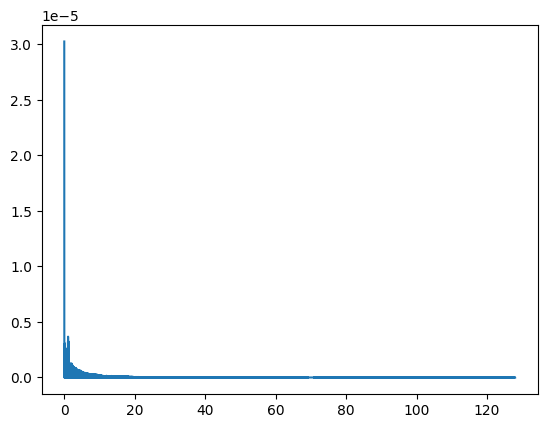

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0012-nsrr.xml
0012 Total: 230 samples | data length: 38176 (array([2, 3, 4]), array([ 24,  94, 112]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0012.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10964479  =      0.000 ... 42829.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10964480)
10964480


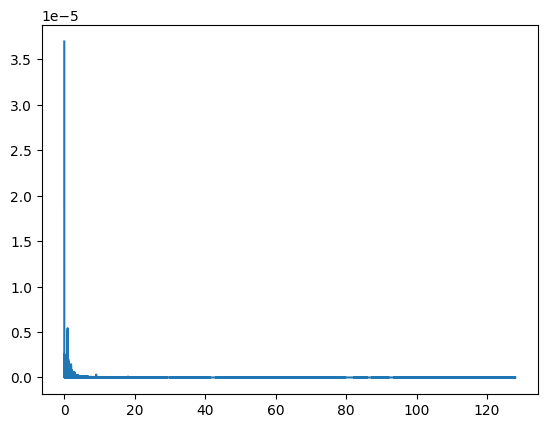

  0%|          | 0/1428 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0021-nsrr.xml
0021 Total: 280 samples | data length: 32192 (array([2, 3, 4]), array([ 80, 154,  46]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0021.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0021.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


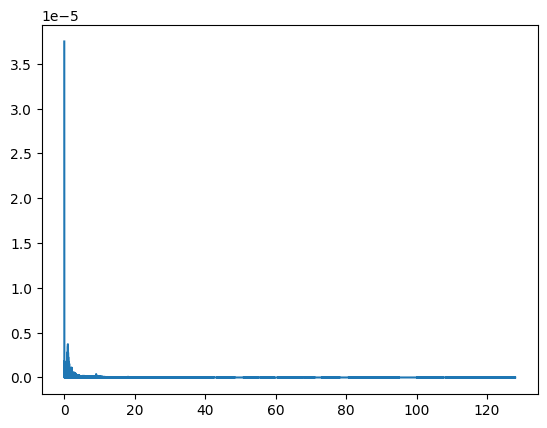

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0028-nsrr.xml
0028 Total: 207 samples | data length: 20103 (array([2, 3, 4]), array([ 41,  62, 104]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0028.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0028.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8754943  =      0.000 ... 34198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8754944)
8754944


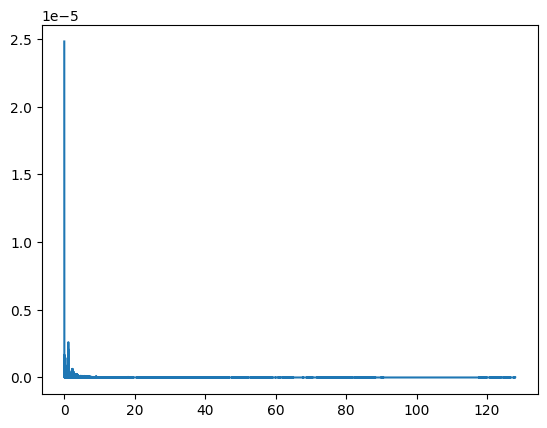

  0%|          | 0/1140 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0052-nsrr.xml
0052 Total: 133 samples | data length: 26253 (array([1, 2, 3, 4]), array([ 2,  6, 95, 30]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0052.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0052.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


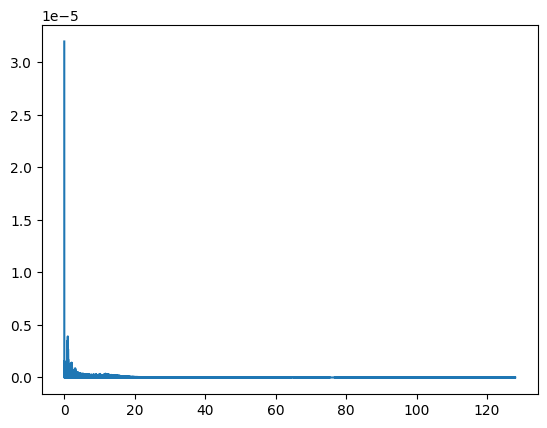

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0054-nsrr.xml
0054 Total: 207 samples | data length: 31757 (array([2, 3, 4]), array([ 10, 104,  93]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0054.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0054.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9676543  =      0.000 ... 37798.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9676544)
9676544


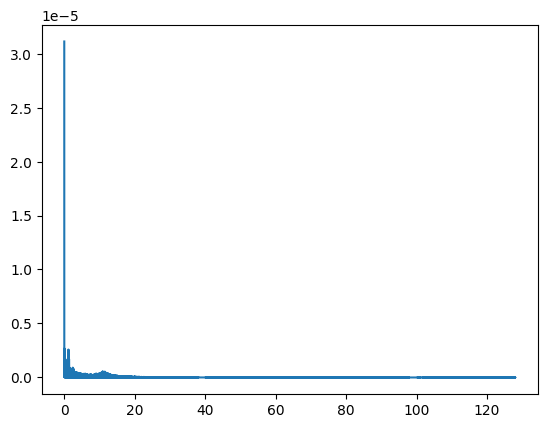

  0%|          | 0/1260 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0056-nsrr.xml
0056 Total: 115 samples | data length: 36917 (array([2, 3, 4]), array([ 1, 89, 25]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0056.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0056.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


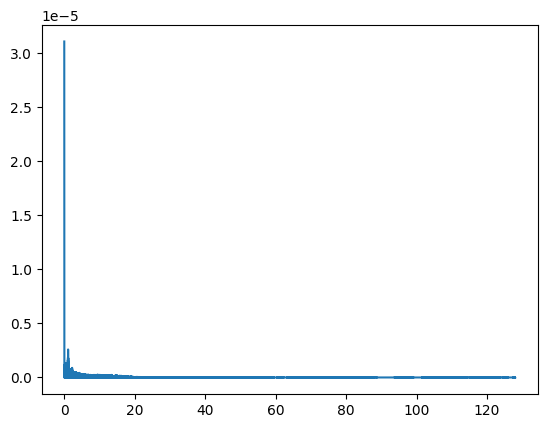

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0074-nsrr.xml
0074 Total: 237 samples | data length: 34373 (array([2, 3, 4]), array([ 16, 150,  71]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0074.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0074.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058687  =      0.000 ... 43197.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058688)
11058688


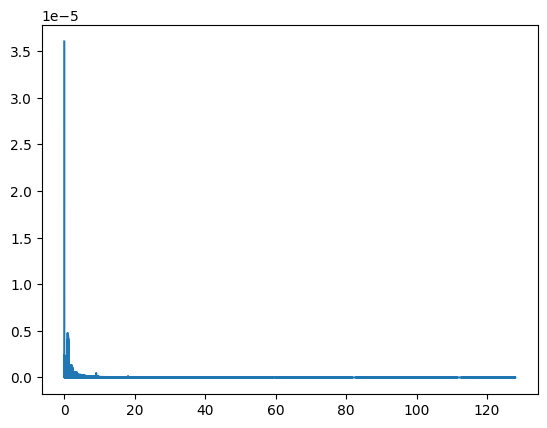

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0077-nsrr.xml
0077 Total: 91 samples | data length: 31025 (array([2, 3, 4]), array([ 6, 70, 15]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0077.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0077.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215999  =      0.000 ... 35999.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9216000)
9216000


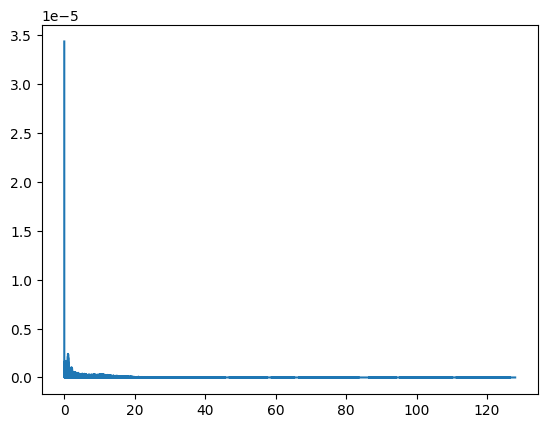

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0079-nsrr.xml
0079 Total: 145 samples | data length: 27208 (array([1, 2, 3, 4]), array([ 4,  8, 84, 49]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0079.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0079.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


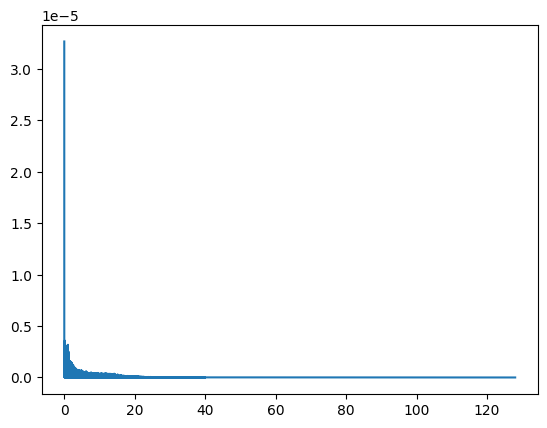

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0107-nsrr.xml
0107 Total: 774 samples | data length: 32651 (array([1, 2, 3, 4]), array([  1, 378, 311,  84]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0107.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0107.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


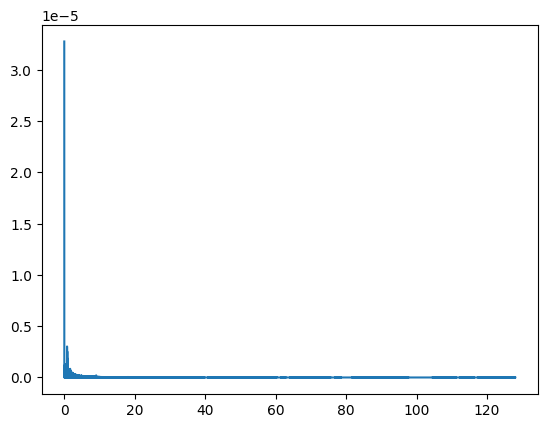

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0118-nsrr.xml
0118 Total: 145 samples | data length: 34692 (array([1, 2, 3, 4]), array([ 3,  4, 91, 47]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0118.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0118.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


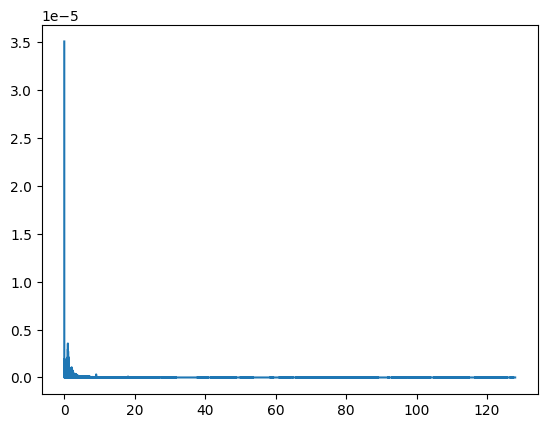

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0152-nsrr.xml
0152 Total: 136 samples | data length: 28242 (array([1, 2, 3, 4]), array([  1,   1, 104,  30]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0152.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0152.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215999  =      0.000 ... 35999.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9216000)
9216000


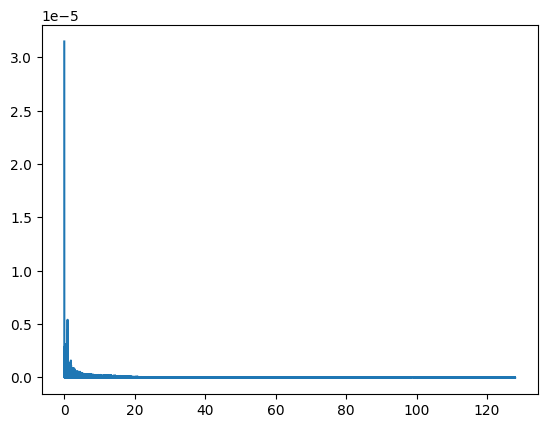

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0159-nsrr.xml
0159 Total: 105 samples | data length: 34554 (array([1, 3, 4]), array([ 3, 99,  3]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0159.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0159.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


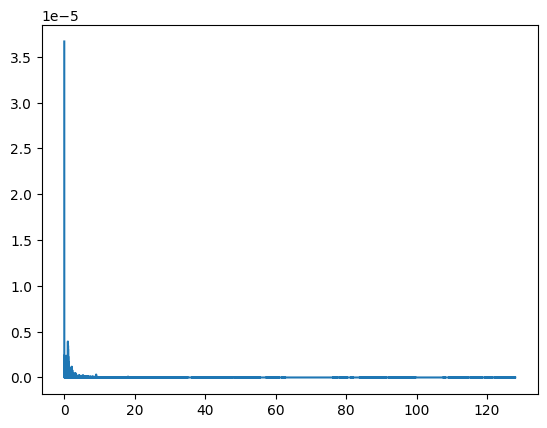

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0169-nsrr.xml
0169 Total: 257 samples | data length: 27390 (array([1, 2, 3, 4]), array([  9,  65,  59, 124]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0169.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0169.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


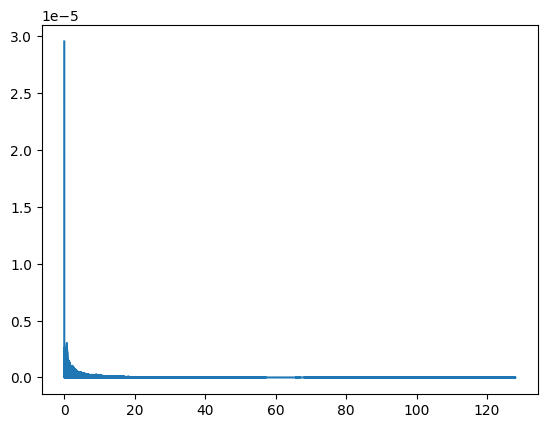

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0188-nsrr.xml
0188 Total: 225 samples | data length: 30755 (array([2, 3, 4]), array([ 24,  95, 106]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0188.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0188.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


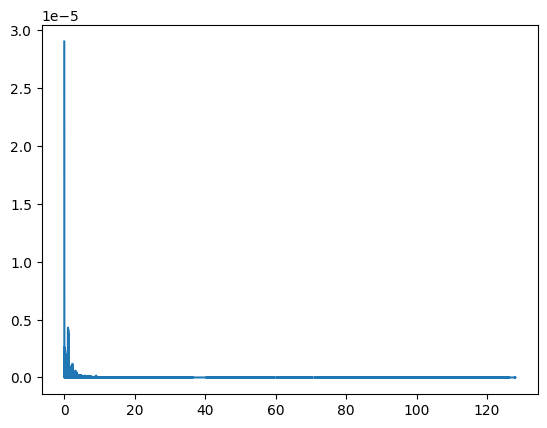

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0220-nsrr.xml
0220 Total: 387 samples | data length: 37874 (array([1, 2, 3, 4]), array([  2,  54, 178, 153]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0220.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0220.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


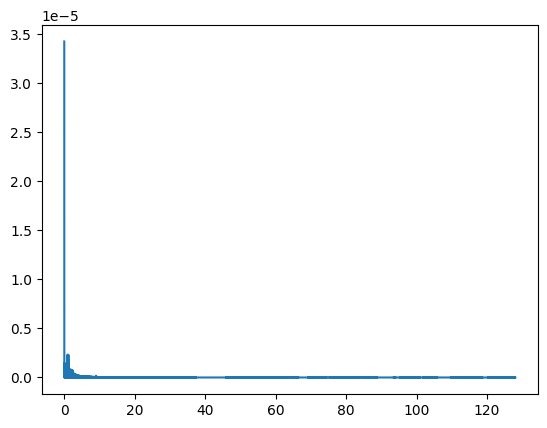

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0258-nsrr.xml
0258 Total: 59 samples | data length: 30173 (array([2, 3, 4]), array([ 3, 35, 21]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0258.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0258.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


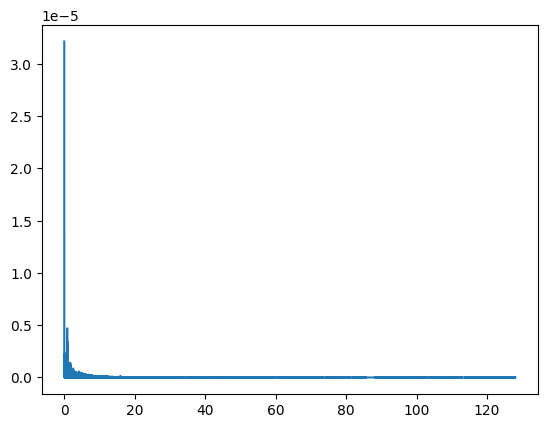

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0284-nsrr.xml
0284 Total: 87 samples | data length: 30228 (array([2, 3, 4]), array([ 1, 69, 17]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0284.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0284.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


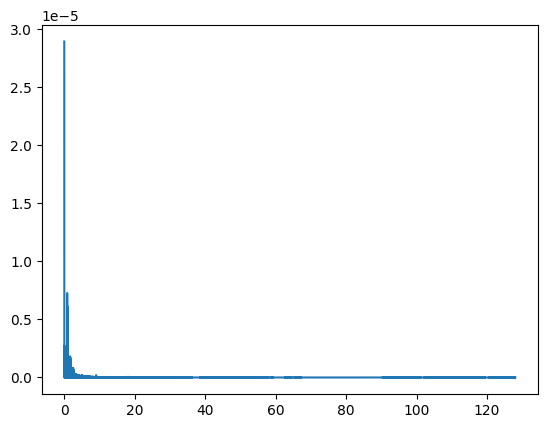

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0295-nsrr.xml
0295 Total: 16 samples | data length: 29700 (array([3]), array([16]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0295.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0295.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


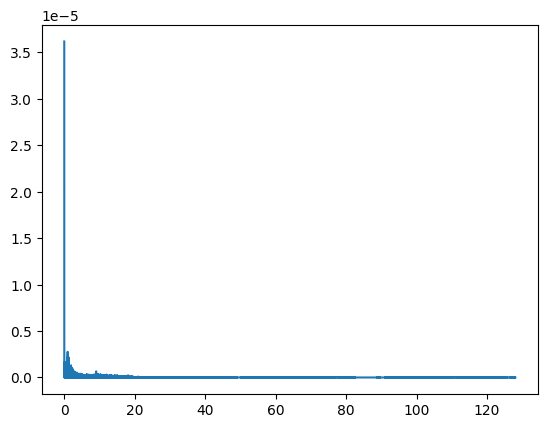

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0329-nsrr.xml
0329 Total: 244 samples | data length: 29857 (array([1, 3, 4]), array([  2, 141, 101]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0329.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0329.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


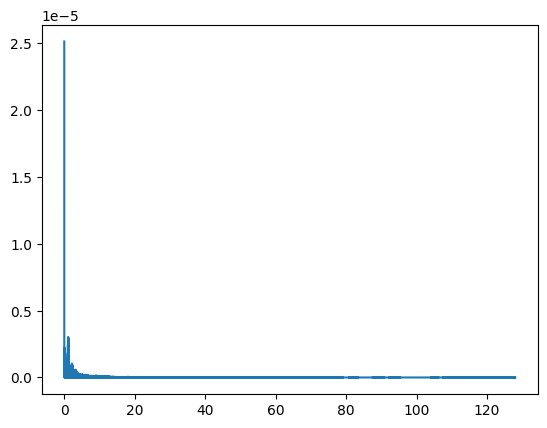

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0338-nsrr.xml
0338 Total: 429 samples | data length: 30827 (array([2, 3, 4]), array([262,  12, 155]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0338.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0338.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


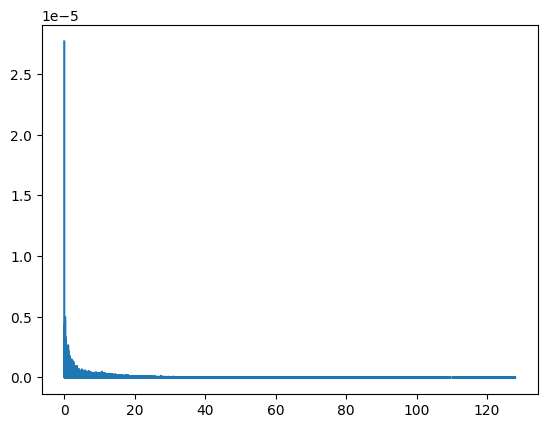

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0427-nsrr.xml
0427 Total: 23 samples | data length: 30023 (array([3]), array([23]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0427.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0427.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12902143  =      0.000 ... 50398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 12902144)
12902144


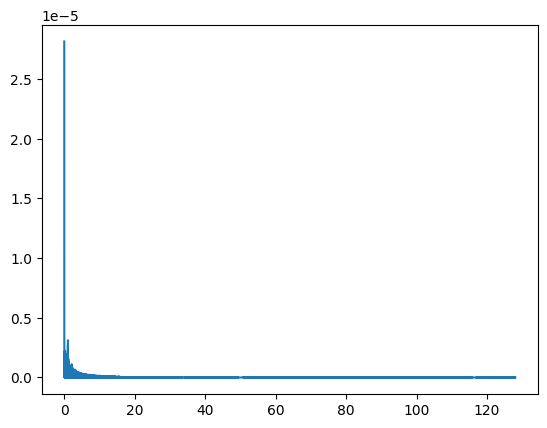

  0%|          | 0/1680 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0459-nsrr.xml
0459 Total: 203 samples | data length: 21119 (array([2, 3, 4]), array([  3,  84, 116]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0459.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0459.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11980287  =      0.000 ... 46797.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11980288)
11980288


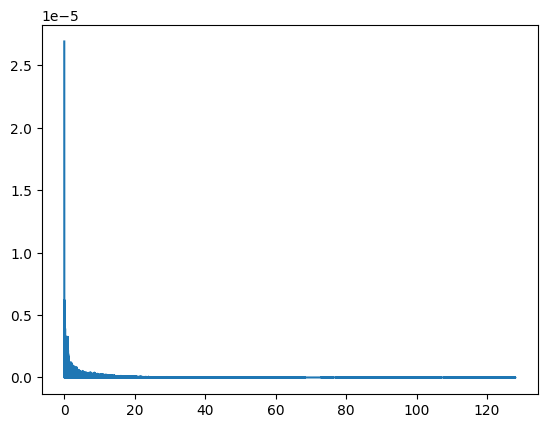

  0%|          | 0/1560 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0460-nsrr.xml
0460 Total: 124 samples | data length: 31029 (array([2, 3, 4]), array([ 2, 88, 34]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0460.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0460.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294399  =      0.000 ... 32399.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294400)
8294400


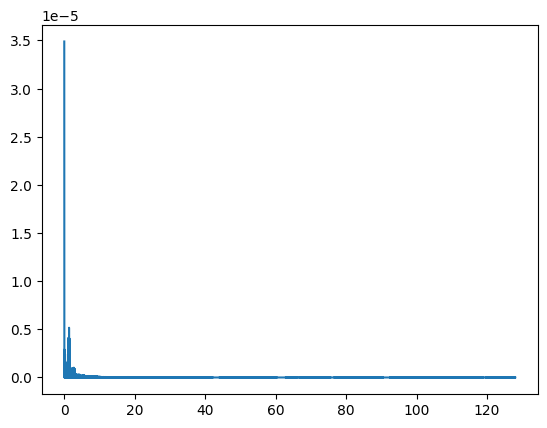

  0%|          | 0/1081 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0485-nsrr.xml
0485 Total: 241 samples | data length: 31206 (array([2, 3, 4]), array([ 29, 102, 110]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0485.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0485.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


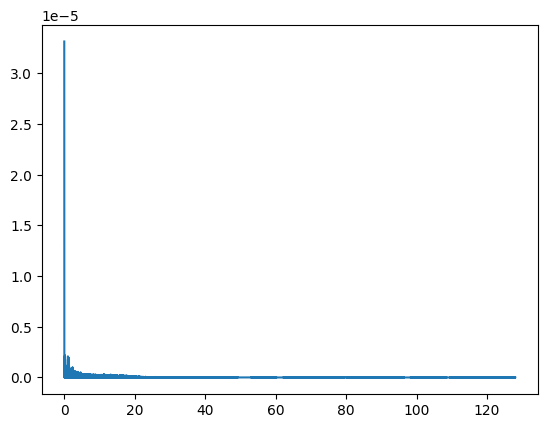

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0491-nsrr.xml
0491 Total: 136 samples | data length: 30105 (array([1, 2, 3, 4]), array([ 4, 13, 82, 37]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0491.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0491.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


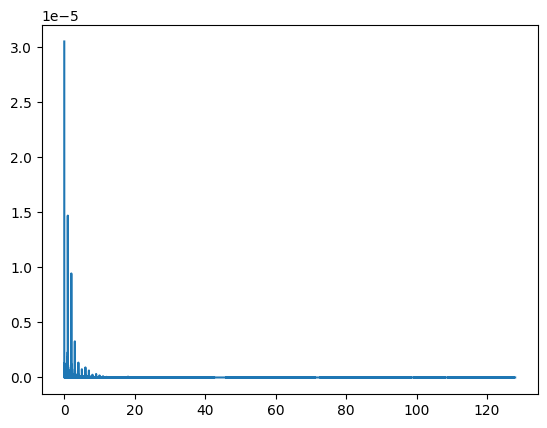

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0526-nsrr.xml
0526 Total: 146 samples | data length: 24446 (array([2, 3, 4]), array([  3, 113,  30]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0526.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0526.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


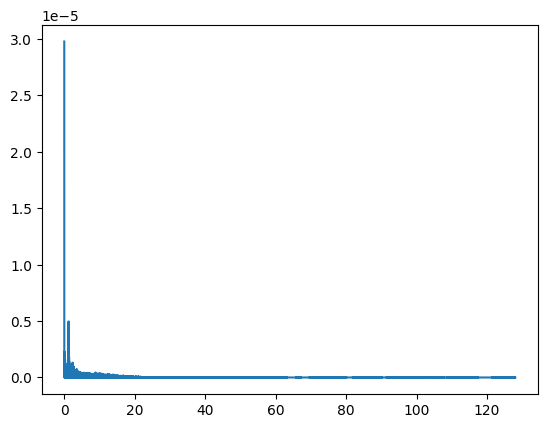

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0528-nsrr.xml
0528 Total: 108 samples | data length: 25356 (array([2, 3, 4]), array([ 7, 47, 54]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0528.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0528.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


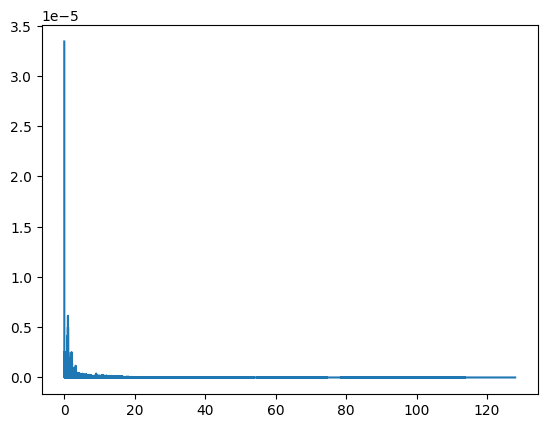

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0529-nsrr.xml
0529 Total: 180 samples | data length: 33912 (array([2, 3, 4]), array([  9, 109,  62]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0529.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0529.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


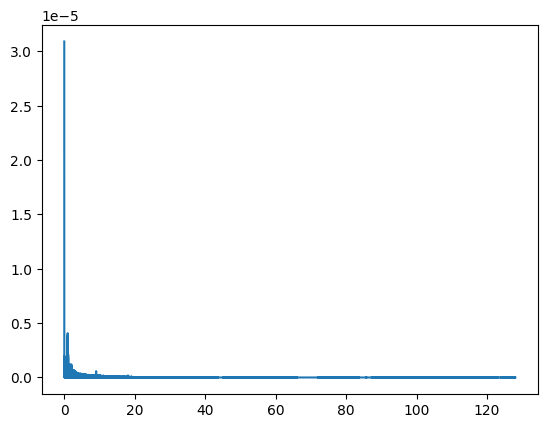

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0537-nsrr.xml
0537 Total: 255 samples | data length: 31962 (array([2, 3, 4]), array([  6, 183,  66]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0537.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0537.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294399  =      0.000 ... 32399.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294400)
8294400


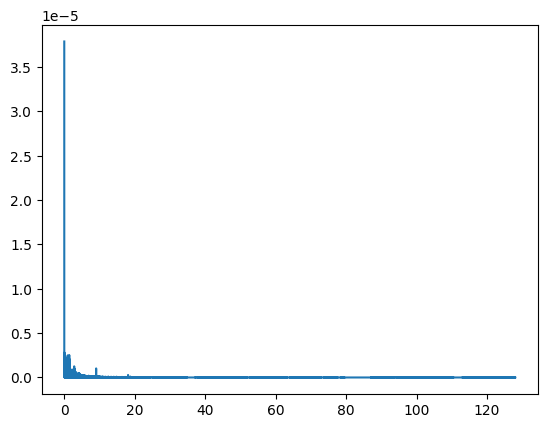

  0%|          | 0/1081 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0545-nsrr.xml
0545 Total: 168 samples | data length: 28534 (array([1, 2, 3, 4]), array([ 3, 22, 60, 83]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0545.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0545.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7372543  =      0.000 ... 28798.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 7372544)
7372544


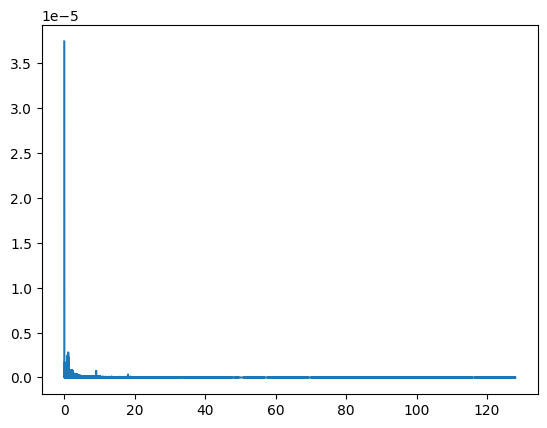

  0%|          | 0/960 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0550-nsrr.xml
0550 Total: 96 samples | data length: 26643 (array([1, 2, 3, 4]), array([ 1, 25, 42, 28]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0550.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0550.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


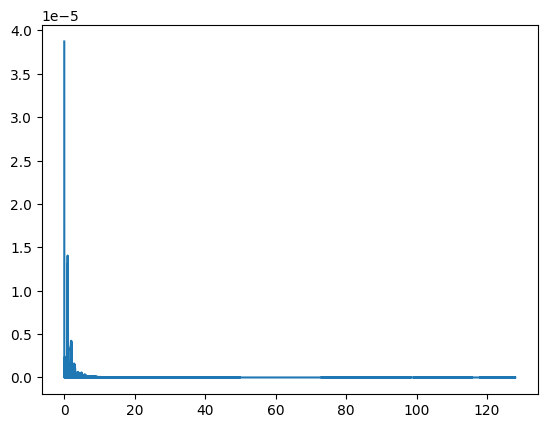

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0554-nsrr.xml
0554 Total: 278 samples | data length: 40821 (array([2, 3, 4]), array([  1, 207,  70]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0554.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0554.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11980543  =      0.000 ... 46798.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11980544)
11980544


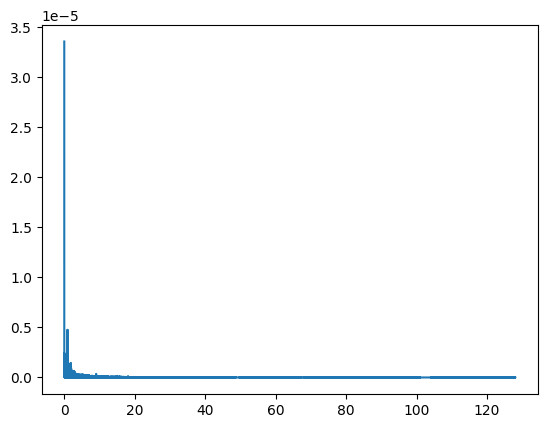

  0%|          | 0/1560 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0589-nsrr.xml
0589 Total: 338 samples | data length: 29860 (array([1, 2, 3, 4]), array([ 20,  45, 125, 148]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0589.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0589.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8293887  =      0.000 ... 32397.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8293888)
8293888


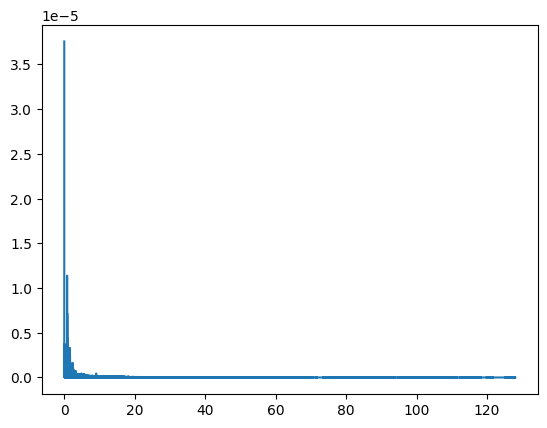

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0596-nsrr.xml
0596 Total: 113 samples | data length: 35079 (array([1, 2, 3, 4]), array([ 2,  1, 69, 41]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0596.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0596.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


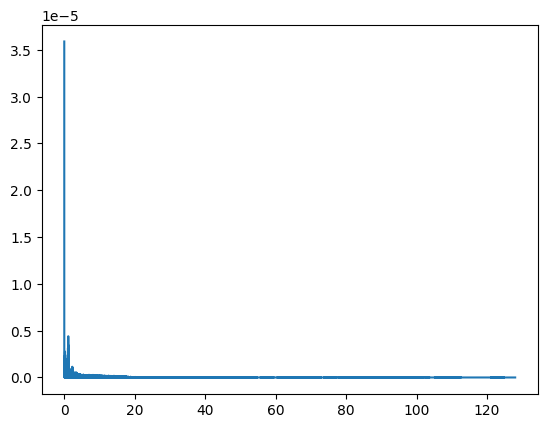

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0626-nsrr.xml
0626 Total: 419 samples | data length: 34345 (array([1, 2, 3, 4]), array([  8, 127, 169, 115]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0626.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0626.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215487  =      0.000 ... 35997.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215488)
9215488


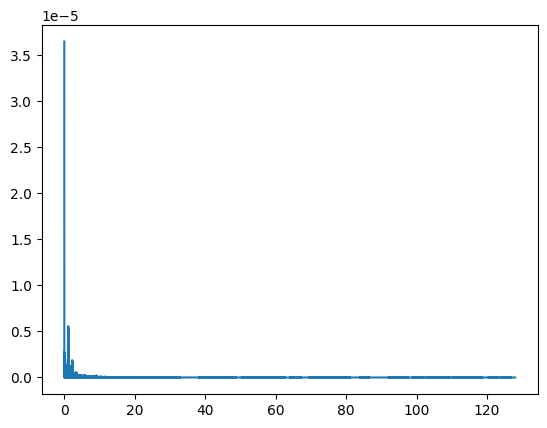

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0629-nsrr.xml
0629 Total: 100 samples | data length: 34404 (array([3, 4]), array([84, 16]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0629.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0629.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


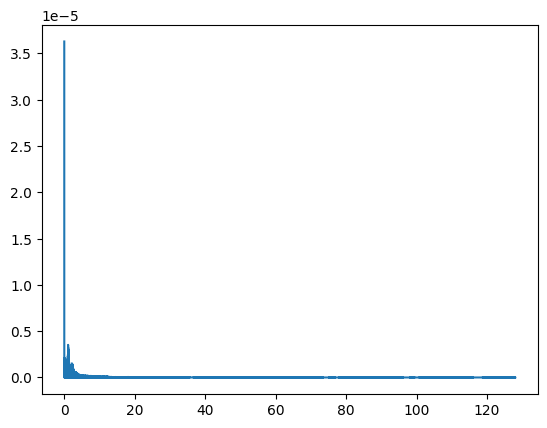

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0664-nsrr.xml
0664 Total: 18 samples | data length: 32752 (array([2, 3, 4]), array([ 1, 15,  2]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0664.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0664.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


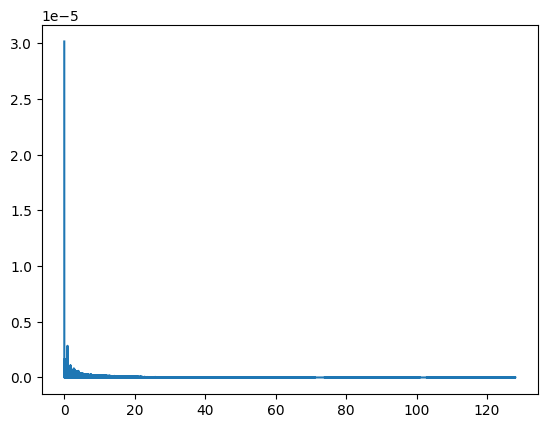

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0711-nsrr.xml
0711 Total: 260 samples | data length: 36579 (array([2, 3, 4]), array([ 21, 151,  88]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0711.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0711.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


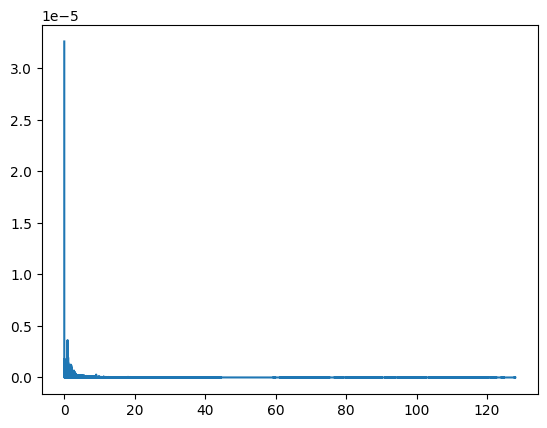

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0782-nsrr.xml
0782 Total: 72 samples | data length: 31633 (array([2, 3, 4]), array([ 4, 47, 21]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0782.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0782.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


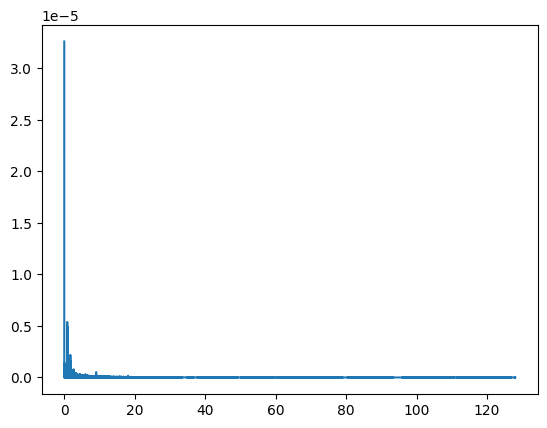

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0791-nsrr.xml
0791 Total: 260 samples | data length: 35998 (array([2, 3, 4]), array([  7, 128, 125]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0791.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0791.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


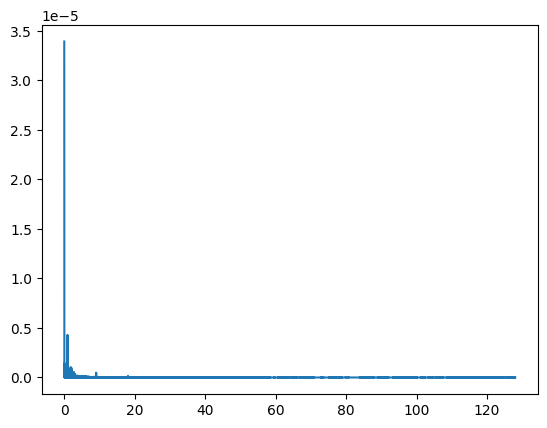

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0821-nsrr.xml
0821 Total: 199 samples | data length: 31138 (array([2, 3, 4]), array([ 32, 106,  61]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0821.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0821.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


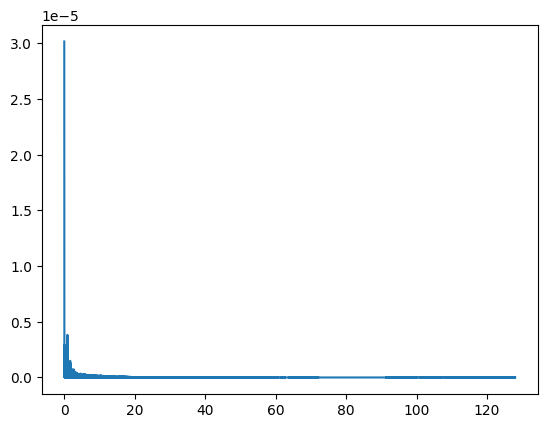

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0828-nsrr.xml
0828 Total: 172 samples | data length: 34093 (array([1, 2, 3, 4]), array([  1,   2, 103,  66]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0828.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0828.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


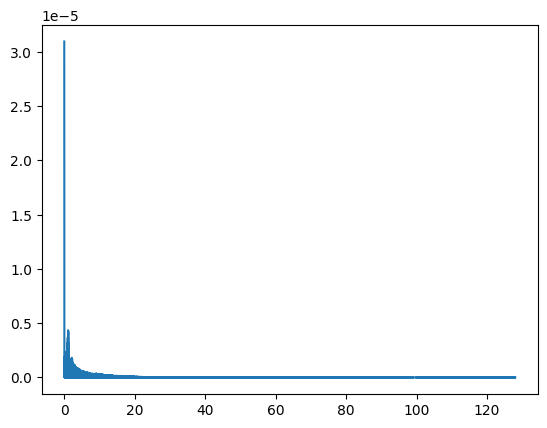

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0837-nsrr.xml
0837 Total: 147 samples | data length: 31231 (array([3, 4]), array([109,  38]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0837.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0837.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


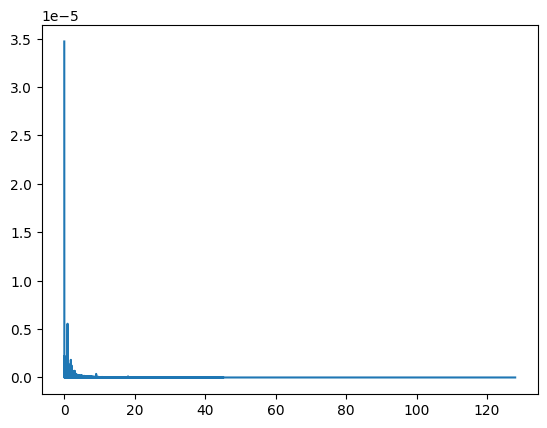

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0838-nsrr.xml
0838 Total: 104 samples | data length: 31973 (array([1, 2, 3, 4]), array([ 1,  3, 76, 24]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0838.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0838.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9676543  =      0.000 ... 37798.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9676544)
9676544


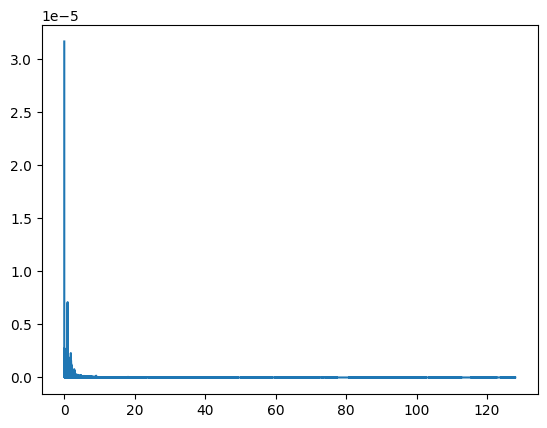

  0%|          | 0/1260 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0854-nsrr.xml
0854 Total: 45 samples | data length: 37185 (array([2, 3, 4]), array([ 2, 38,  5]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0854.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0854.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


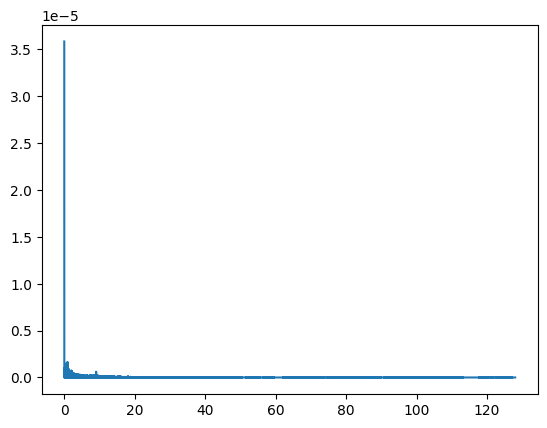

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0856-nsrr.xml
0856 Total: 146 samples | data length: 31399 (array([1, 2, 3, 4]), array([ 8,  9, 93, 36]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0856.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0856.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294399  =      0.000 ... 32399.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294400)
8294400


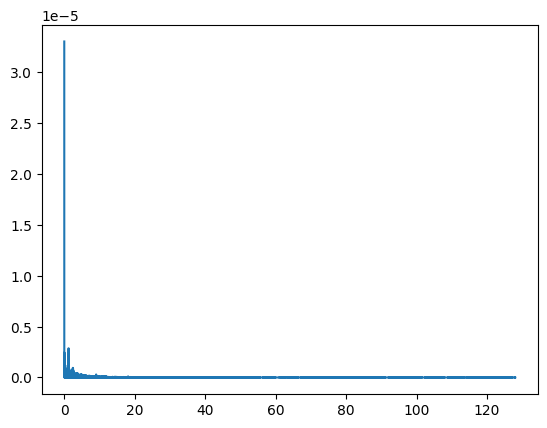

  0%|          | 0/1081 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0862-nsrr.xml
0862 Total: 58 samples | data length: 32281 (array([1, 2, 3, 4]), array([ 1,  1, 45, 11]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0862.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0862.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


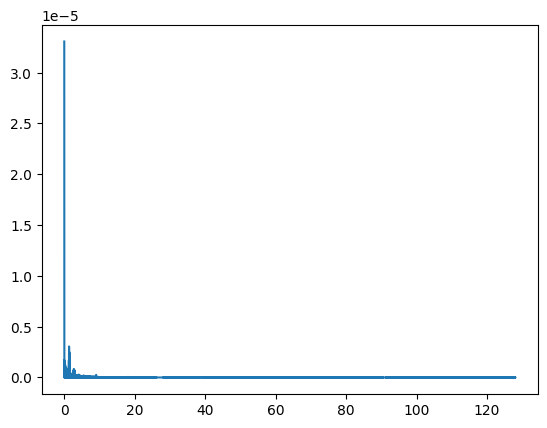

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0884-nsrr.xml
0884 Total: 176 samples | data length: 26872 (array([2, 3, 4]), array([ 5, 98, 73]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0884.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0884.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


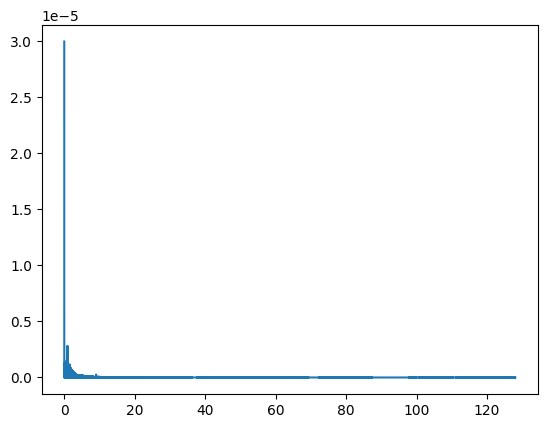

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0899-nsrr.xml
0899 Total: 50 samples | data length: 29243 (array([1, 3, 4]), array([ 1, 29, 20]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0899.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0899.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


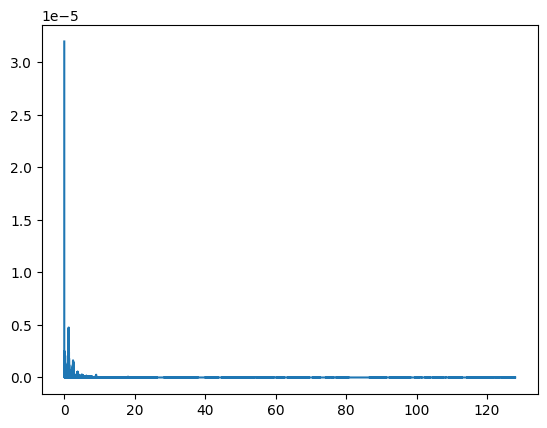

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0914-nsrr.xml
0914 Total: 128 samples | data length: 30967 (array([1, 2, 3, 4]), array([ 1, 25, 68, 34]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0914.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0914.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215487  =      0.000 ... 35997.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215488)
9215488


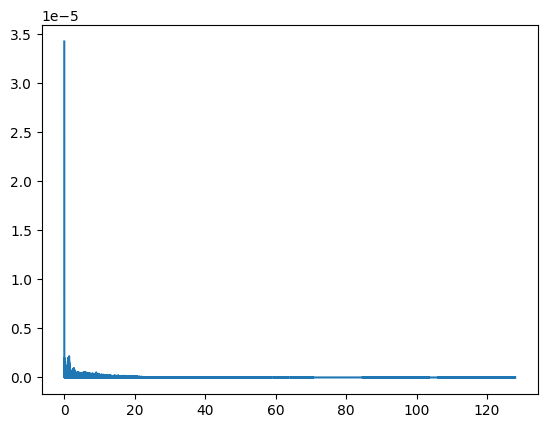

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0921-nsrr.xml
0921 Total: 266 samples | data length: 29328 (array([1, 2, 3, 4]), array([  4,  27,  66, 169]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0921.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0921.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


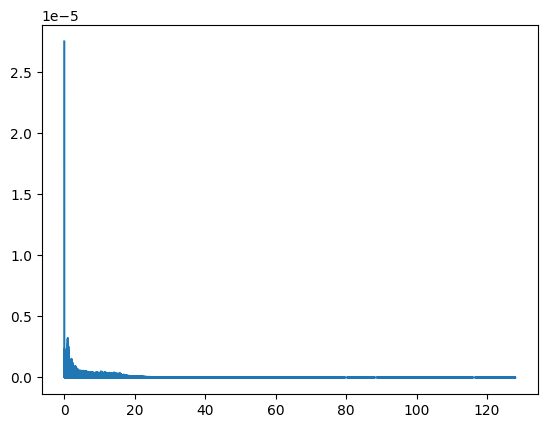

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0967-nsrr.xml
0967 Total: 151 samples | data length: 38359 (array([1, 2, 3, 4]), array([  4,   3, 113,  31]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0967.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0967.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


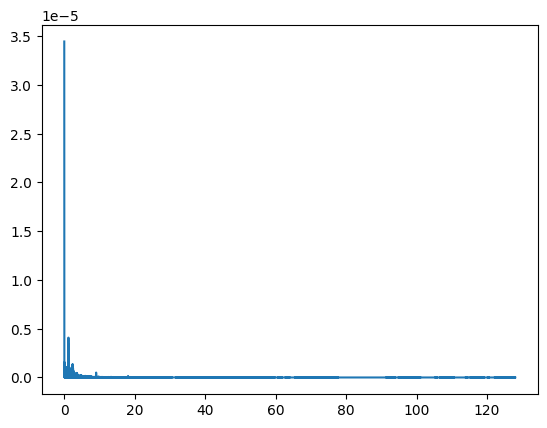

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-0980-nsrr.xml
0980 Total: 117 samples | data length: 28738 (array([3, 4]), array([99, 18]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0980.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-0980.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


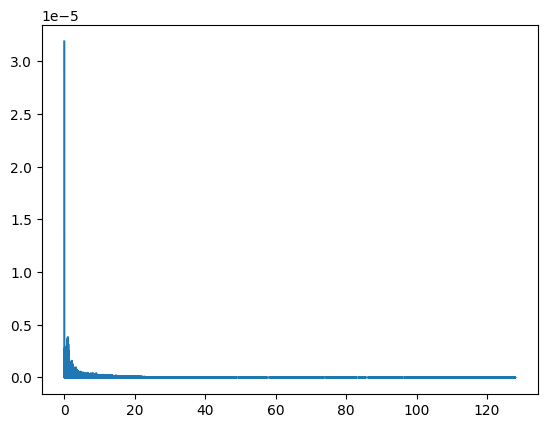

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1016-nsrr.xml
1016 Total: 230 samples | data length: 29197 (array([1, 2, 3, 4]), array([  1,  11, 187,  31]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1016.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


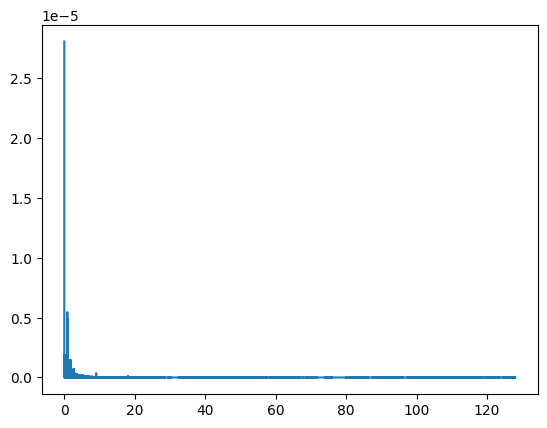

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1019-nsrr.xml
1019 Total: 242 samples | data length: 26516 (array([1, 2, 3, 4]), array([  1,  12, 129, 100]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1019.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


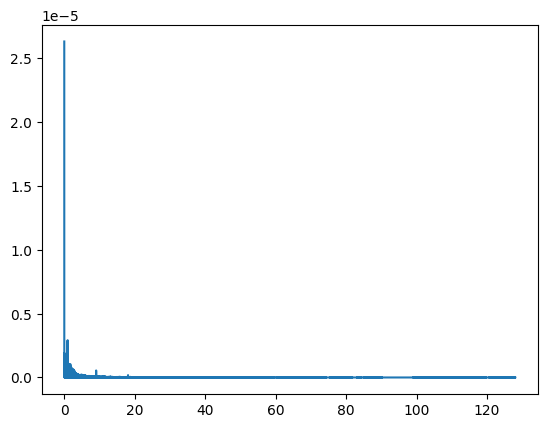

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1033-nsrr.xml
1033 Total: 312 samples | data length: 35792 (array([2, 3, 4]), array([  8, 257,  47]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1033.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1033.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


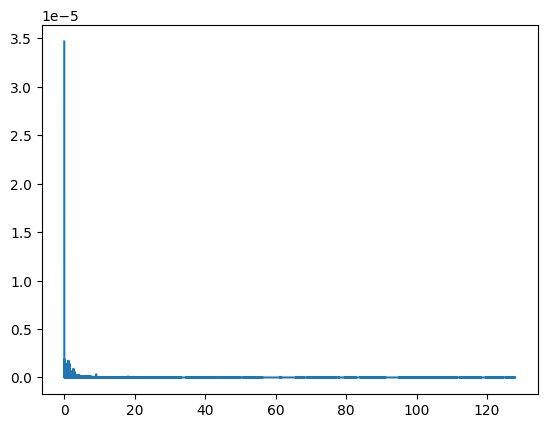

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1077-nsrr.xml
1077 Total: 289 samples | data length: 29700 (array([2, 3, 4]), array([  2, 236,  51]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1077.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1077.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


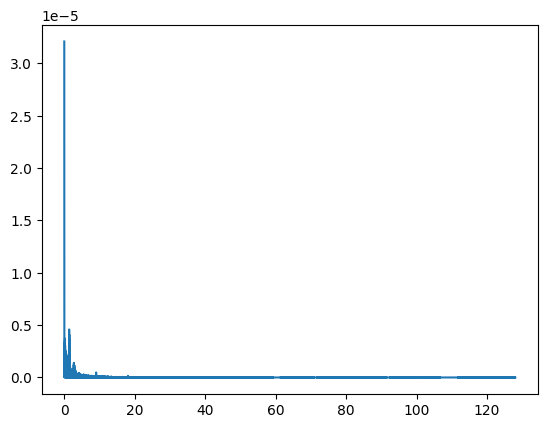

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1085-nsrr.xml
1085 Total: 127 samples | data length: 38755 (array([1, 2, 3, 4]), array([ 2,  1, 71, 53]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1085.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1085.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


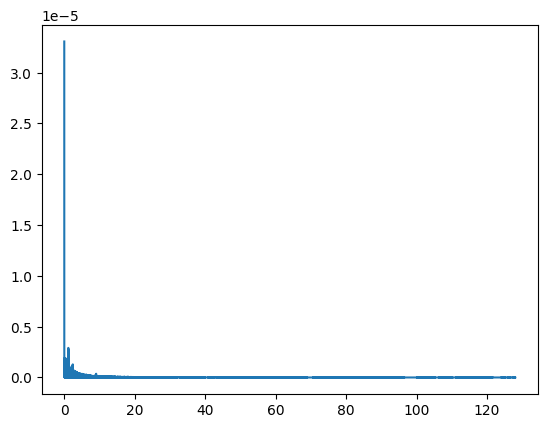

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1098-nsrr.xml
1098 Total: 45 samples | data length: 22499 (array([3]), array([45]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1098.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1098.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


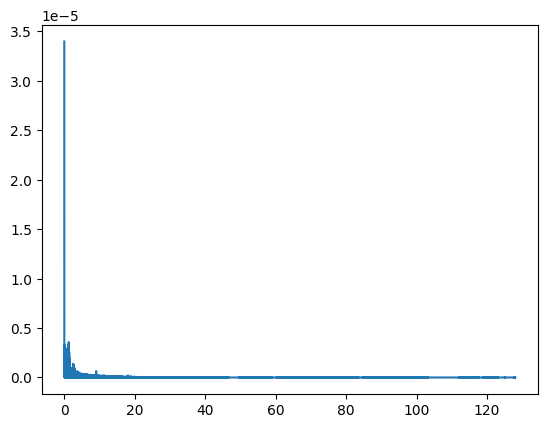

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1122-nsrr.xml
1122 Total: 145 samples | data length: 28139 (array([3, 4]), array([51, 94]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1122.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1122.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


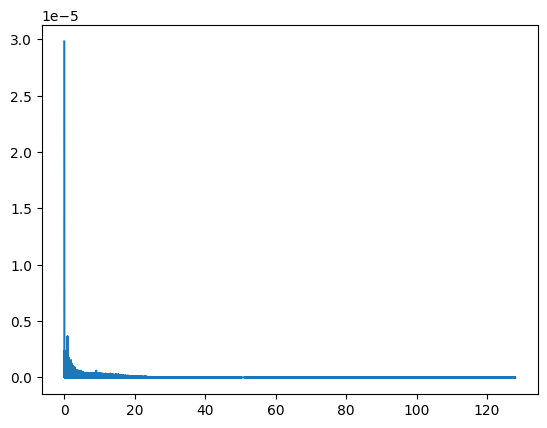

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1128-nsrr.xml
1128 Total: 438 samples | data length: 37329 (array([1, 2, 3, 4]), array([  3,  36, 285, 114]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1128.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1128.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9676543  =      0.000 ... 37798.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9676544)
9676544


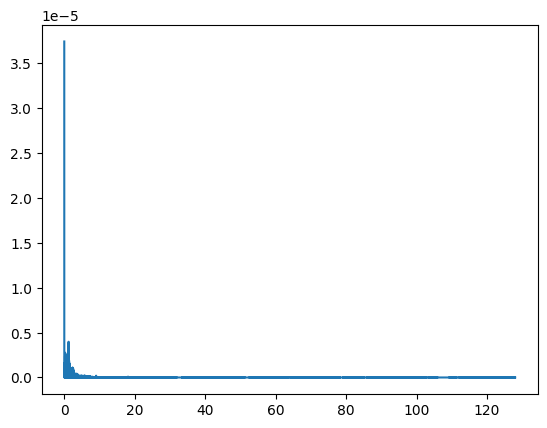

  0%|          | 0/1260 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1162-nsrr.xml
1162 Total: 200 samples | data length: 33881 (array([1, 2, 3, 4]), array([ 6, 21, 85, 88]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1162.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1162.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058687  =      0.000 ... 43197.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058688)
11058688


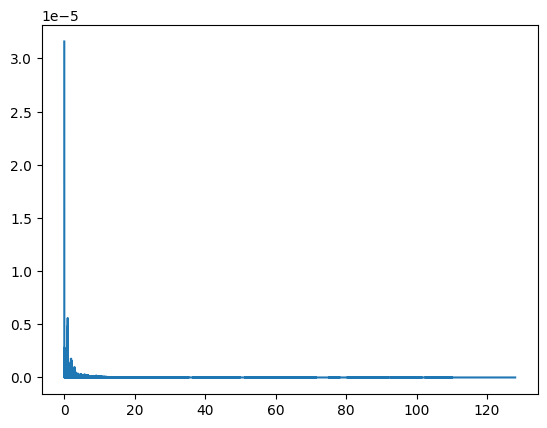

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1164-nsrr.xml
1164 Total: 221 samples | data length: 30047 (array([1, 2, 3, 4]), array([  1,   4, 129,  87]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1164.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1164.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


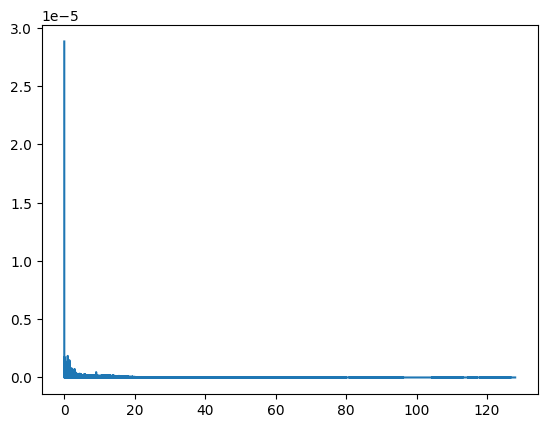

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1236-nsrr.xml
1236 Total: 360 samples | data length: 28659 (array([1, 2, 3, 4]), array([  1,  44, 225,  90]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1236.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1236.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9721855  =      0.000 ... 37975.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9721856)
9721856


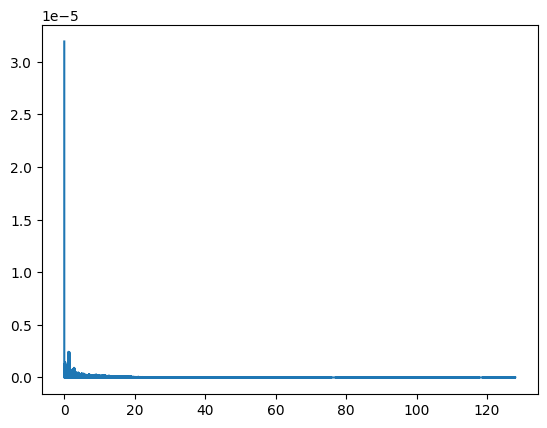

  0%|          | 0/1266 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1260-nsrr.xml
1260 Total: 123 samples | data length: 22654 (array([2, 3, 4]), array([  1, 120,   2]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1260.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1260.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


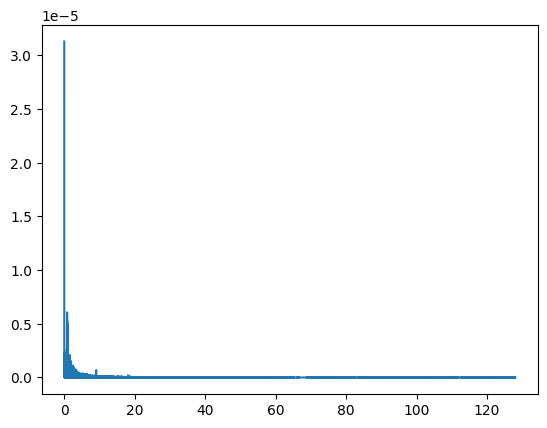

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1266-nsrr.xml
1266 Total: 393 samples | data length: 34496 (array([1, 2, 3, 4]), array([  1,  40, 272,  80]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1266.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1266.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215999  =      0.000 ... 35999.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9216000)
9216000


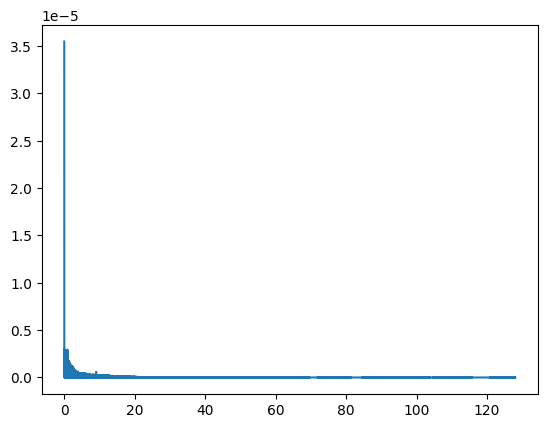

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1268-nsrr.xml
1268 Total: 162 samples | data length: 30929 (array([1, 2, 3, 4]), array([  2,   2, 102,  56]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1268.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1268.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


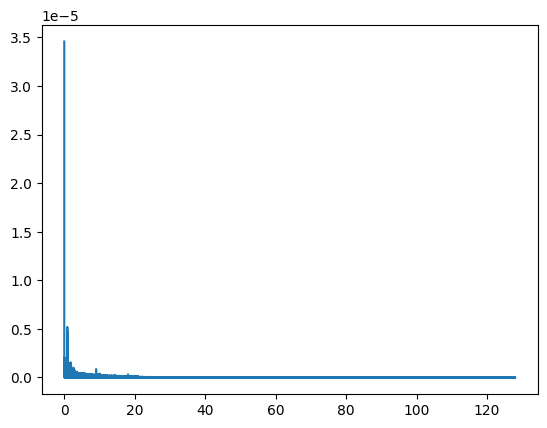

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1294-nsrr.xml
1294 Total: 167 samples | data length: 29316 (array([2, 3, 4]), array([ 2, 82, 83]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1294.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1294.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


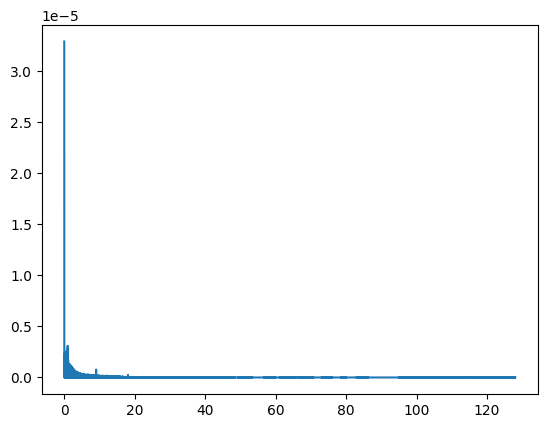

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1334-nsrr.xml
1334 Total: 552 samples | data length: 36637 (array([2, 3, 4]), array([ 60, 231, 261]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1334.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1334.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


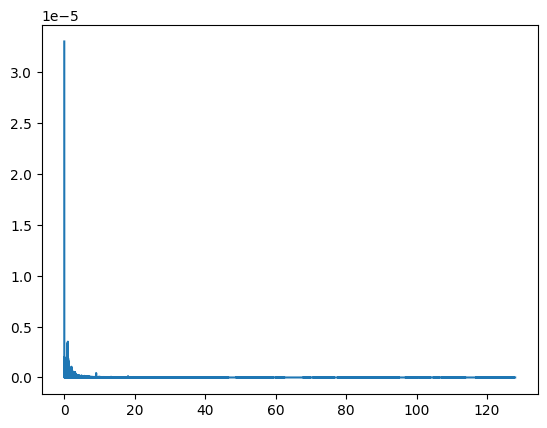

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1418-nsrr.xml
1418 Total: 271 samples | data length: 29989 (array([2, 3, 4]), array([ 22, 124, 125]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1418.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1418.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8754943  =      0.000 ... 34198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8754944)
8754944


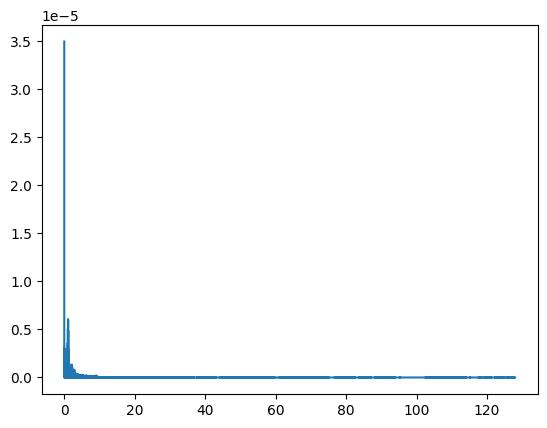

  0%|          | 0/1140 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1459-nsrr.xml
1459 Total: 200 samples | data length: 31592 (array([3, 4]), array([148,  52]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1459.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1459.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


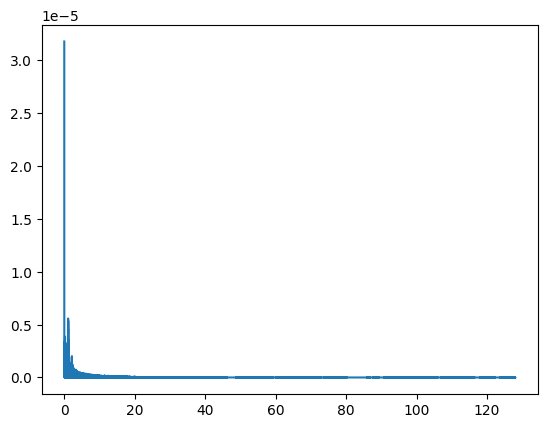

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1463-nsrr.xml
1463 Total: 121 samples | data length: 32361 (array([1, 2, 3, 4]), array([ 4, 10, 69, 38]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1463.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1463.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


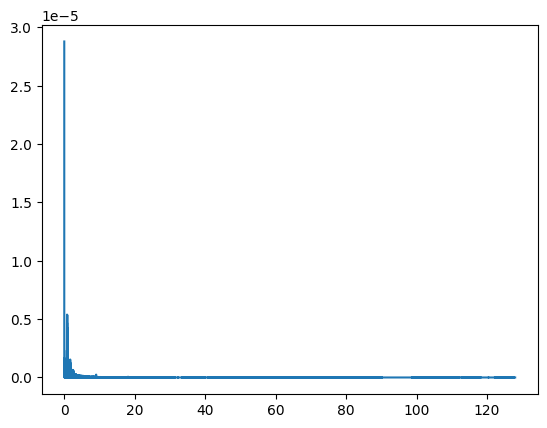

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1470-nsrr.xml
1470 Total: 81 samples | data length: 34562 (array([1, 2, 3, 4]), array([ 2,  4, 52, 23]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1470.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1470.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


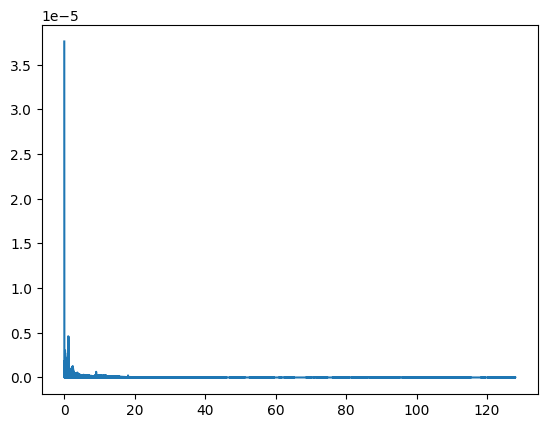

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1478-nsrr.xml
1478 Total: 373 samples | data length: 30912 (array([1, 2, 3, 4]), array([ 12,  27, 192, 142]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1478.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1478.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


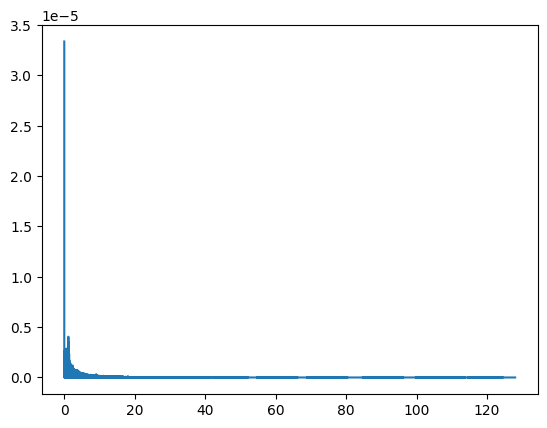

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1497-nsrr.xml
1497 Total: 706 samples | data length: 37208 (array([1, 2, 3, 4]), array([ 54, 433,  53, 166]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1497.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1497.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


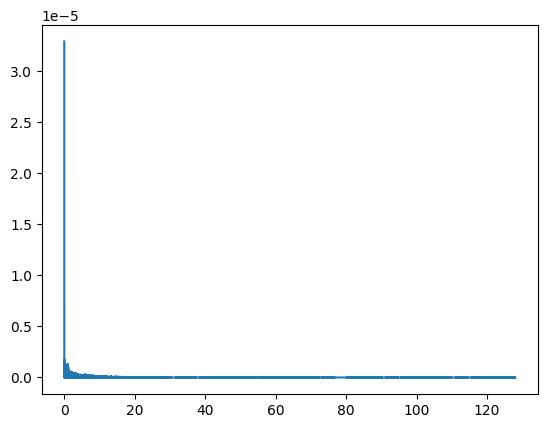

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1502-nsrr.xml
1502 Total: 303 samples | data length: 32222 (array([1, 2, 3, 4]), array([  4, 102,  53, 144]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1502.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1502.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


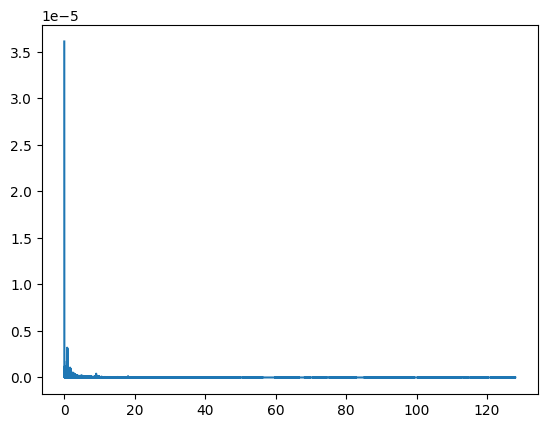

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1520-nsrr.xml
1520 Total: 210 samples | data length: 35440 (array([2, 3, 4]), array([  1, 168,  41]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1520.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1520.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10598143  =      0.000 ... 41398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10598144)
10598144


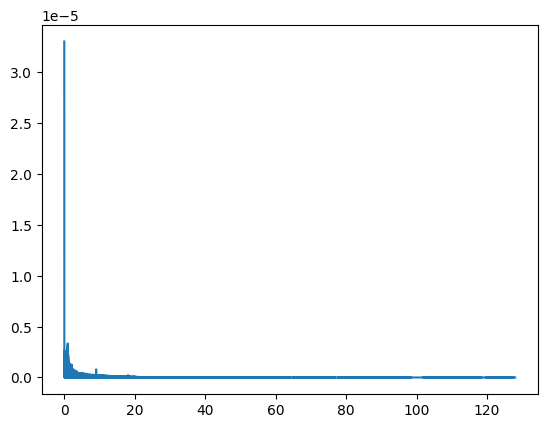

  0%|          | 0/1380 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1527-nsrr.xml
1527 Total: 123 samples | data length: 29760 (array([2, 3, 4]), array([15, 28, 80]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1527.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1527.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294399  =      0.000 ... 32399.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294400)
8294400


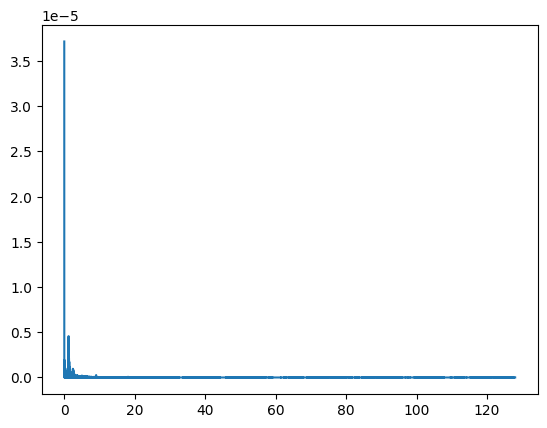

  0%|          | 0/1081 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1571-nsrr.xml
1571 Total: 281 samples | data length: 32398 (array([2, 3, 4]), array([ 19, 211,  51]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1571.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1571.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


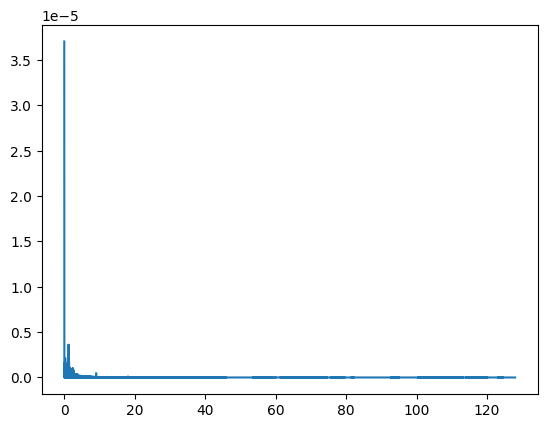

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1607-nsrr.xml
1607 Total: 213 samples | data length: 30541 (array([1, 2, 3, 4]), array([ 12,   2,  84, 115]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1607.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1607.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


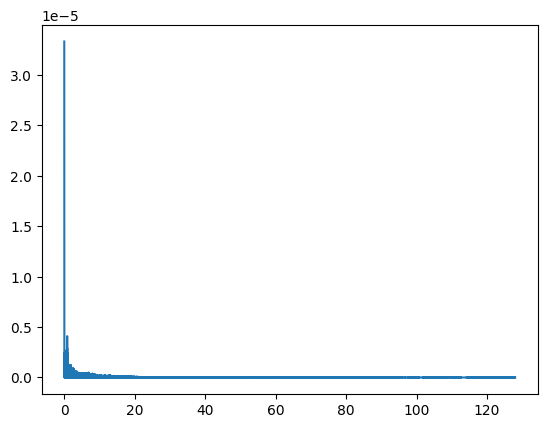

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1612-nsrr.xml
1612 Total: 75 samples | data length: 35099 (array([1, 3, 4]), array([ 1, 48, 26]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1612.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1612.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


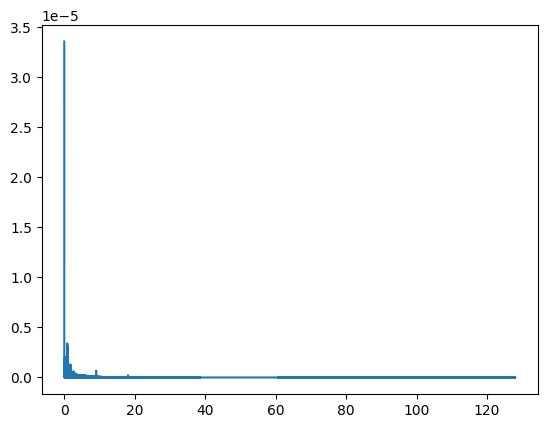

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1677-nsrr.xml
1677 Total: 163 samples | data length: 36129 (array([2, 3, 4]), array([ 5, 93, 65]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1677.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1677.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


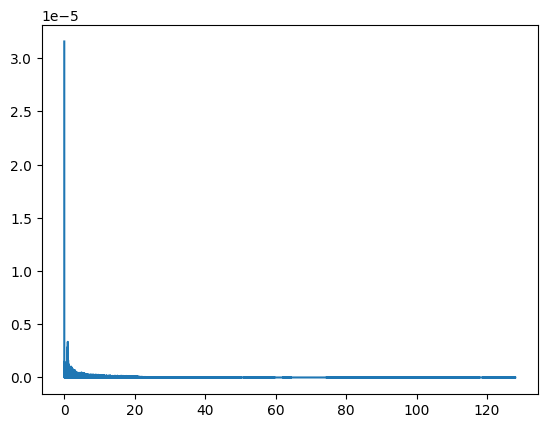

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1686-nsrr.xml
1686 Total: 415 samples | data length: 33485 (array([2, 3, 4]), array([  4, 341,  70]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1686.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1686.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


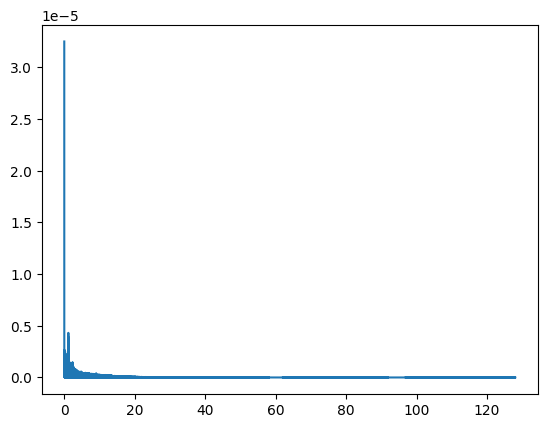

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1756-nsrr.xml
1756 Total: 395 samples | data length: 29168 (array([1, 2, 3, 4]), array([  6,  73, 142, 174]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1756.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1756.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


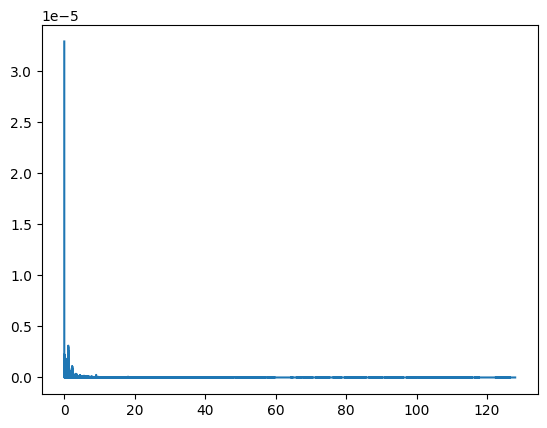

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1764-nsrr.xml
1764 Total: 295 samples | data length: 27558 (array([1, 2, 3, 4]), array([  8,  43,  77, 167]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1764.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1764.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


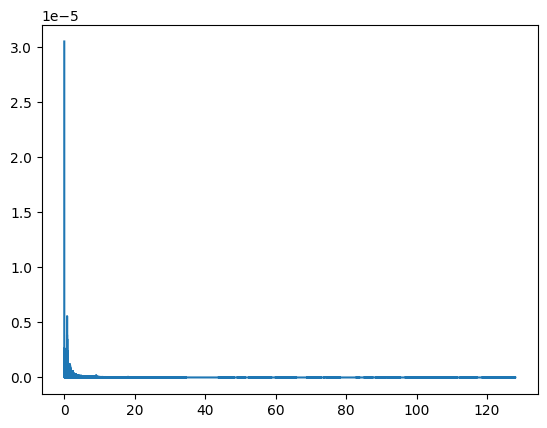

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1766-nsrr.xml
1766 Total: 56 samples | data length: 30599 (array([3, 4]), array([36, 20]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1766.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1766.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


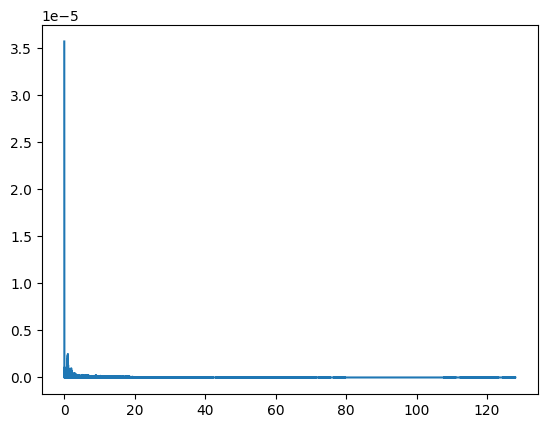

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1801-nsrr.xml
1801 Total: 383 samples | data length: 28799 (array([2, 3, 4]), array([184,  20, 179]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1801.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1801.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9676287  =      0.000 ... 37797.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9676288)
9676288


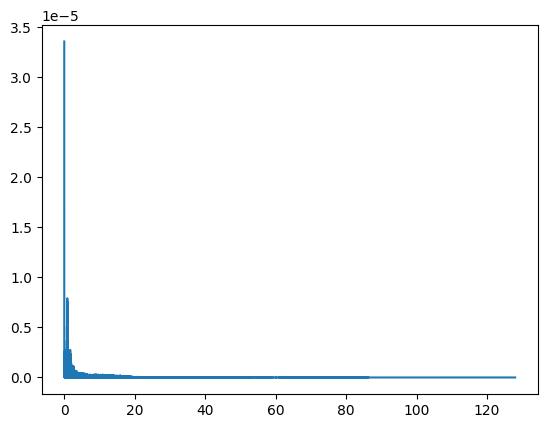

  0%|          | 0/1260 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1842-nsrr.xml
1842 Total: 101 samples | data length: 32302 (array([1, 2, 3, 4]), array([ 1,  2, 64, 34]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1842.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1842.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215999  =      0.000 ... 35999.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9216000)
9216000


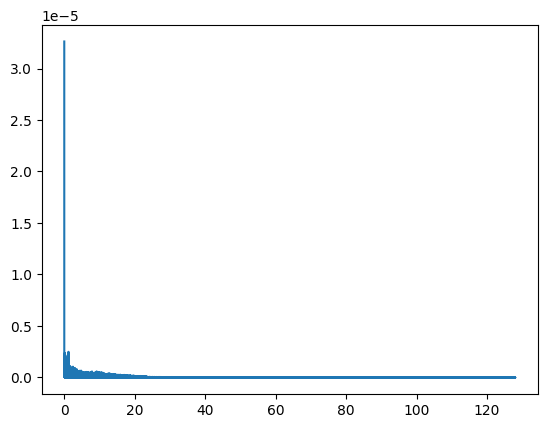

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
overlap_count 14
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1859-nsrr.xml
1859 Total: 106 samples | data length: 42862 (array([1, 2, 3, 4]), array([ 3, 23, 27, 53]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1859.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1859.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


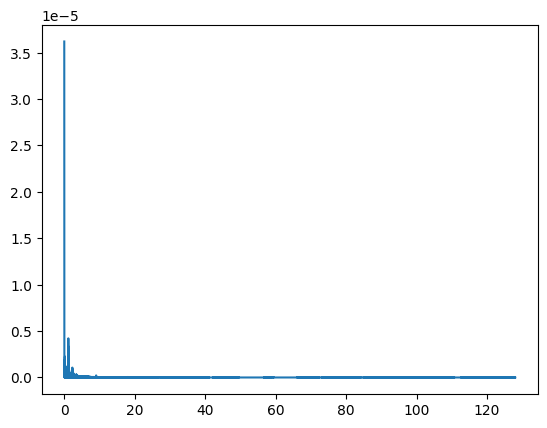

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1866-nsrr.xml
1866 Total: 42 samples | data length: 27678 (array([3, 4]), array([28, 14]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1866.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1866.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 24454911  =      0.000 ... 95526.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 24454912)
24454912


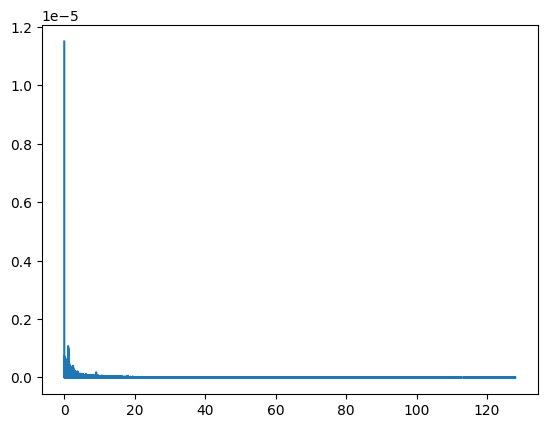

  0%|          | 0/3185 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-1997-nsrr.xml
1997 Total: 307 samples | data length: 32383 (array([2, 3, 4]), array([ 36, 155, 116]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1997.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-1997.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


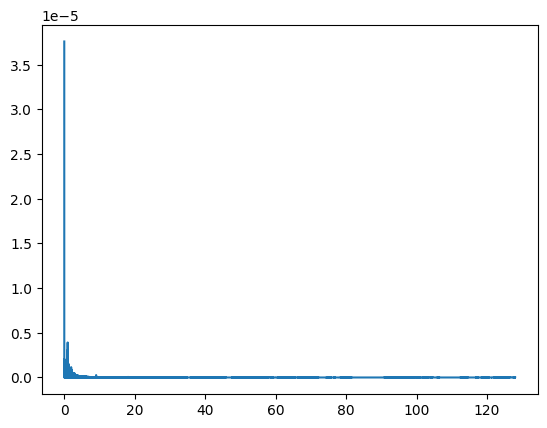

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2019-nsrr.xml
2019 Total: 87 samples | data length: 32288 (array([1, 2, 3, 4]), array([ 2,  7, 67, 11]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2019.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


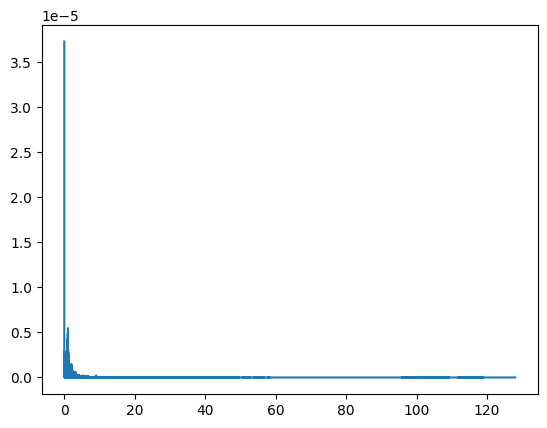

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2106-nsrr.xml
2106 Total: 384 samples | data length: 35116 (array([1, 2, 3, 4]), array([  1,  55, 198, 130]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2106.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2106.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11129343  =      0.000 ... 43473.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11129344)
11129344


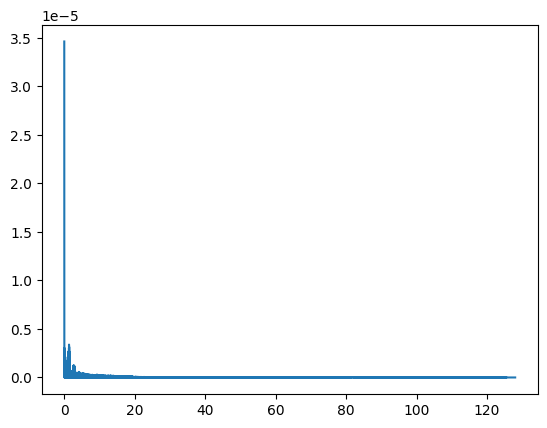

  0%|          | 0/1450 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2147-nsrr.xml
2147 Total: 401 samples | data length: 33583 (array([1, 2, 3, 4]), array([ 29,  16, 206, 150]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2147.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2147.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


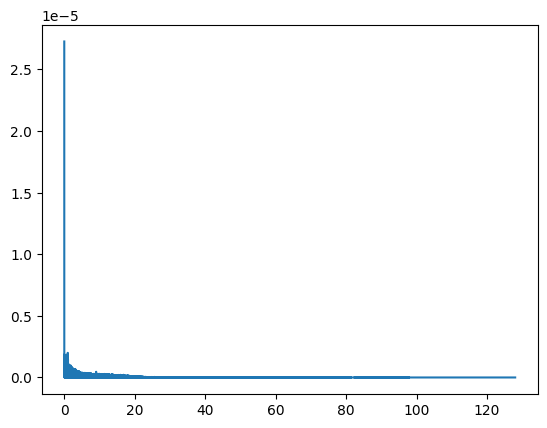

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2163-nsrr.xml
2163 Total: 88 samples | data length: 30004 (array([2, 3, 4]), array([ 8, 76,  4]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2163.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2163.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


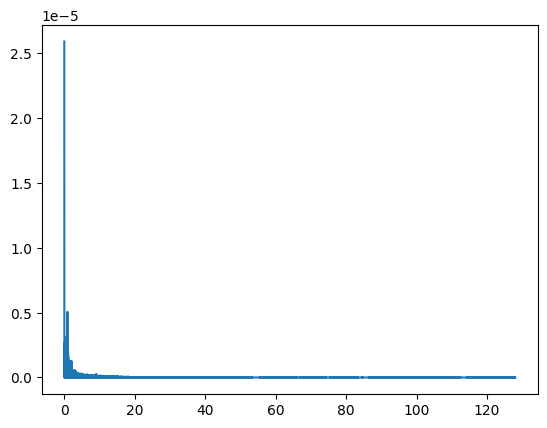

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2165-nsrr.xml
2165 Total: 164 samples | data length: 33204 (array([2, 3, 4]), array([  7, 106,  51]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2165.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2165.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12901887  =      0.000 ... 50397.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 12901888)
12901888


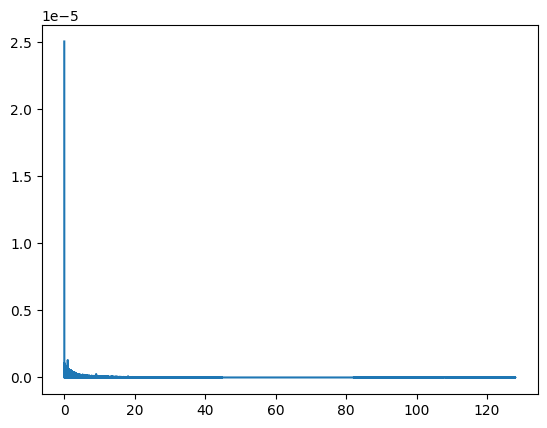

  0%|          | 0/1680 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2167-nsrr.xml
2167 Total: 364 samples | data length: 34922 (array([3, 4]), array([177, 187]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2167.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2167.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11519743  =      0.000 ... 44998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11519744)
11519744


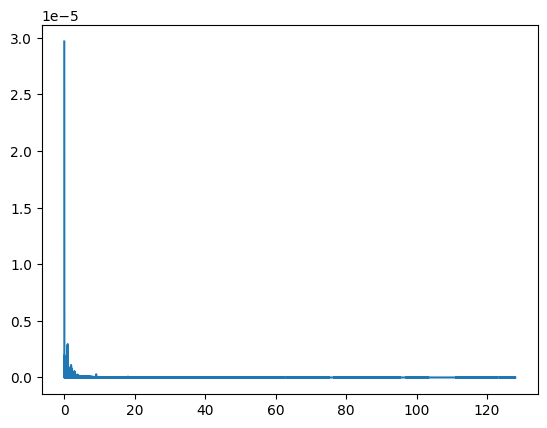

  0%|          | 0/1500 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2175-nsrr.xml
2175 Total: 100 samples | data length: 36519 (array([1, 2, 3, 4]), array([ 1,  6, 55, 38]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2175.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2175.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058687  =      0.000 ... 43197.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058688)
11058688


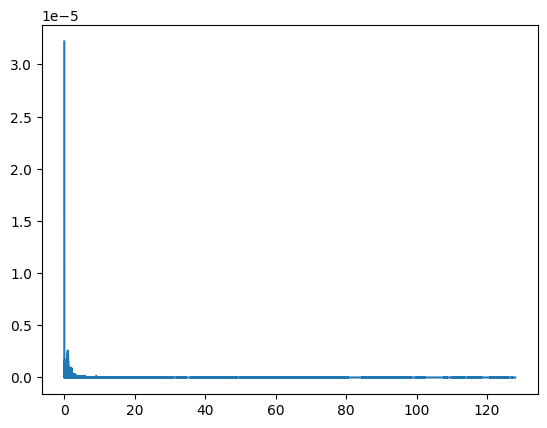

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2212-nsrr.xml
2212 Total: 196 samples | data length: 30059 (array([2, 3, 4]), array([  1, 173,  22]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2212.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2212.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


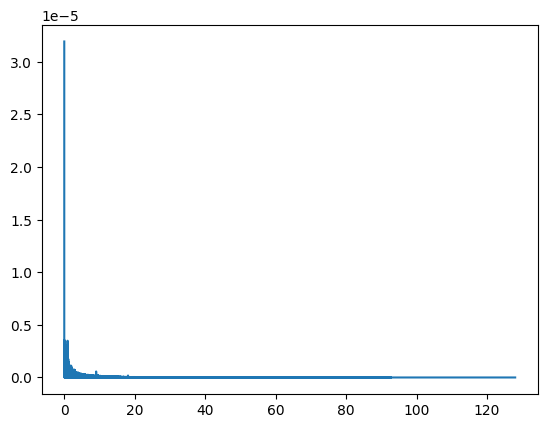

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2214-nsrr.xml
2214 Total: 232 samples | data length: 33628 (array([3, 4]), array([130, 102]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2214.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2214.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


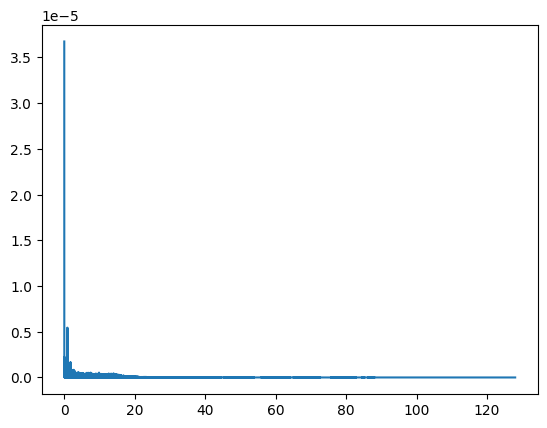

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2227-nsrr.xml
2227 Total: 208 samples | data length: 31929 (array([1, 2, 3, 4]), array([  1,  11, 139,  57]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2227.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2227.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215999  =      0.000 ... 35999.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9216000)
9216000


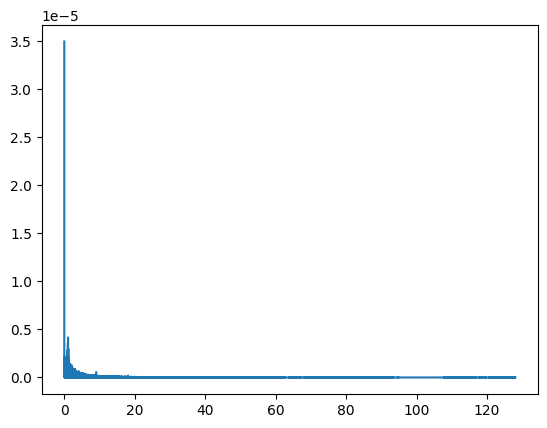

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2243-nsrr.xml
2243 Total: 200 samples | data length: 28517 (array([1, 2, 3, 4]), array([14, 16, 91, 79]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2243.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2243.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


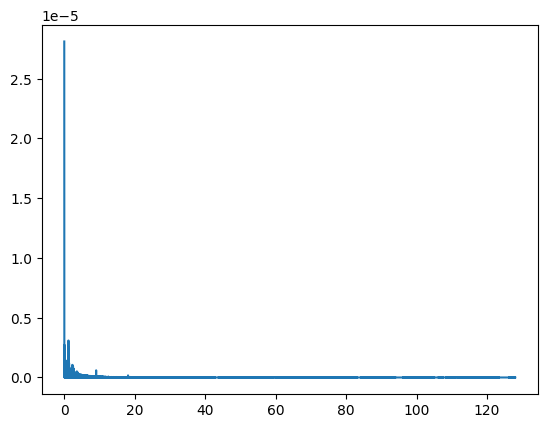

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2274-nsrr.xml
2274 Total: 62 samples | data length: 28968 (array([1, 2, 3, 4]), array([ 4, 10, 29, 19]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2274.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2274.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


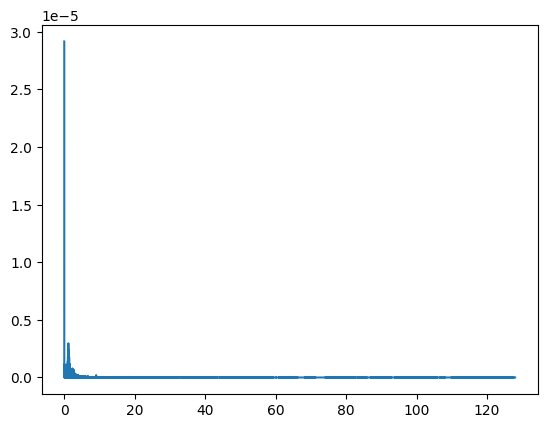

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2279-nsrr.xml
2279 Total: 68 samples | data length: 32363 (array([1, 2, 3, 4]), array([ 3,  1, 37, 27]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2279.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2279.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


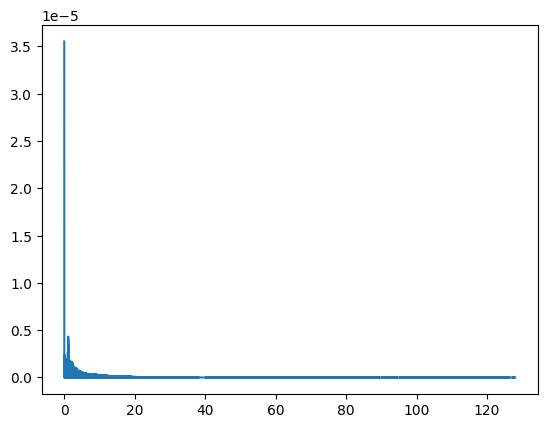

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2297-nsrr.xml
2297 Total: 130 samples | data length: 31561 (array([2, 3, 4]), array([14, 65, 51]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2297.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2297.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215999  =      0.000 ... 35999.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9216000)
9216000


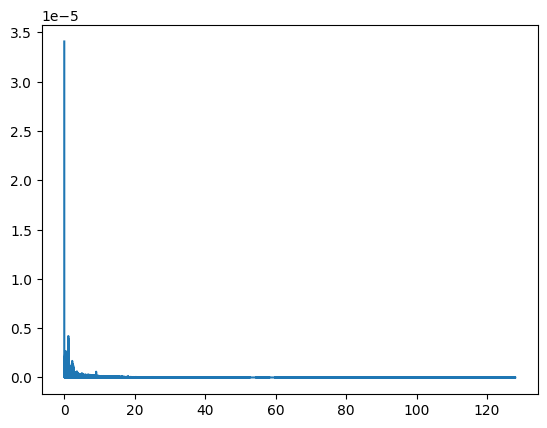

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2299-nsrr.xml
2299 Total: 393 samples | data length: 32286 (array([2, 3, 4]), array([  3, 334,  56]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2299.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2299.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


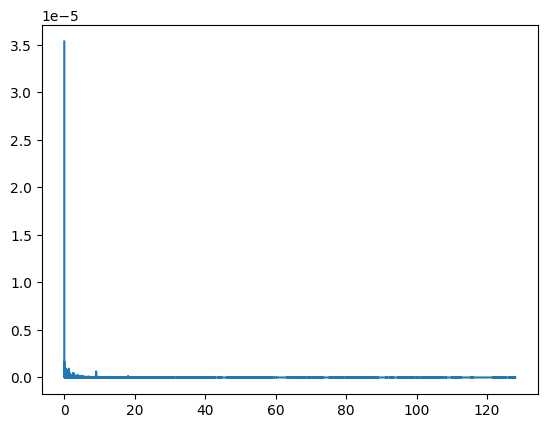

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2368-nsrr.xml
2368 Total: 178 samples | data length: 27796 (array([3, 4]), array([165,  13]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2368.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2368.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


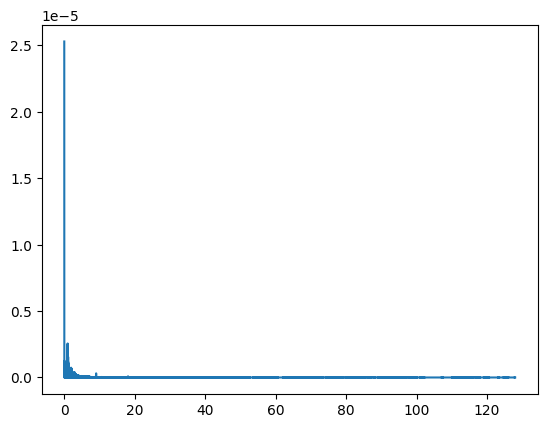

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2388-nsrr.xml
2388 Total: 83 samples | data length: 31253 (array([1, 3, 4]), array([ 1, 76,  6]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2388.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2388.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137599  =      0.000 ... 39599.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137600)
10137600


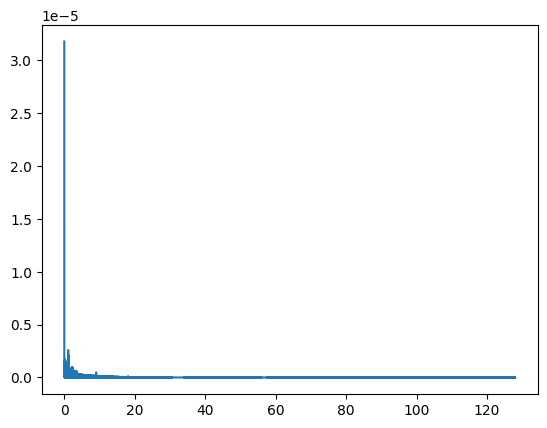

  0%|          | 0/1321 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2416-nsrr.xml
2416 Total: 102 samples | data length: 28130 (array([2, 3, 4]), array([10, 66, 26]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2416.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2416.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Aux_AC', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


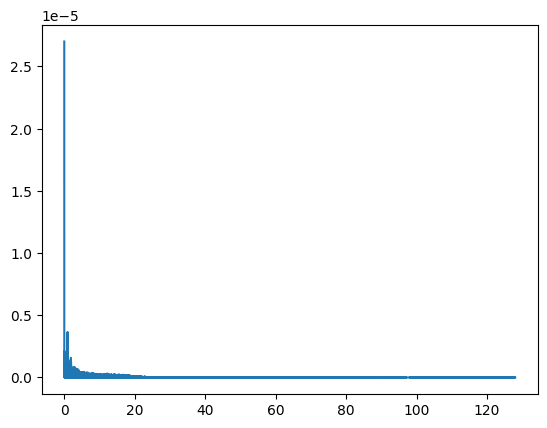

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2429-nsrr.xml
2429 Total: 281 samples | data length: 37528 (array([2, 3, 4]), array([ 21, 219,  41]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2429.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2429.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10598143  =      0.000 ... 41398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10598144)
10598144


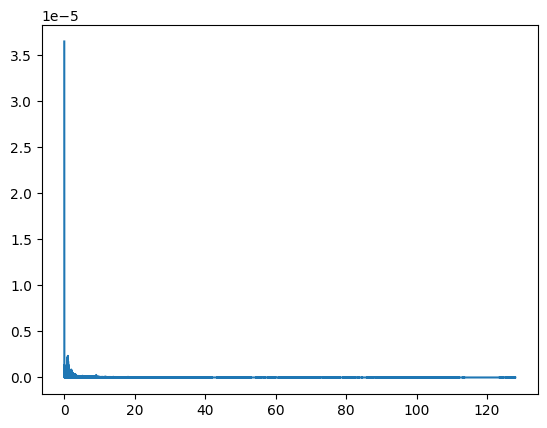

  0%|          | 0/1380 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2441-nsrr.xml
2441 Total: 252 samples | data length: 35615 (array([3, 4]), array([ 75, 177]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2441.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2441.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


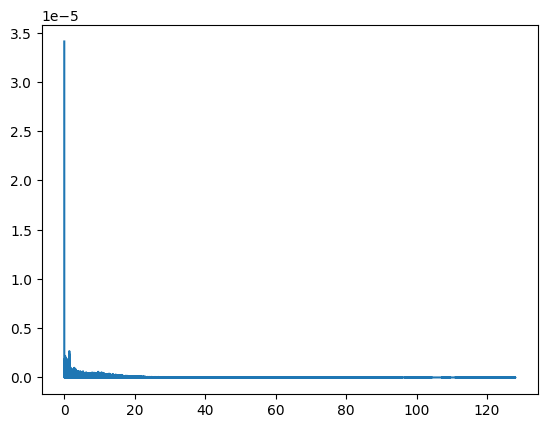

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2463-nsrr.xml
2463 Total: 215 samples | data length: 41322 (array([2, 3, 4]), array([  3, 147,  65]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2463.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2463.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


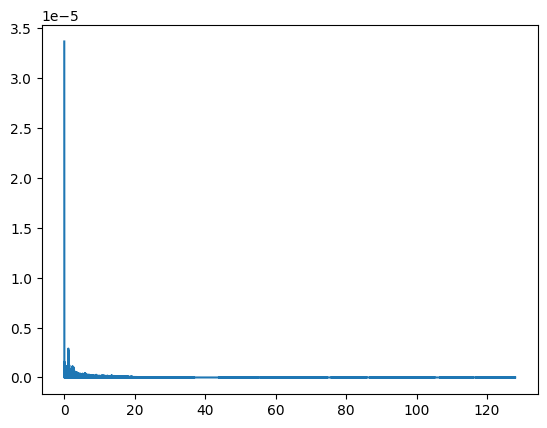

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2468-nsrr.xml
2468 Total: 220 samples | data length: 26620 (array([1, 2, 3, 4]), array([  2,   1, 170,  47]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2468.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2468.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9921023  =      0.000 ... 38753.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9921024)
9921024


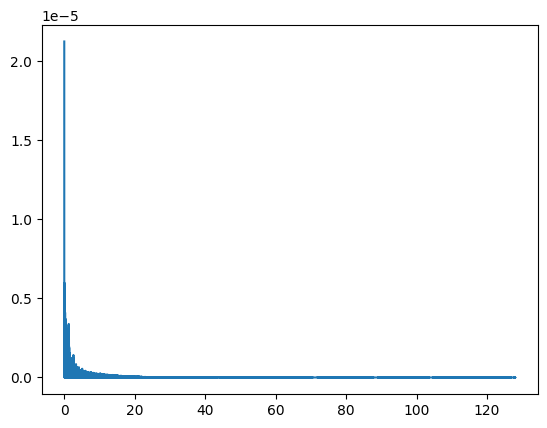

  0%|          | 0/1292 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2488-nsrr.xml
2488 Total: 144 samples | data length: 28833 (array([1, 3, 4]), array([ 1, 90, 53]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2488.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2488.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215487  =      0.000 ... 35997.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215488)
9215488


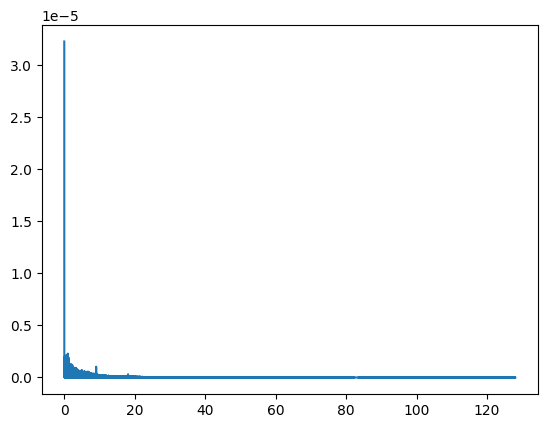

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2496-nsrr.xml
2496 Total: 120 samples | data length: 34120 (array([1, 3, 4]), array([  2, 116,   2]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2496.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2496.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


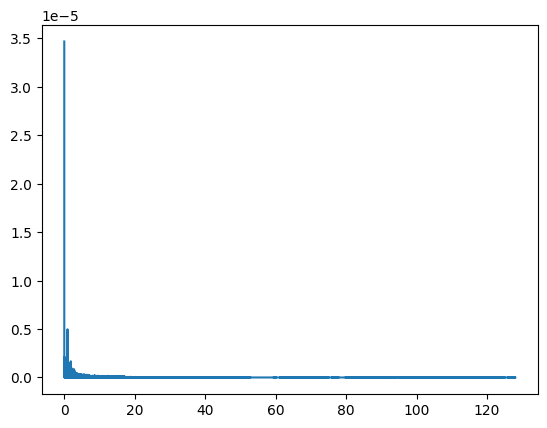

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2513-nsrr.xml
2513 Total: 224 samples | data length: 32398 (array([1, 2, 3, 4]), array([  1,  11, 120,  92]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2513.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2513.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


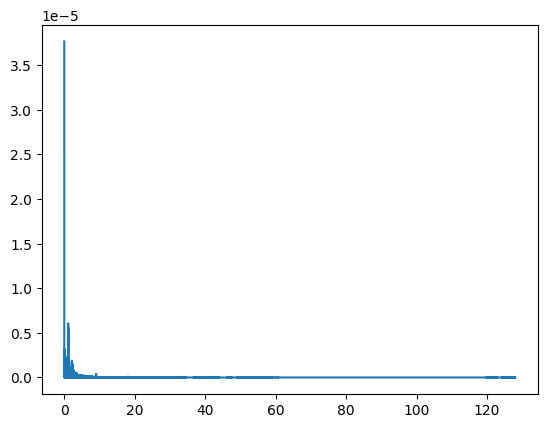

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2519-nsrr.xml
2519 Total: 165 samples | data length: 29675 (array([2, 3, 4]), array([ 17,  48, 100]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2519.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2519.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215487  =      0.000 ... 35997.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215488)
9215488


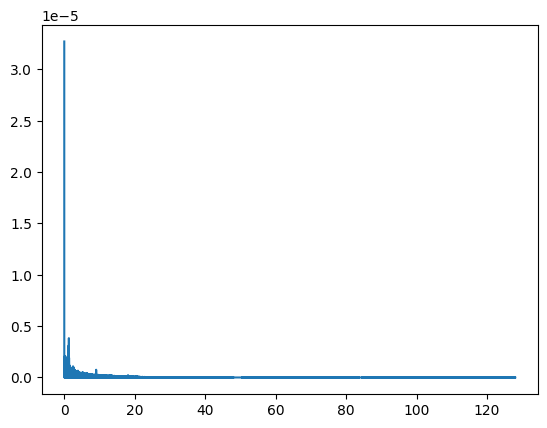

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2551-nsrr.xml
2551 Total: 111 samples | data length: 28292 (array([1, 2, 3, 4]), array([ 3, 52, 32, 24]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2551.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2551.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


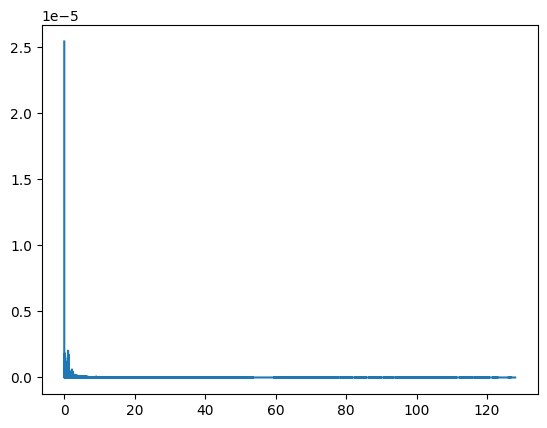

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2616-nsrr.xml
2616 Total: 153 samples | data length: 31961 (array([1, 2, 3, 4]), array([  1,   4, 126,  22]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2616.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2616.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


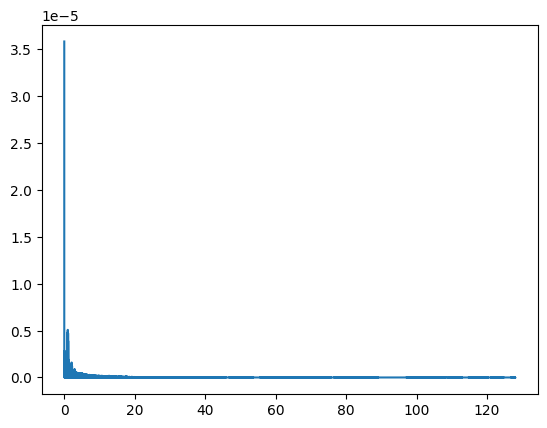

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2651-nsrr.xml
2651 Total: 451 samples | data length: 32210 (array([1, 2, 3, 4]), array([ 68, 115,  90, 178]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2651.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2651.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


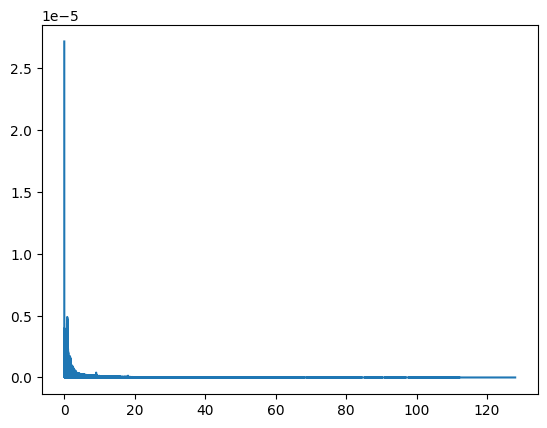

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2670-nsrr.xml
2670 Total: 47 samples | data length: 35586 (array([1, 3, 4]), array([ 3, 26, 18]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2670.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2670.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


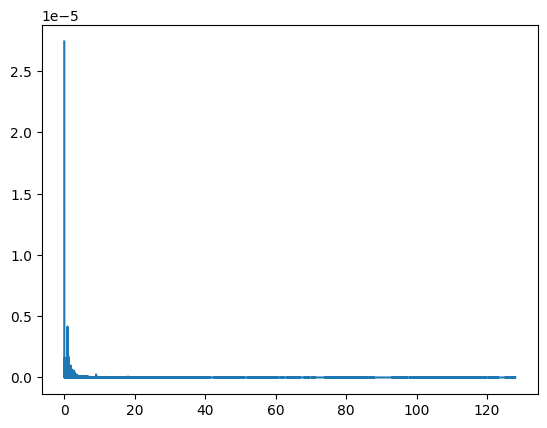

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2685-nsrr.xml
2685 Total: 230 samples | data length: 28161 (array([1, 2, 3, 4]), array([ 2, 55, 96, 77]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2685.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2685.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


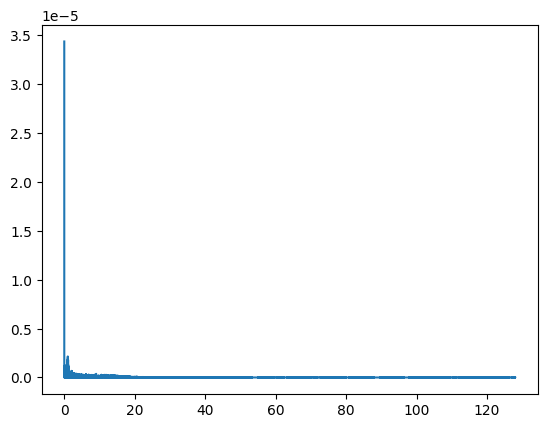

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2696-nsrr.xml
2696 Total: 47 samples | data length: 29427 (array([3, 4]), array([33, 14]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2696.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2696.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


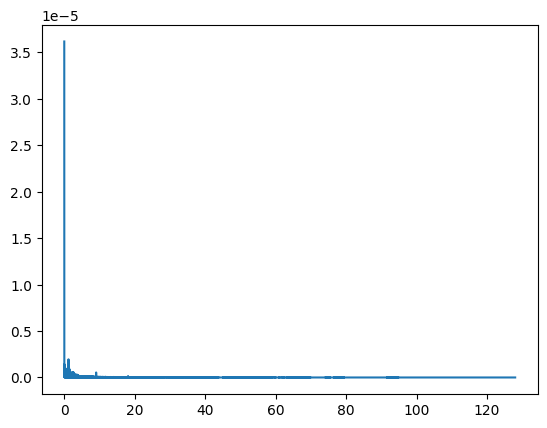

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2750-nsrr.xml
2750 Total: 269 samples | data length: 34048 (array([1, 2, 3, 4]), array([  3,  13, 182,  71]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2750.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2750.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10598143  =      0.000 ... 41398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10598144)
10598144


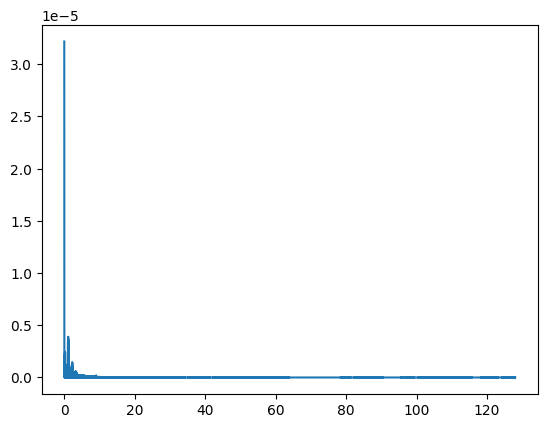

  0%|          | 0/1380 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2757-nsrr.xml
2757 Total: 395 samples | data length: 35989 (array([2, 3, 4]), array([  2, 351,  42]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2757.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2757.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


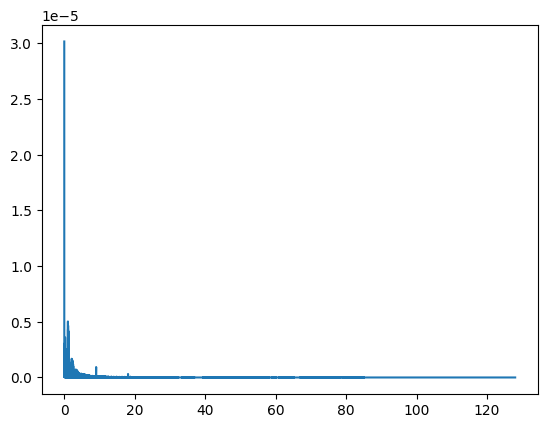

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2798-nsrr.xml
2798 Total: 254 samples | data length: 33025 (array([1, 2, 3, 4]), array([ 19,   2, 172,  61]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2798.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2798.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


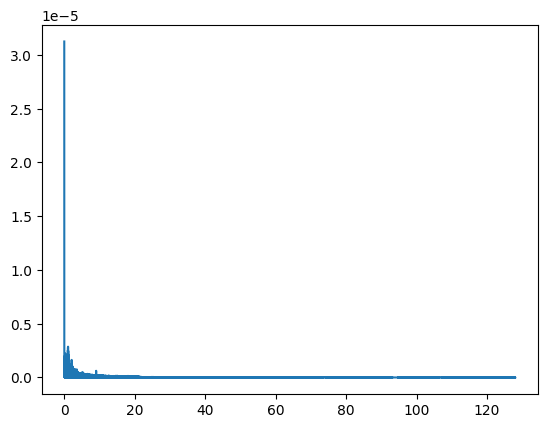

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2800-nsrr.xml
2800 Total: 289 samples | data length: 36867 (array([1, 2, 3, 4]), array([  1, 117,  54, 117]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2800.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2800.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


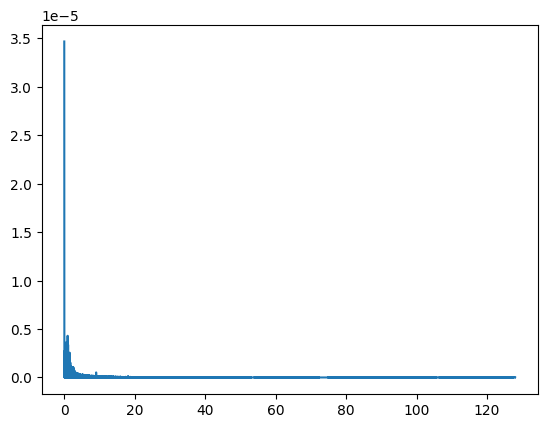

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2811-nsrr.xml
2811 Total: 130 samples | data length: 38494 (array([2, 3, 4]), array([ 3, 91, 36]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2811.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2811.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


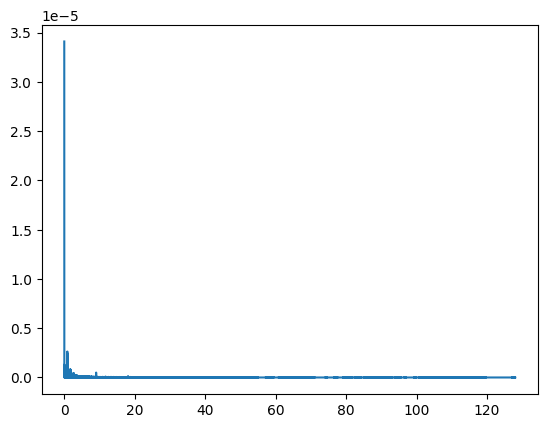

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2821-nsrr.xml
2821 Total: 112 samples | data length: 27436 (array([2, 3, 4]), array([12, 41, 59]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2821.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2821.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058687  =      0.000 ... 43197.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058688)
11058688


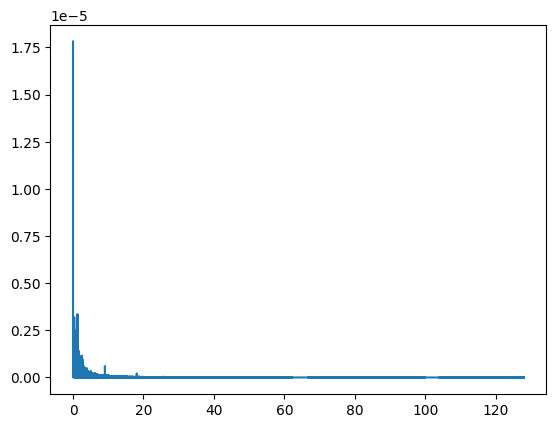

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2876-nsrr.xml
2876 Total: 203 samples | data length: 25270 (array([2, 3, 4]), array([  6, 156,  41]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2876.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2876.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


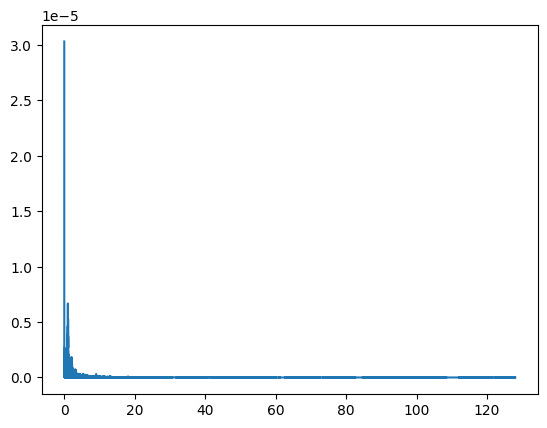

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2880-nsrr.xml
2880 Total: 103 samples | data length: 30845 (array([2, 3, 4]), array([ 2, 59, 42]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2880.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2880.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


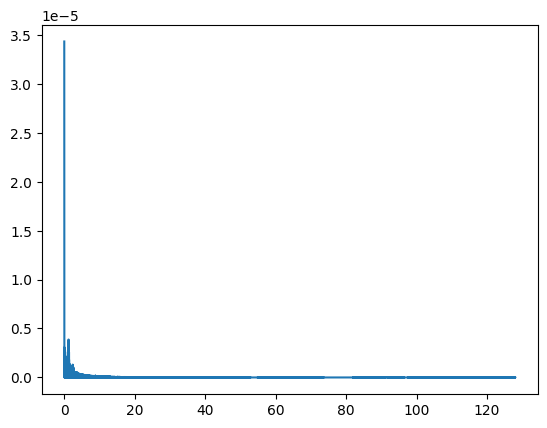

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2911-nsrr.xml
2911 Total: 156 samples | data length: 34945 (array([2, 3, 4]), array([ 1, 71, 84]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2911.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2911.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


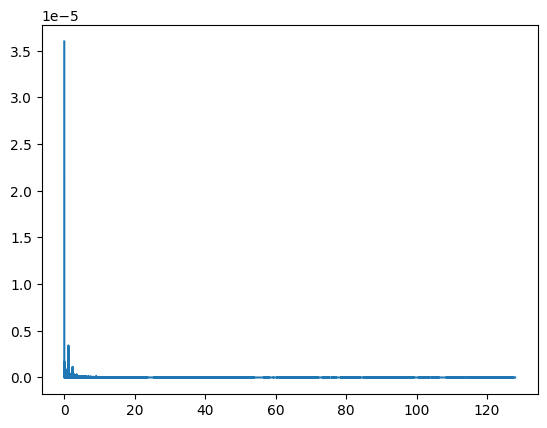

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2934-nsrr.xml
2934 Total: 365 samples | data length: 32022 (array([1, 2, 3, 4]), array([ 31, 119,  48, 167]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2934.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2934.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Aux_AC', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


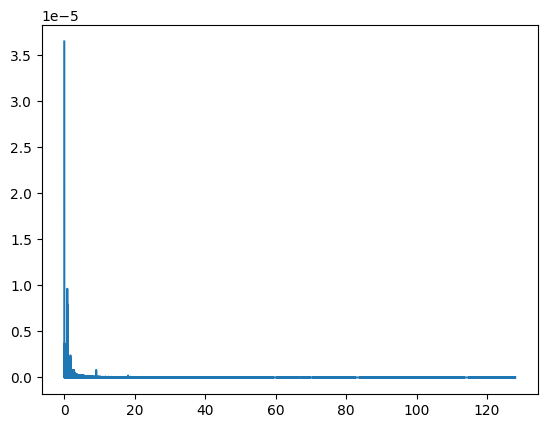

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-2941-nsrr.xml
2941 Total: 49 samples | data length: 28802 (array([2, 3, 4]), array([ 8, 33,  8]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2941.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-2941.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8754687  =      0.000 ... 34197.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8754688)
8754688


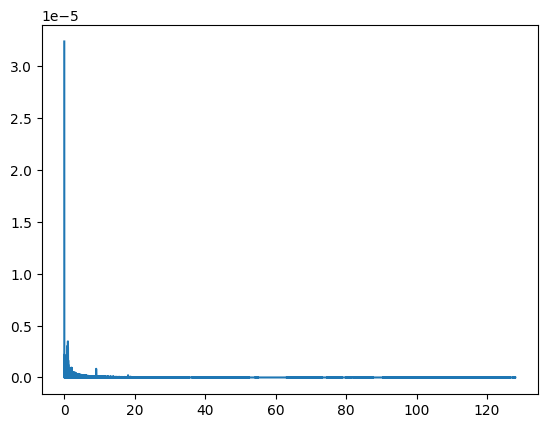

  0%|          | 0/1140 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3013-nsrr.xml
3013 Total: 380 samples | data length: 29036 (array([1, 2, 3, 4]), array([  1,  11, 226, 142]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3013.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


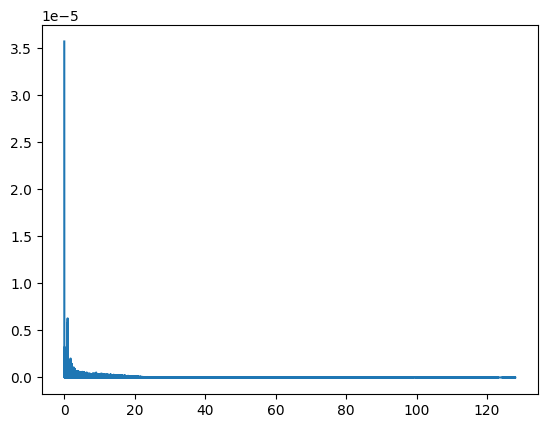

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3025-nsrr.xml
3025 Total: 416 samples | data length: 28691 (array([1, 2, 3, 4]), array([ 10,  58, 158, 190]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3025.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215487  =      0.000 ... 35997.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215488)
9215488


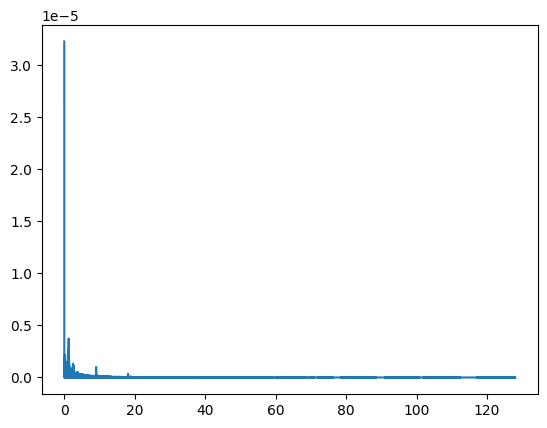

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3102-nsrr.xml
3102 Total: 86 samples | data length: 30303 (array([2, 3, 4]), array([ 1, 58, 27]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3102.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3102.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


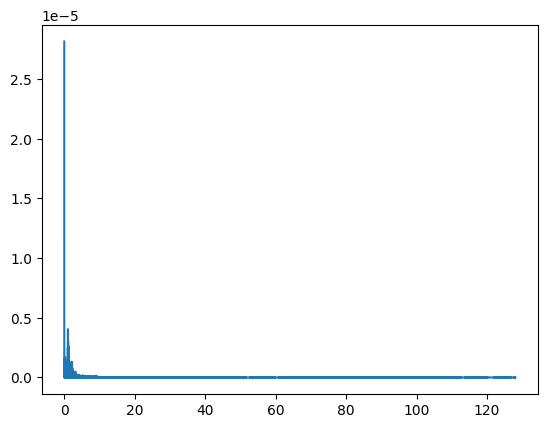

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3155-nsrr.xml
3155 Total: 198 samples | data length: 33410 (array([2, 3, 4]), array([48, 66, 84]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3155.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3155.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11980543  =      0.000 ... 46798.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11980544)
11980544


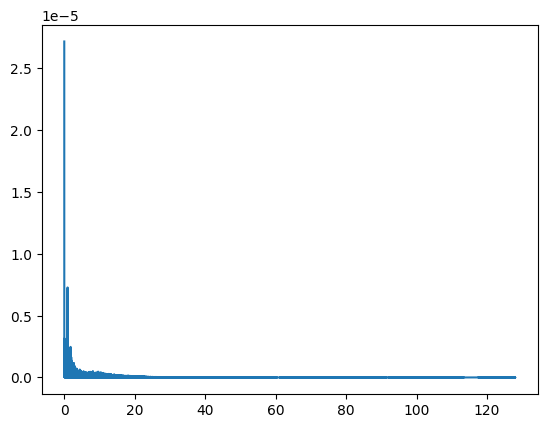

  0%|          | 0/1560 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3156-nsrr.xml
3156 Total: 254 samples | data length: 31427 (array([1, 2, 3, 4]), array([  4,  46,  97, 107]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3156.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3156.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294399  =      0.000 ... 32399.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294400)
8294400


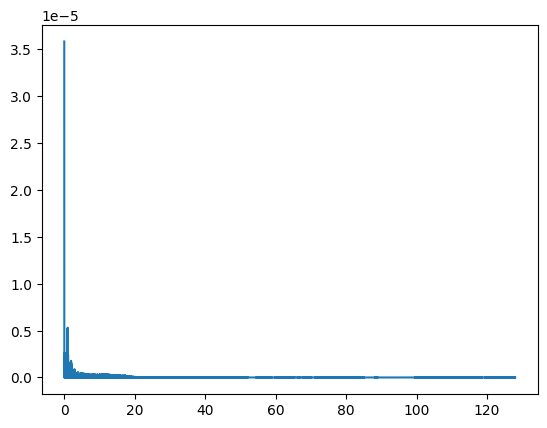

  0%|          | 0/1081 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3168-nsrr.xml
3168 Total: 263 samples | data length: 22173 (array([2, 3, 4]), array([ 31, 177,  55]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3168.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3168.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


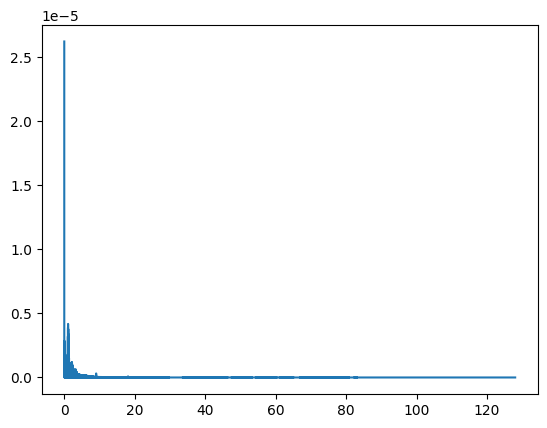

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3190-nsrr.xml
3190 Total: 412 samples | data length: 33727 (array([2, 3, 4]), array([171,  93, 148]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3190.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3190.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


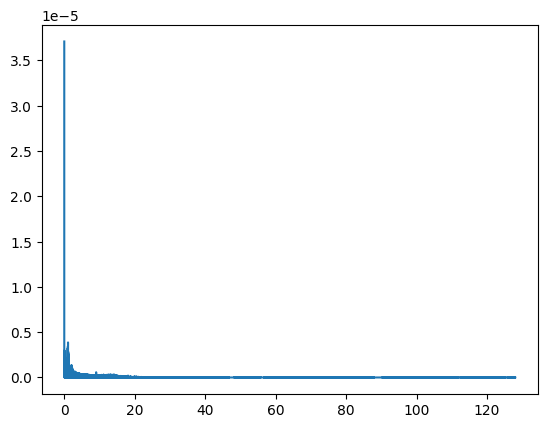

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3193-nsrr.xml
3193 Total: 140 samples | data length: 28322 (array([2, 3, 4]), array([ 3, 93, 44]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3193.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3193.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8354303  =      0.000 ... 32633.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8354304)
8354304


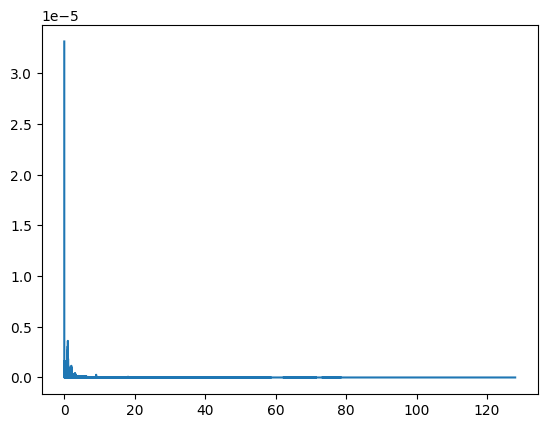

  0%|          | 0/1088 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3290-nsrr.xml
3290 Total: 292 samples | data length: 30465 (array([2, 3, 4]), array([ 24,  82, 186]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3290.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3290.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215999  =      0.000 ... 35999.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9216000)
9216000


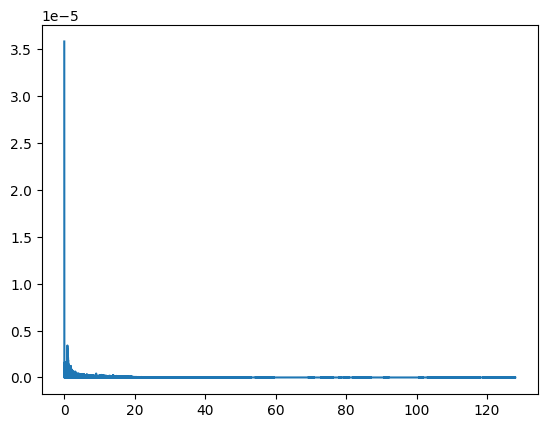

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3297-nsrr.xml
3297 Total: 362 samples | data length: 31850 (array([2, 3, 4]), array([ 69, 168, 125]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3297.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3297.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9676543  =      0.000 ... 37798.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9676544)
9676544


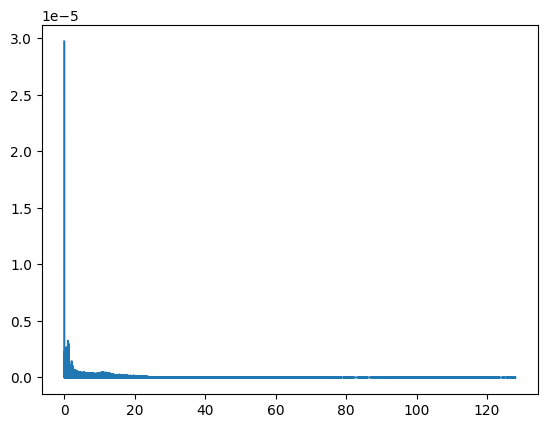

  0%|          | 0/1260 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3303-nsrr.xml
3303 Total: 95 samples | data length: 30005 (array([2, 3, 4]), array([ 2, 90,  3]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3303.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3303.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


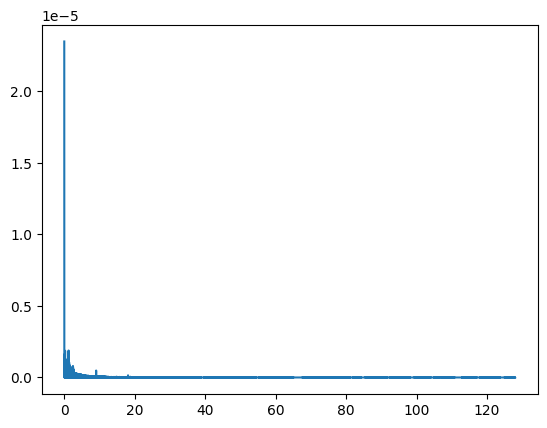

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3336-nsrr.xml
3336 Total: 72 samples | data length: 28450 (array([2, 3, 4]), array([ 4, 41, 27]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3336.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3336.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8754687  =      0.000 ... 34197.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8754688)
8754688


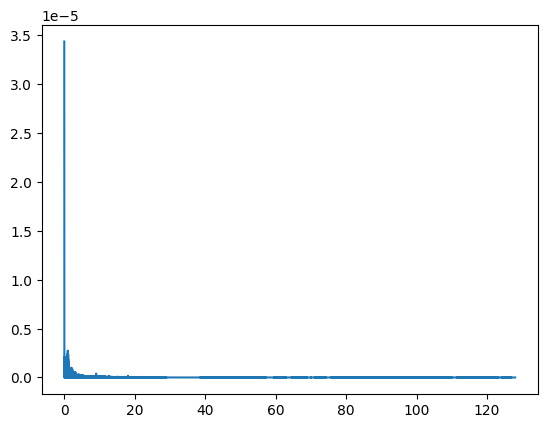

  0%|          | 0/1140 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3375-nsrr.xml
3375 Total: 180 samples | data length: 29237 (array([2, 3, 4]), array([ 14, 130,  36]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3375.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3375.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


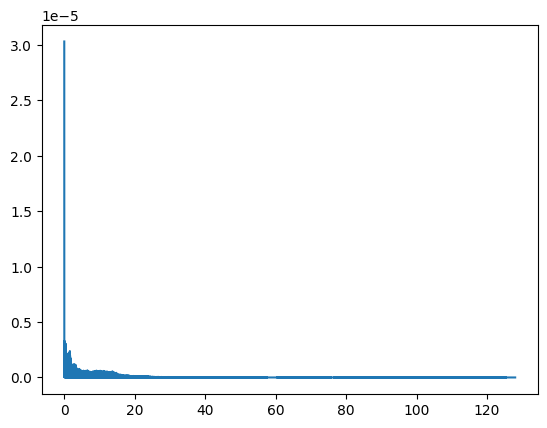

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3387-nsrr.xml
3387 Total: 462 samples | data length: 33245 (array([3, 4]), array([196, 266]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3387.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3387.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


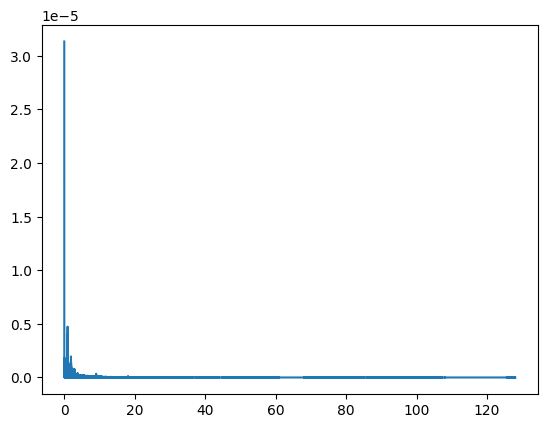

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3407-nsrr.xml
3407 Total: 436 samples | data length: 30114 (array([1, 2, 3, 4]), array([ 11, 117,  12, 296]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3407.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3407.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


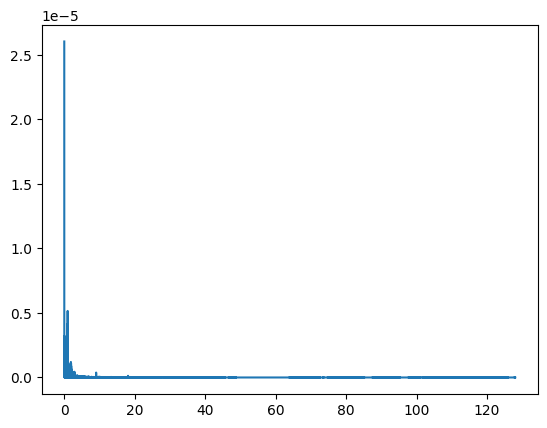

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3431-nsrr.xml
3431 Total: 31 samples | data length: 25380 (array([1, 2, 3, 4]), array([ 1,  1, 21,  8]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3431.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3431.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


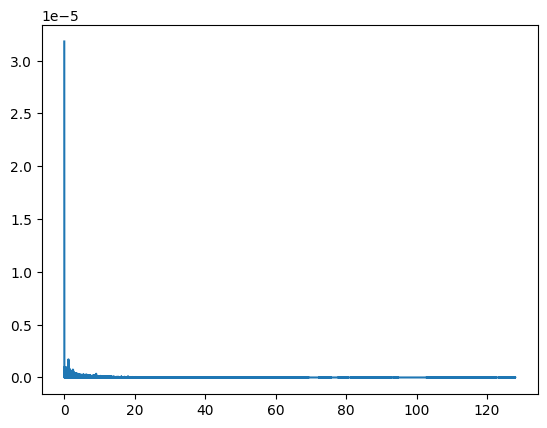

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3439-nsrr.xml
3439 Total: 322 samples | data length: 38115 (array([1, 2, 3, 4]), array([ 25, 210,  46,  41]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3439.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3439.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137599  =      0.000 ... 39599.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137600)
10137600


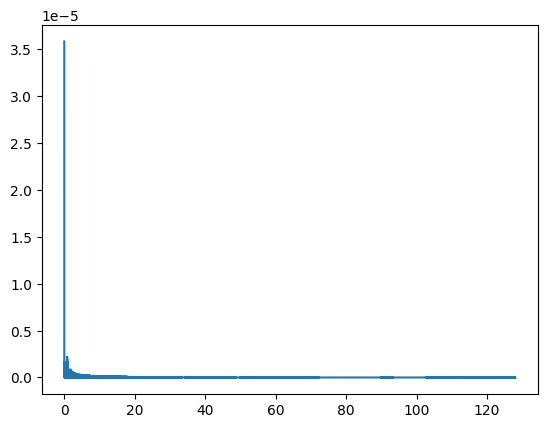

  0%|          | 0/1321 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3492-nsrr.xml
3492 Total: 253 samples | data length: 30893 (array([1, 3, 4]), array([  2, 142, 109]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3492.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3492.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


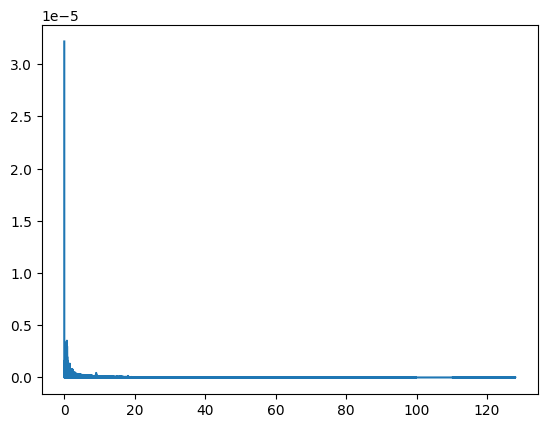

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3495-nsrr.xml
3495 Total: 80 samples | data length: 34758 (array([1, 2, 3, 4]), array([ 3,  1, 71,  5]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3495.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3495.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


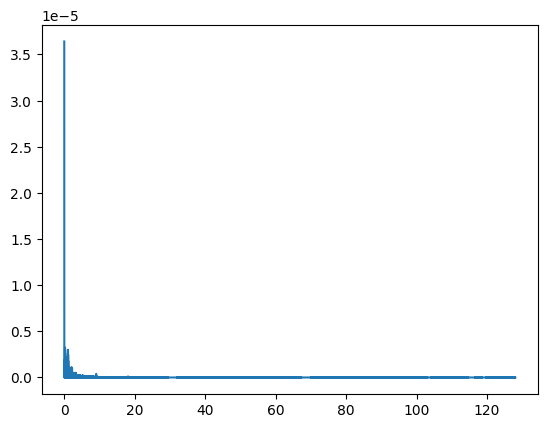

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3538-nsrr.xml
3538 Total: 58 samples | data length: 25678 (array([2, 3, 4]), array([ 3, 10, 45]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3538.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3538.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


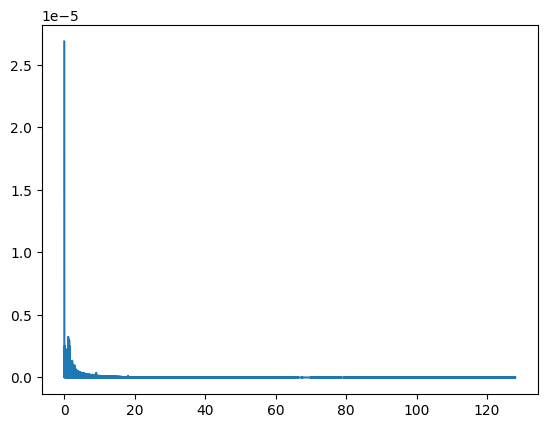

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3542-nsrr.xml
3542 Total: 210 samples | data length: 31290 (array([2, 3, 4]), array([  5, 159,  46]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3542.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3542.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


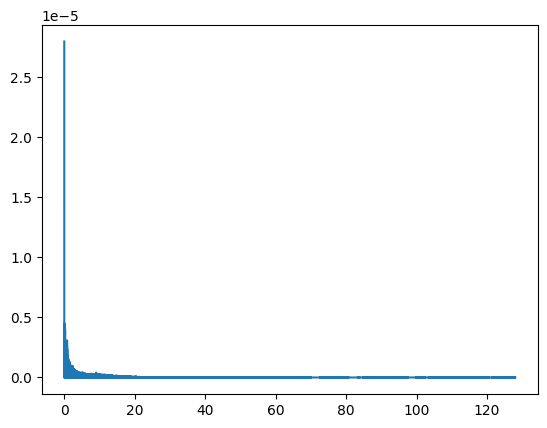

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3555-nsrr.xml
3555 Total: 334 samples | data length: 35969 (array([1, 2, 3, 4]), array([  1, 104,  98, 131]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3555.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3555.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


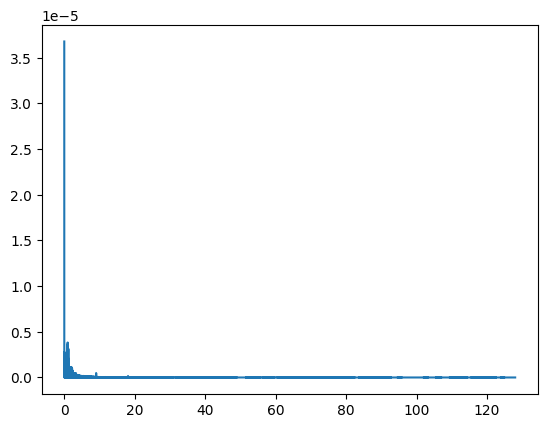

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3558-nsrr.xml
3558 Total: 124 samples | data length: 33185 (array([1, 2, 3, 4]), array([ 4, 49, 41, 30]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3558.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3558.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215999  =      0.000 ... 35999.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9216000)
9216000


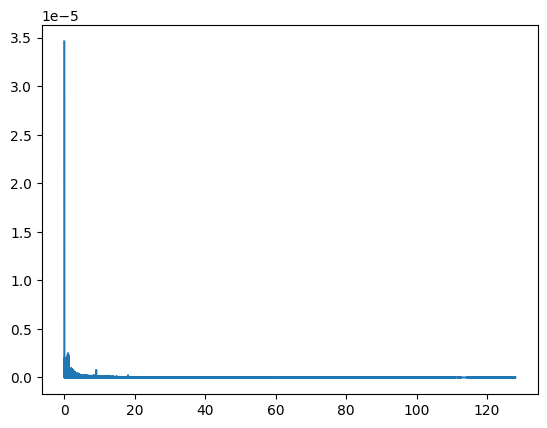

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3564-nsrr.xml
3564 Total: 287 samples | data length: 32163 (array([1, 2, 3, 4]), array([  2,   9, 269,   7]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3564.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3564.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


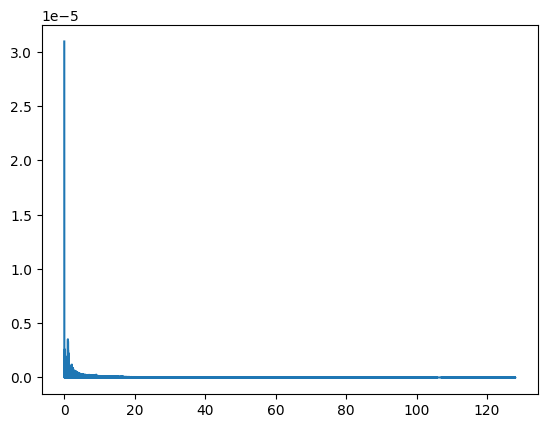

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3629-nsrr.xml
3629 Total: 115 samples | data length: 35589 (array([1, 2, 3, 4]), array([ 2,  5, 66, 42]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3629.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3629.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


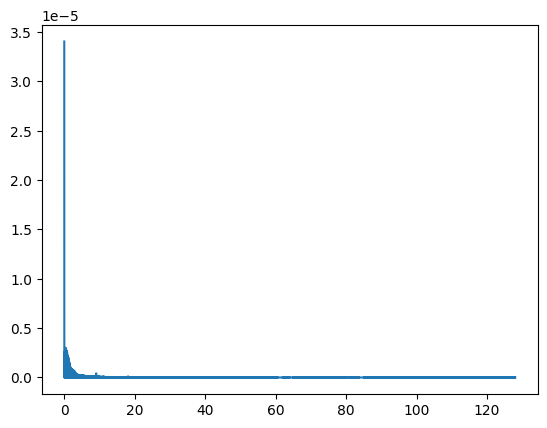

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3635-nsrr.xml
3635 Total: 160 samples | data length: 25116 (array([1, 2, 3, 4]), array([  1,   2, 124,  33]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3635.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3635.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


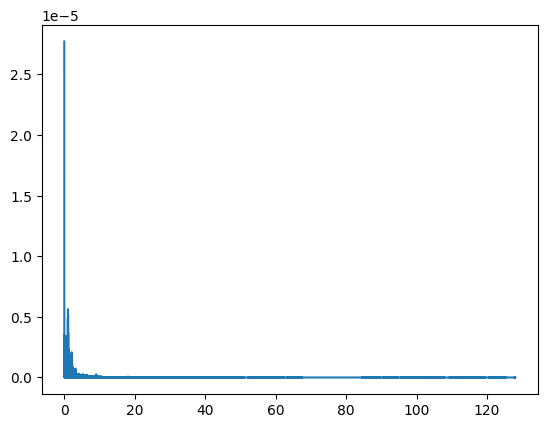

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3703-nsrr.xml
3703 Total: 165 samples | data length: 30234 (array([1, 2, 3, 4]), array([  1,  17,  42, 105]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3703.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3703.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215999  =      0.000 ... 35999.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9216000)
9216000


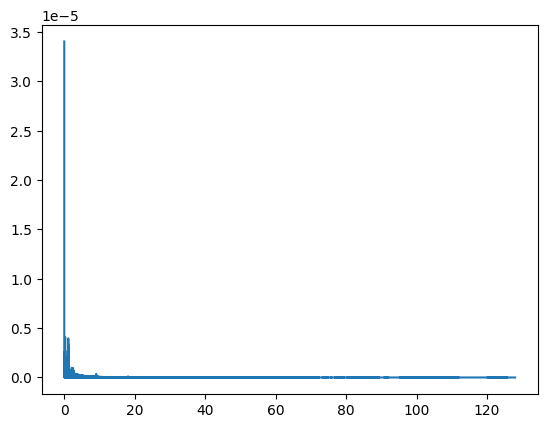

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3717-nsrr.xml
3717 Total: 25 samples | data length: 30834 (array([3, 4]), array([24,  1]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3717.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3717.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


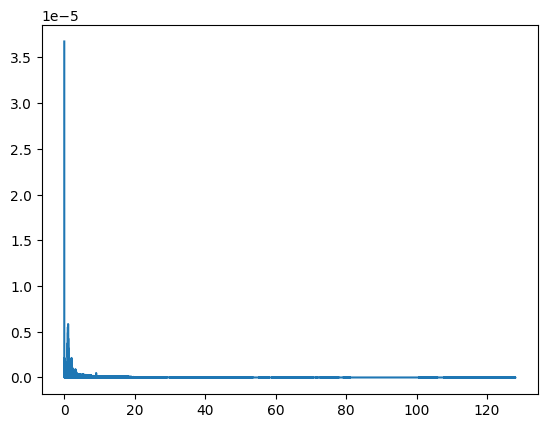

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3730-nsrr.xml
3730 Total: 387 samples | data length: 31453 (array([2, 3, 4]), array([ 25, 278,  84]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3730.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3730.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


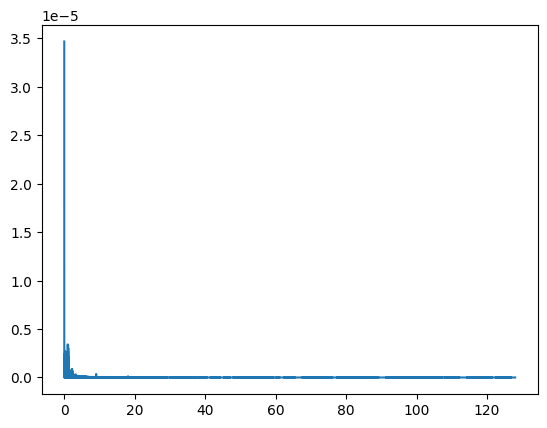

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3738-nsrr.xml
3738 Total: 185 samples | data length: 33043 (array([1, 2, 3, 4]), array([ 3,  1, 86, 95]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3738.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3738.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


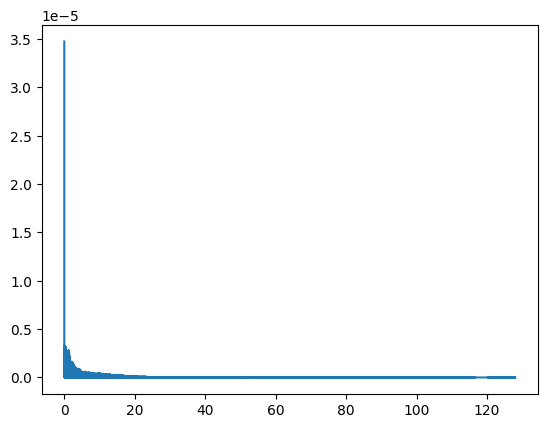

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3785-nsrr.xml
3785 Total: 129 samples | data length: 31445 (array([2, 3, 4]), array([ 8, 88, 33]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3785.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3785.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


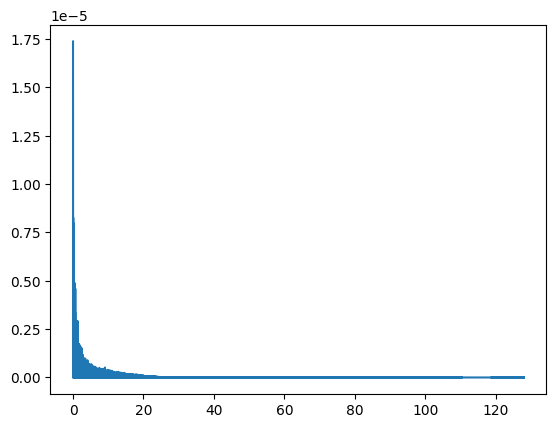

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3840-nsrr.xml
3840 Total: 124 samples | data length: 25857 (array([2, 3, 4]), array([ 1, 76, 47]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3840.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3840.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


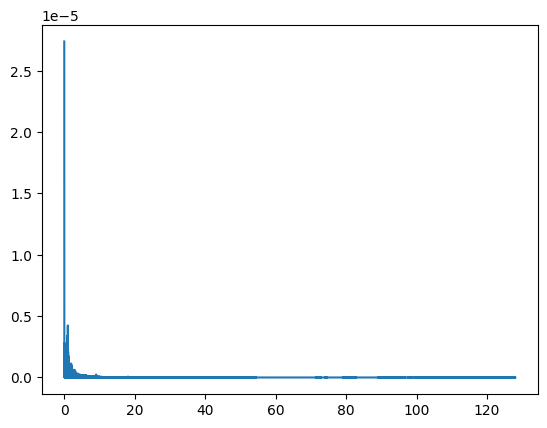

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3894-nsrr.xml
3894 Total: 130 samples | data length: 29840 (array([2, 3, 4]), array([ 7, 62, 61]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3894.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3894.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294399  =      0.000 ... 32399.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294400)
8294400


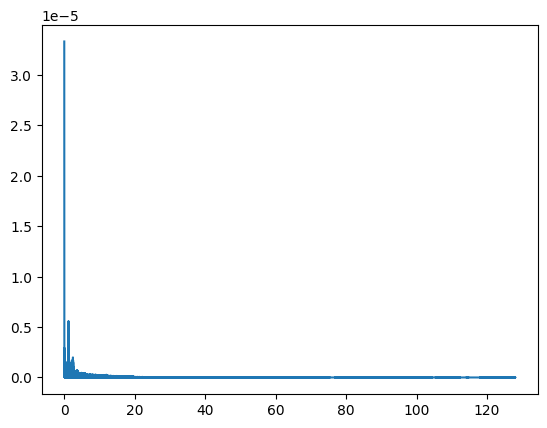

  0%|          | 0/1081 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3917-nsrr.xml
3917 Total: 174 samples | data length: 29492 (array([2, 3, 4]), array([  5, 101,  68]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3917.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3917.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


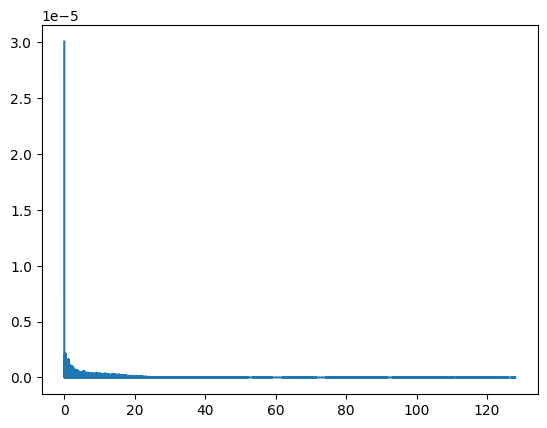

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3945-nsrr.xml
3945 Total: 127 samples | data length: 31958 (array([1, 3, 4]), array([ 1, 93, 33]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3945.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3945.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


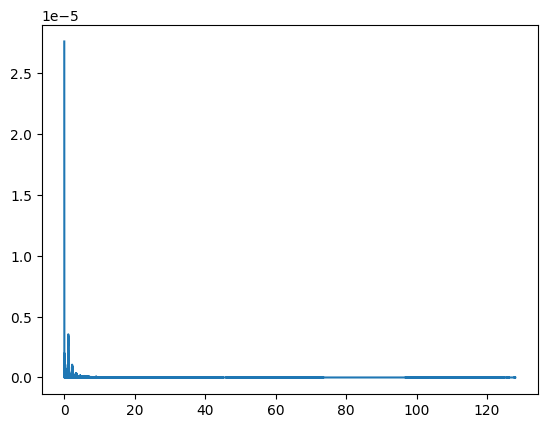

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3975-nsrr.xml
3975 Total: 137 samples | data length: 30302 (array([2, 3, 4]), array([ 3, 97, 37]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3975.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3975.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


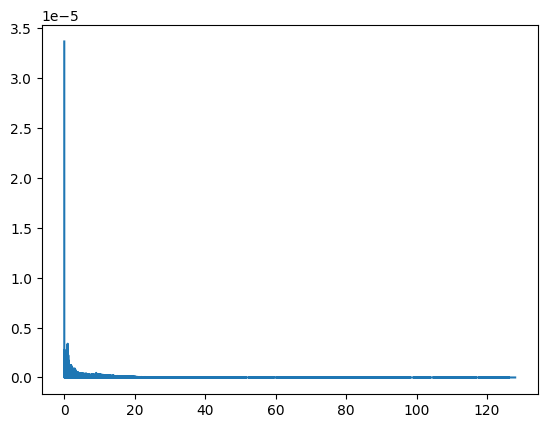

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-3980-nsrr.xml
3980 Total: 207 samples | data length: 35617 (array([1, 2, 3, 4]), array([  1,  35, 126,  45]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3980.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-3980.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10083839  =      0.000 ... 39389.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10083840)
10083840


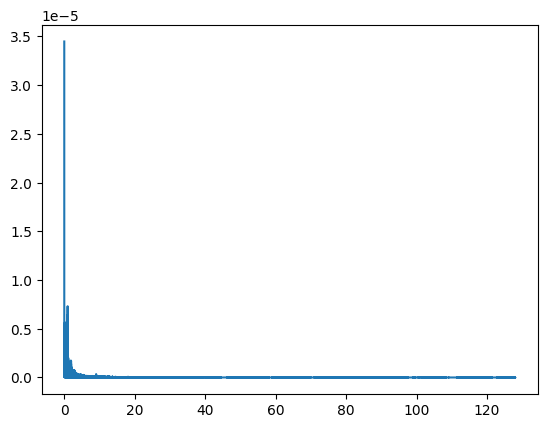

  0%|          | 0/1314 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4000-nsrr.xml
4000 Total: 254 samples | data length: 35933 (array([1, 2, 3, 4]), array([  2,  18, 114, 120]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4000.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10444799  =      0.000 ... 40799.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10444800)
10444800


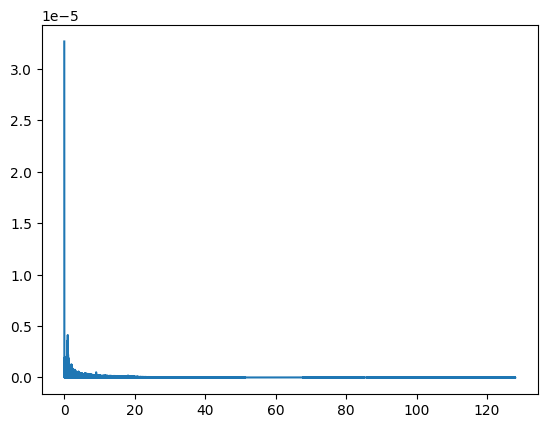

  0%|          | 0/1361 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4029-nsrr.xml
4029 Total: 214 samples | data length: 30592 (array([1, 2, 3, 4]), array([  1,   1, 159,  53]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4029.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4029.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


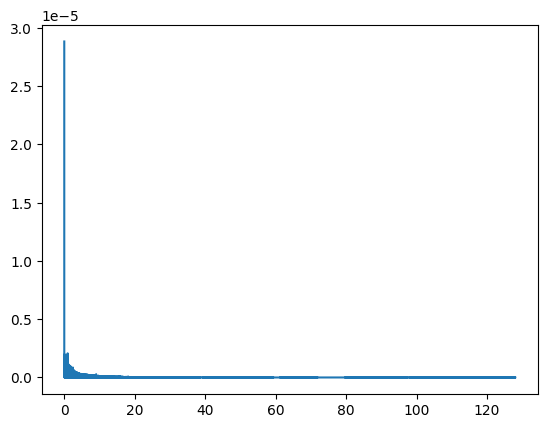

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4070-nsrr.xml
4070 Total: 79 samples | data length: 30265 (array([3, 4]), array([62, 17]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4070.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4070.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


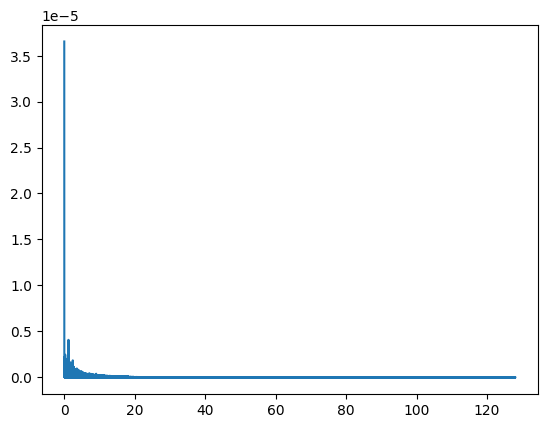

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4088-nsrr.xml
4088 Total: 338 samples | data length: 41131 (array([1, 2, 3, 4]), array([  2,   7, 211, 118]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4088.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4088.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11519743  =      0.000 ... 44998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11519744)
11519744


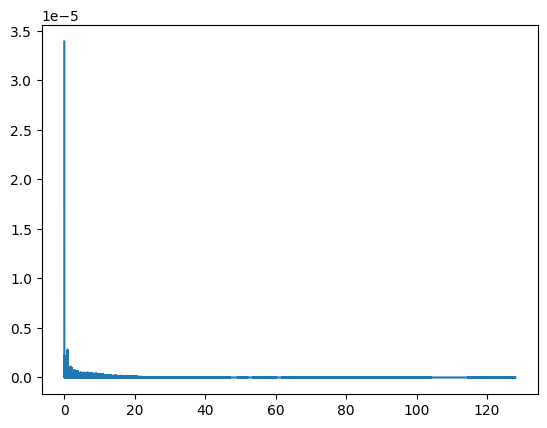

  0%|          | 0/1500 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4152-nsrr.xml
4152 Total: 27 samples | data length: 24881 (array([2, 3, 4]), array([ 2, 17,  8]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4152.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4152.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


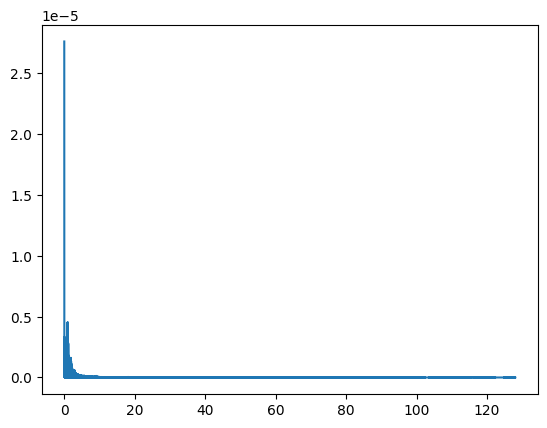

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4170-nsrr.xml
4170 Total: 250 samples | data length: 25677 (array([1, 2, 3, 4]), array([  4,   4, 121, 121]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4170.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4170.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


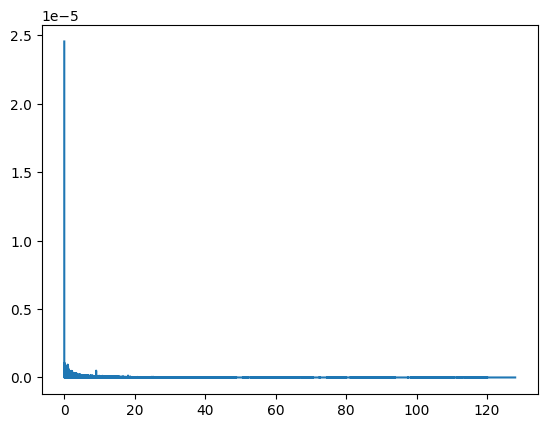

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4240-nsrr.xml
4240 Total: 241 samples | data length: 35921 (array([2, 3, 4]), array([  1, 136, 104]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4240.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4240.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10598399  =      0.000 ... 41399.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10598400)
10598400


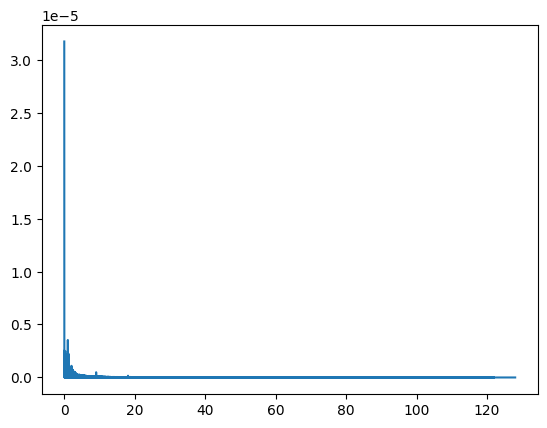

  0%|          | 0/1381 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4254-nsrr.xml
4254 Total: 321 samples | data length: 29860 (array([1, 2, 3, 4]), array([  1,  22, 228,  70]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4254.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4254.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


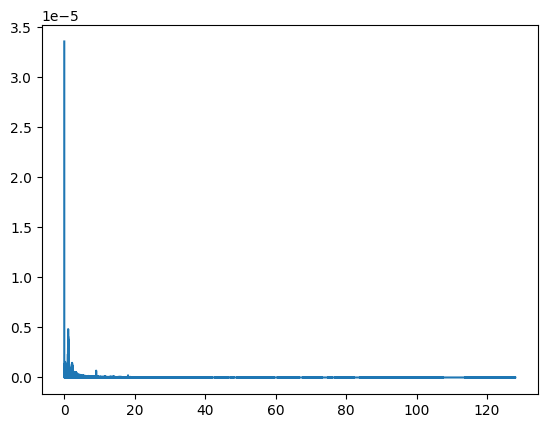

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4294-nsrr.xml
4294 Total: 100 samples | data length: 29923 (array([3, 4]), array([84, 16]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4294.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4294.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


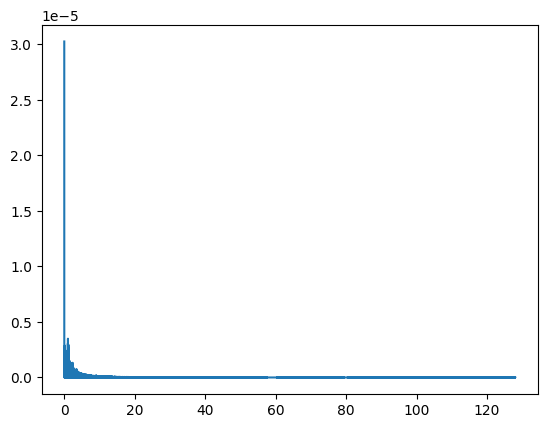

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4295-nsrr.xml
4295 Total: 310 samples | data length: 24438 (array([1, 2, 3, 4]), array([ 61, 148,   8,  93]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4295.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4295.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9676543  =      0.000 ... 37798.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9676544)
9676544


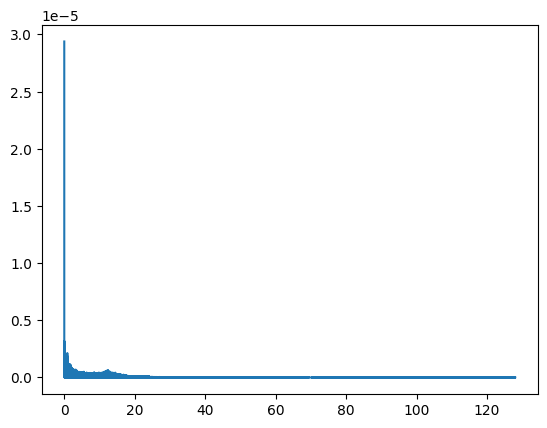

  0%|          | 0/1260 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4305-nsrr.xml
4305 Total: 194 samples | data length: 30049 (array([1, 2, 3, 4]), array([ 1, 12, 88, 93]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4305.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4305.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058687  =      0.000 ... 43197.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058688)
11058688


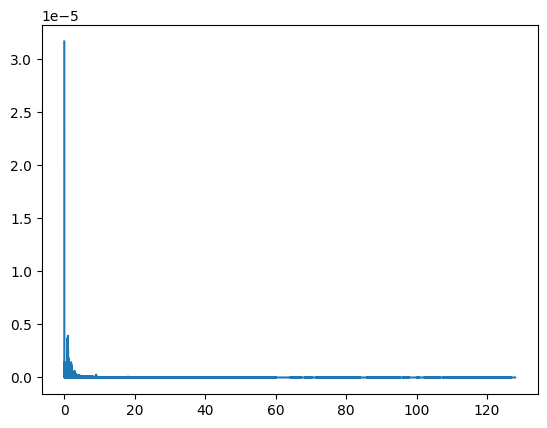

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4308-nsrr.xml
4308 Total: 173 samples | data length: 36872 (array([3, 4]), array([116,  57]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4308.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4308.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


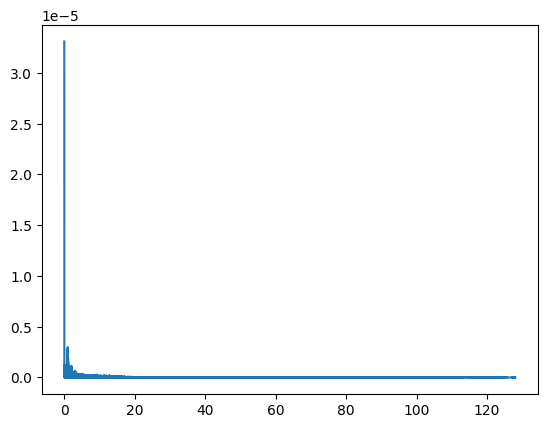

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4318-nsrr.xml
4318 Total: 73 samples | data length: 28691 (array([3, 4]), array([61, 12]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4318.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4318.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


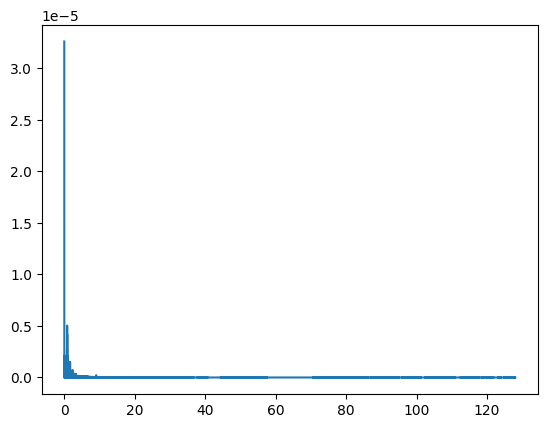

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4379-nsrr.xml
4379 Total: 162 samples | data length: 32525 (array([2, 3, 4]), array([10, 88, 64]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4379.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4379.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


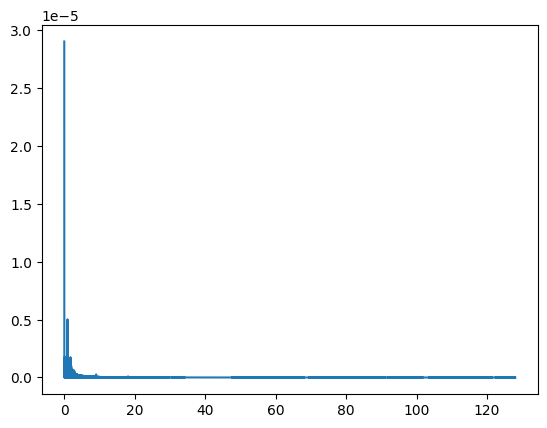

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4415-nsrr.xml
4415 Total: 144 samples | data length: 34503 (array([2, 3, 4]), array([ 2, 96, 46]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4415.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4415.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


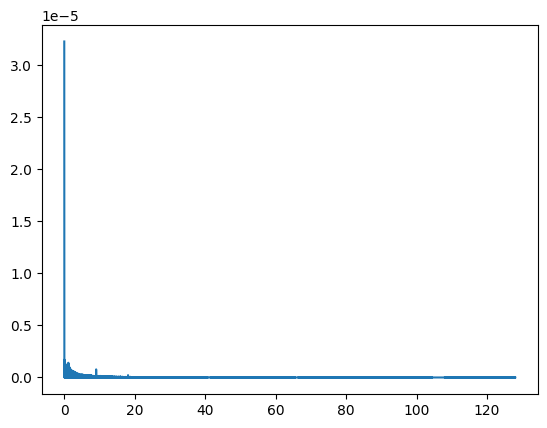

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4432-nsrr.xml
4432 Total: 44 samples | data length: 28826 (array([1, 3]), array([ 5, 39]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4432.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4432.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


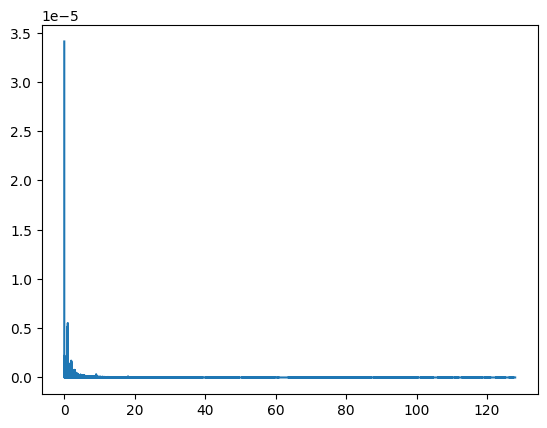

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4436-nsrr.xml
4436 Total: 78 samples | data length: 34071 (array([3, 4]), array([64, 14]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4436.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4436.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


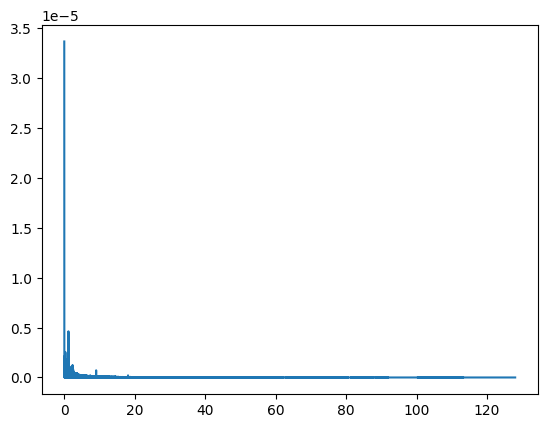

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4460-nsrr.xml
4460 Total: 217 samples | data length: 30566 (array([2, 3, 4]), array([  7, 205,   5]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4460.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4460.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137599  =      0.000 ... 39599.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137600)
10137600


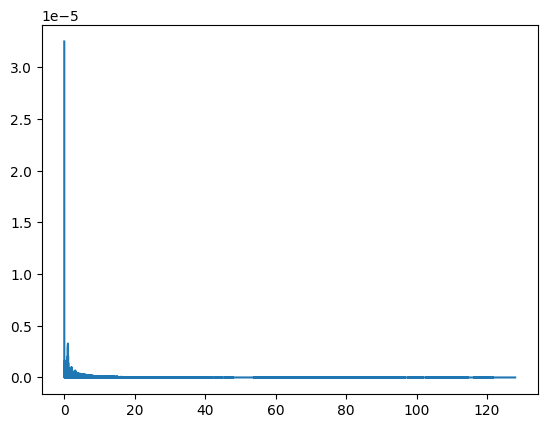

  0%|          | 0/1321 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4461-nsrr.xml
4461 Total: 116 samples | data length: 31629 (array([1, 2, 3, 4]), array([ 1,  3, 80, 32]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4461.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4461.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137599  =      0.000 ... 39599.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137600)
10137600


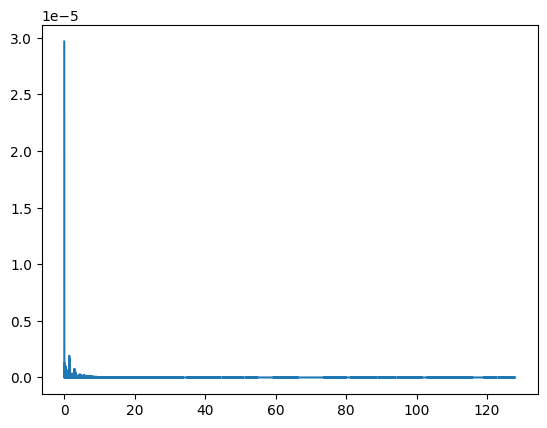

  0%|          | 0/1321 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4479-nsrr.xml
4479 Total: 132 samples | data length: 30096 (array([2, 3, 4]), array([25, 36, 71]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4479.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4479.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


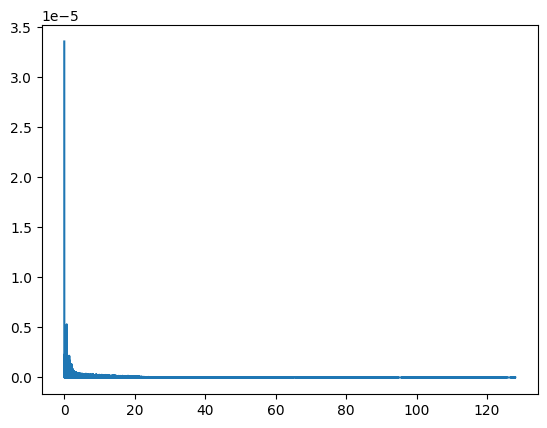

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4496-nsrr.xml
4496 Total: 236 samples | data length: 28482 (array([1, 2, 3, 4]), array([  3,  39, 111,  83]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4496.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4496.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215999  =      0.000 ... 35999.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9216000)
9216000


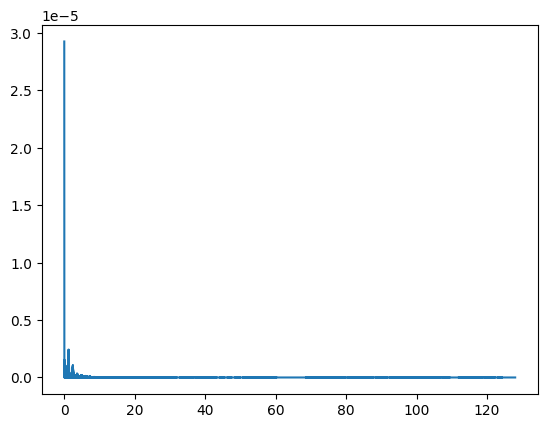

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4511-nsrr.xml
4511 Total: 363 samples | data length: 36928 (array([1, 2, 3, 4]), array([  1,  18, 209, 135]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4511.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4511.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137087  =      0.000 ... 39597.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137088)
10137088


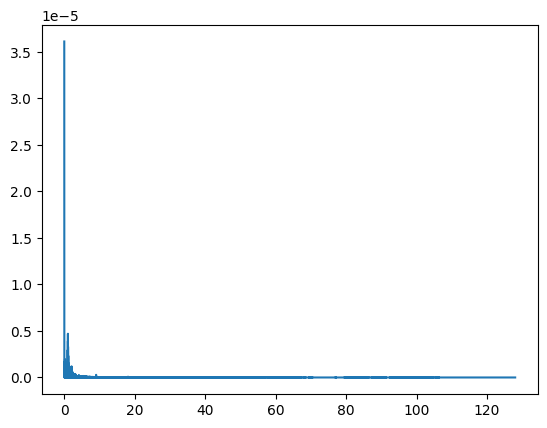

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4570-nsrr.xml
4570 Total: 106 samples | data length: 25585 (array([1, 2, 3, 4]), array([ 3,  2, 43, 58]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4570.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4570.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8754943  =      0.000 ... 34198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8754944)
8754944


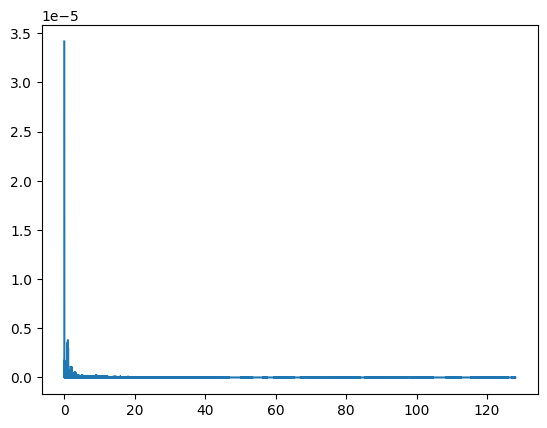

  0%|          | 0/1140 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4584-nsrr.xml
4584 Total: 116 samples | data length: 25211 (array([2, 3, 4]), array([ 6, 63, 47]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4584.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4584.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


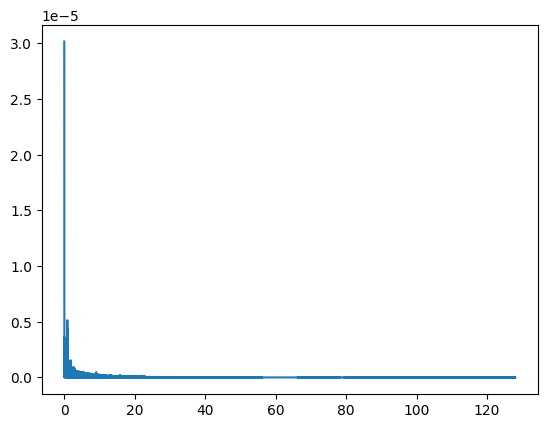

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4590-nsrr.xml
4590 Total: 164 samples | data length: 37523 (array([2, 3, 4]), array([  1, 144,  19]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4590.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4590.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11519743  =      0.000 ... 44998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11519744)
11519744


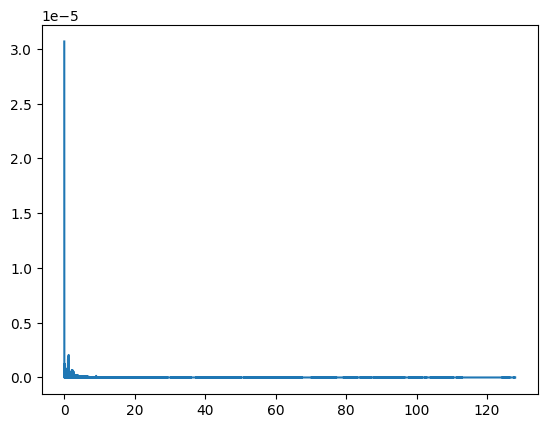

  0%|          | 0/1500 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4638-nsrr.xml
4638 Total: 361 samples | data length: 33933 (array([2, 3, 4]), array([ 88, 133, 140]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4638.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4638.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


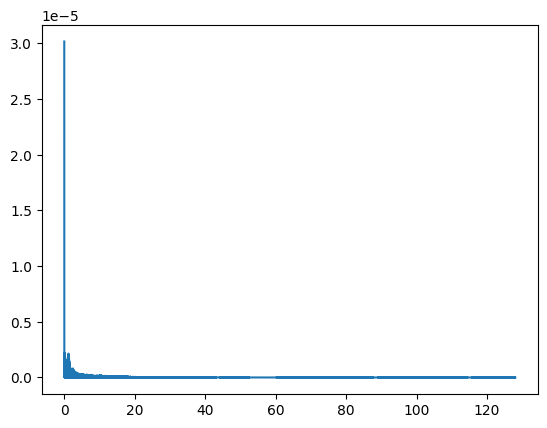

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4648-nsrr.xml
4648 Total: 94 samples | data length: 34615 (array([1, 2, 3, 4]), array([ 1, 18, 23, 52]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4648.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4648.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


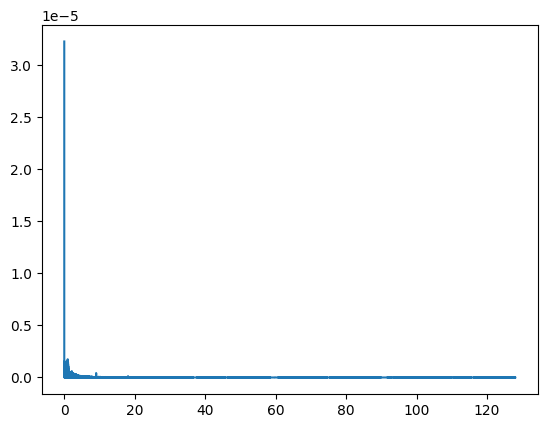

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4729-nsrr.xml
4729 Total: 25 samples | data length: 27085 (array([3, 4]), array([18,  7]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4729.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4729.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215999  =      0.000 ... 35999.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9216000)
9216000


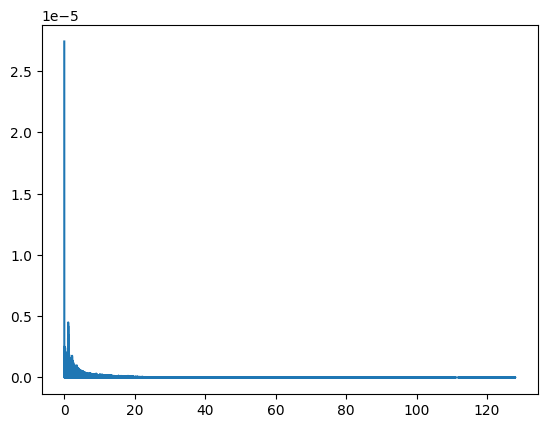

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4805-nsrr.xml
4805 Total: 235 samples | data length: 25672 (array([1, 2, 3, 4]), array([  6,  61,  53, 115]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4805.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4805.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7693567  =      0.000 ... 30052.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 7693568)
7693568


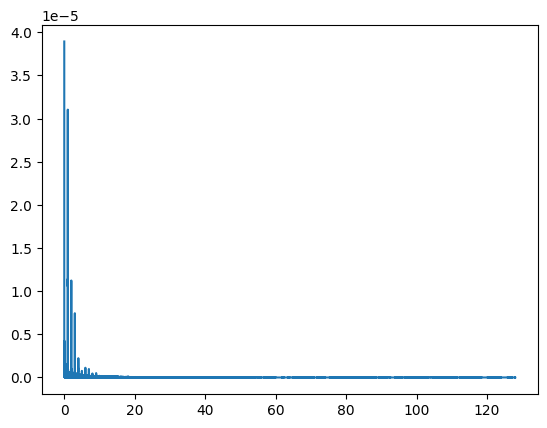

  0%|          | 0/1002 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4808-nsrr.xml
4808 Total: 179 samples | data length: 24448 (array([2, 3, 4]), array([40, 91, 48]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4808.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4808.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


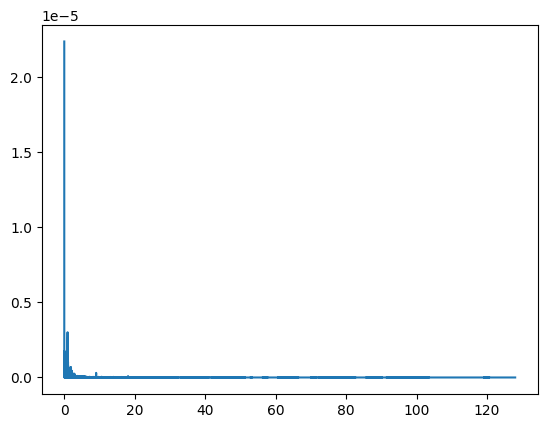

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4815-nsrr.xml
4815 Total: 45 samples | data length: 35938 (array([1, 2, 3, 4]), array([ 1,  1, 42,  1]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4815.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4815.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


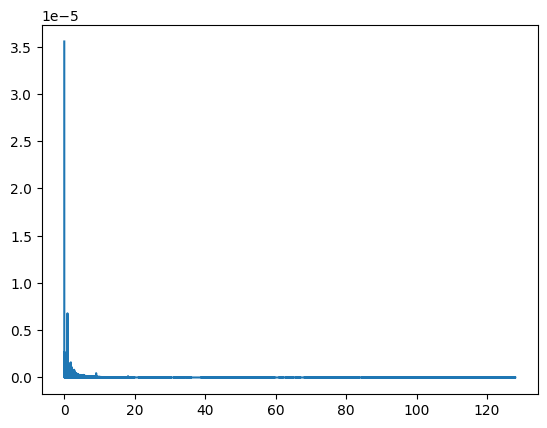

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4842-nsrr.xml
4842 Total: 77 samples | data length: 26177 (array([3, 4]), array([56, 21]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4842.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4842.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215487  =      0.000 ... 35997.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215488)
9215488


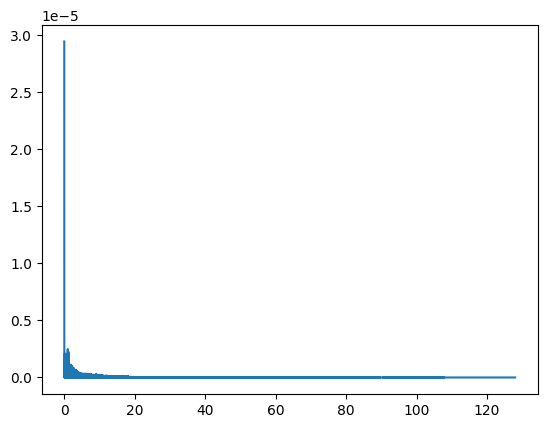

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4873-nsrr.xml
4873 Total: 255 samples | data length: 34564 (array([2, 3, 4]), array([  3, 199,  53]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4873.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4873.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10729727  =      0.000 ... 41912.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10729728)
10729728


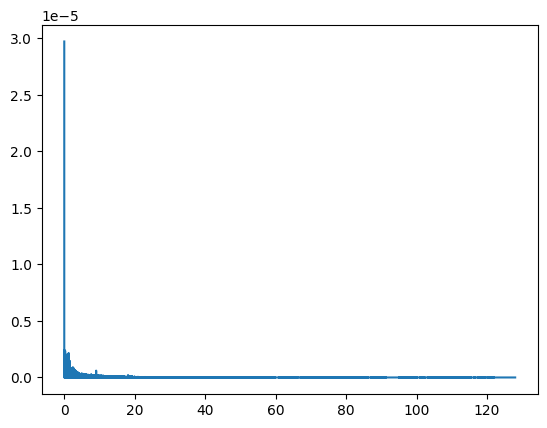

  0%|          | 0/1398 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-4878-nsrr.xml
4878 Total: 609 samples | data length: 40207 (array([1, 2, 3, 4]), array([  4,  82,  96, 427]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4878.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-4878.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10295807  =      0.000 ... 40217.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10295808)
10295808


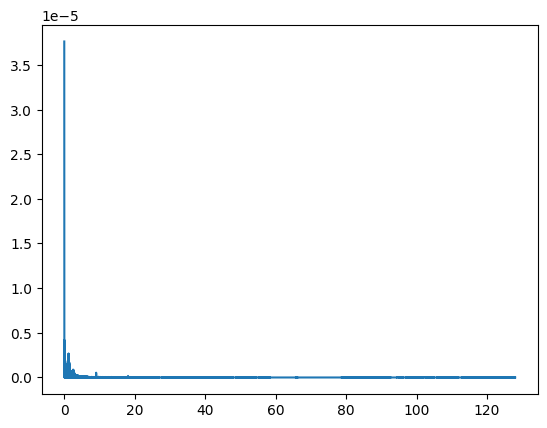

  0%|          | 0/1341 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5067-nsrr.xml
5067 Total: 121 samples | data length: 30309 (array([1, 2, 3, 4]), array([ 1,  2, 81, 37]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5067.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5067.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8754943  =      0.000 ... 34198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8754944)
8754944


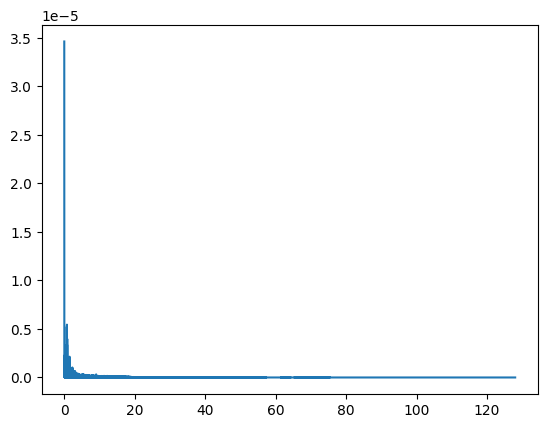

  0%|          | 0/1140 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5166-nsrr.xml
5166 Total: 150 samples | data length: 32199 (array([1, 2, 3, 4]), array([ 1,  9, 83, 57]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5166.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5166.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


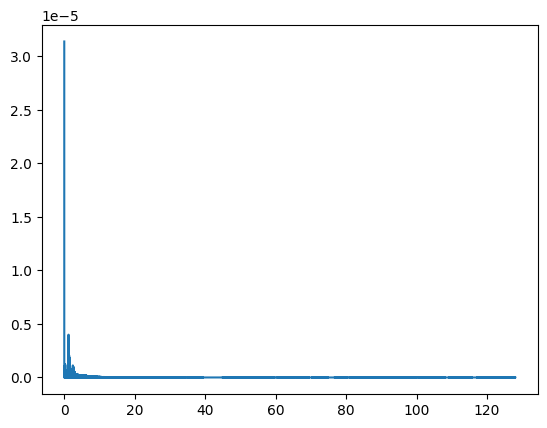

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5177-nsrr.xml
5177 Total: 459 samples | data length: 32060 (array([1, 2, 3, 4]), array([  1,  45,  70, 343]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5177.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5177.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137087  =      0.000 ... 39597.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137088)
10137088


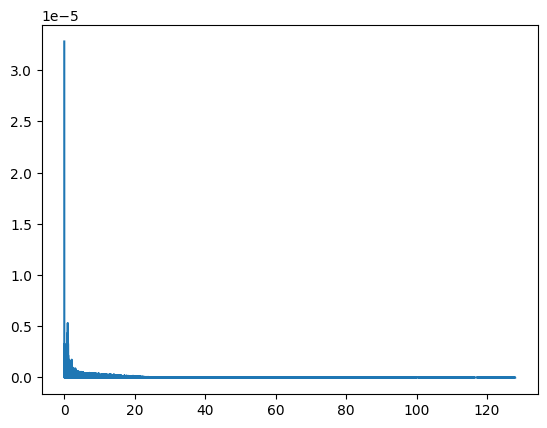

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5202-nsrr.xml
5202 Total: 355 samples | data length: 26697 (array([2, 3, 4]), array([229,  65,  61]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5202.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5202.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


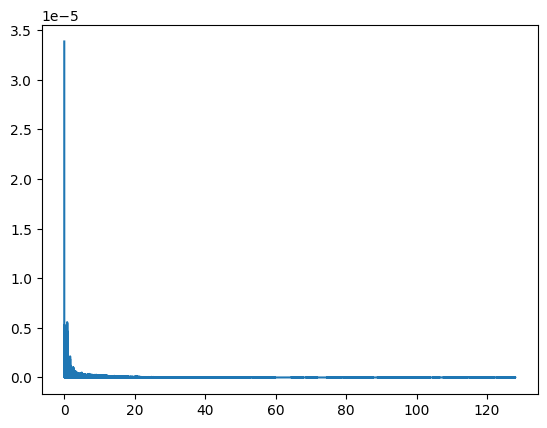

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5203-nsrr.xml
5203 Total: 398 samples | data length: 33609 (array([1, 2, 3, 4]), array([ 53,  76, 173,  96]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5203.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5203.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


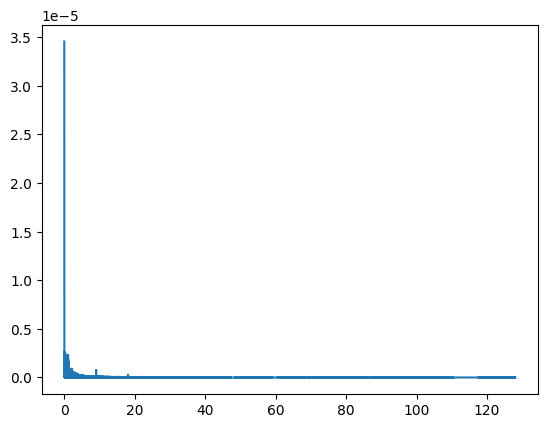

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5240-nsrr.xml
5240 Total: 154 samples | data length: 29101 (array([1, 2, 3, 4]), array([ 1, 27, 51, 75]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5240.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5240.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


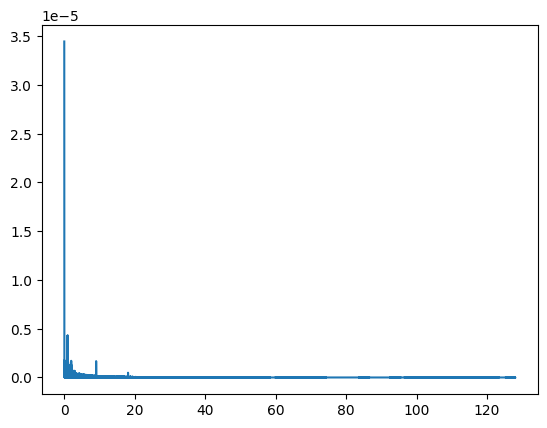

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5298-nsrr.xml
5298 Total: 168 samples | data length: 30968 (array([2, 3, 4]), array([10, 81, 77]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5298.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5298.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


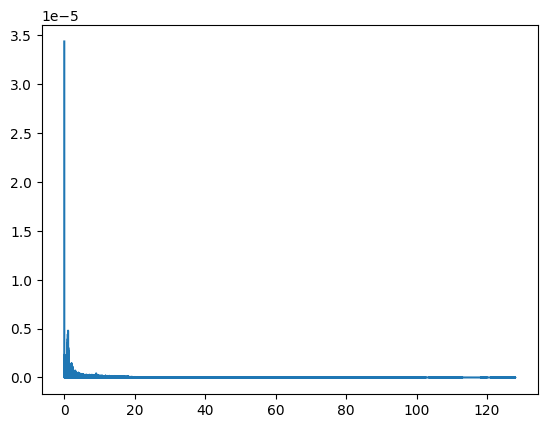

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5299-nsrr.xml
5299 Total: 63 samples | data length: 30796 (array([1, 2, 3, 4]), array([ 3,  5, 40, 15]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5299.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5299.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


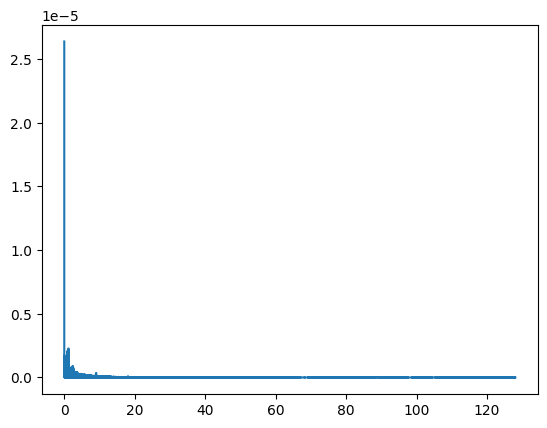

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5302-nsrr.xml
5302 Total: 151 samples | data length: 26370 (array([2, 3, 4]), array([ 10, 117,  24]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5302.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5302.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7372799  =      0.000 ... 28799.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 7372800)
7372800


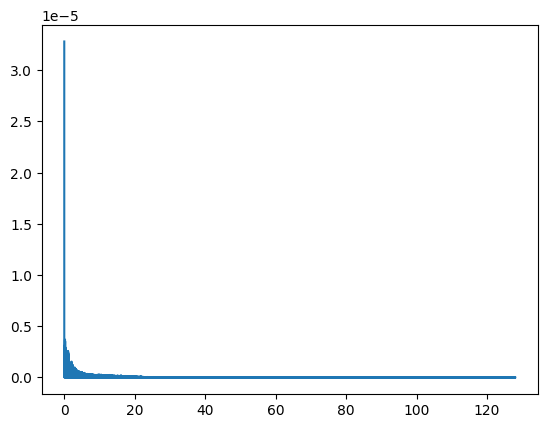

  0%|          | 0/961 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5308-nsrr.xml
5308 Total: 370 samples | data length: 35002 (array([1, 2, 3, 4]), array([ 10,  43, 184, 133]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5308.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5308.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


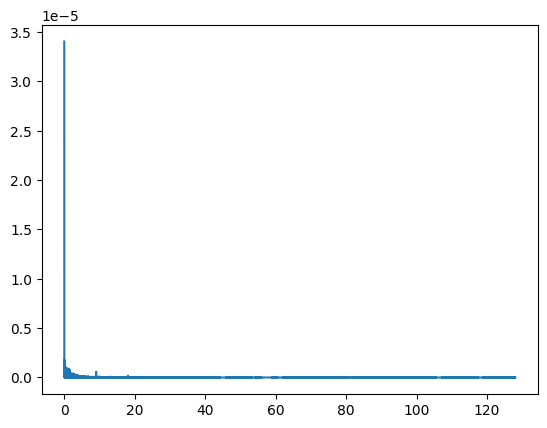

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5358-nsrr.xml
5358 Total: 410 samples | data length: 35652 (array([1, 2, 3, 4]), array([  1, 331,  43,  35]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5358.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5358.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


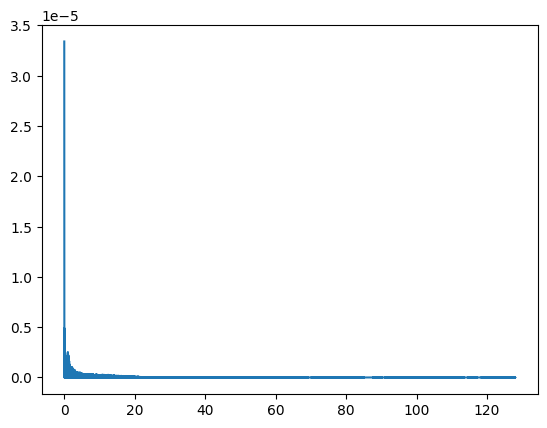

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5364-nsrr.xml
5364 Total: 105 samples | data length: 30398 (array([1, 2, 3, 4]), array([ 1,  5, 36, 63]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5364.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5364.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


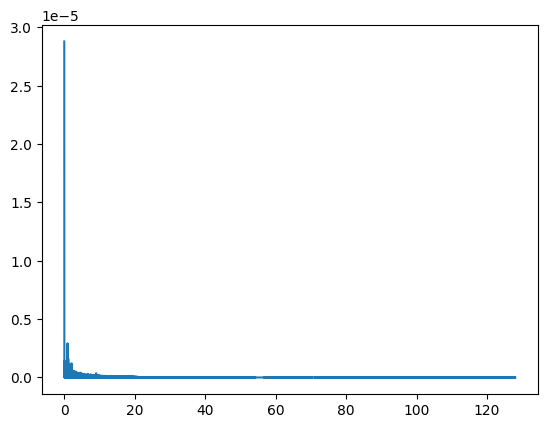

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5369-nsrr.xml
5369 Total: 295 samples | data length: 29275 (array([2, 3, 4]), array([  3,  98, 194]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5369.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5369.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215487  =      0.000 ... 35997.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215488)
9215488


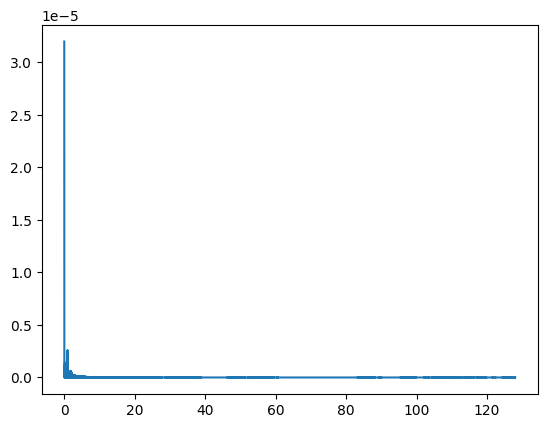

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5395-nsrr.xml
5395 Total: 333 samples | data length: 39228 (array([1, 2, 3, 4]), array([ 10, 287,   8,  28]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5395.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5395.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


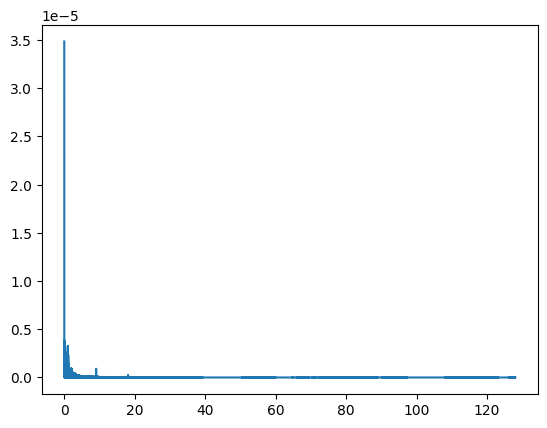

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5423-nsrr.xml
5423 Total: 322 samples | data length: 32396 (array([2, 3, 4]), array([ 80,  74, 168]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5423.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5423.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


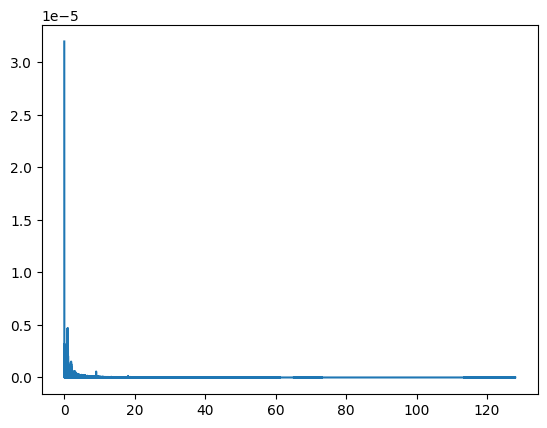

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5580-nsrr.xml
5580 Total: 317 samples | data length: 31535 (array([1, 2, 3, 4]), array([  6,  15, 166, 130]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5580.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5580.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


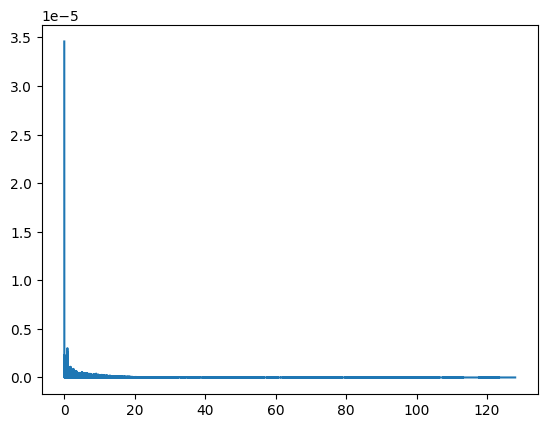

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5606-nsrr.xml
5606 Total: 70 samples | data length: 28411 (array([2, 3, 4]), array([ 3, 51, 16]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5606.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5606.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294399  =      0.000 ... 32399.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294400)
8294400


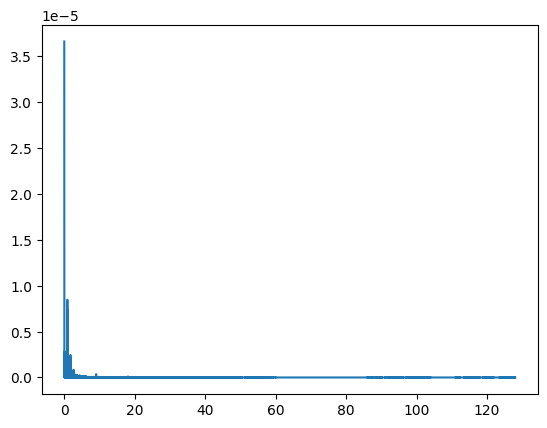

  0%|          | 0/1081 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5656-nsrr.xml
5656 Total: 129 samples | data length: 25826 (array([1, 2, 3, 4]), array([ 2, 10, 66, 51]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5656.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5656.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


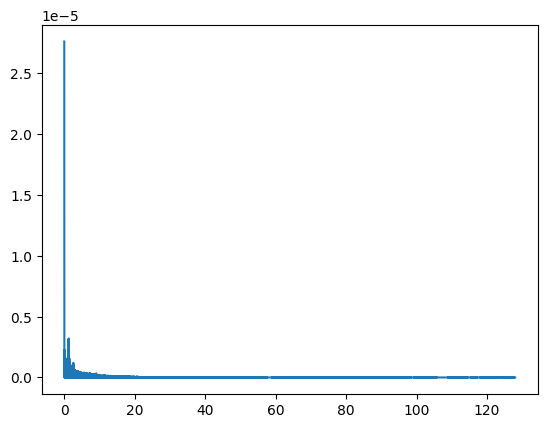

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5659-nsrr.xml
5659 Total: 74 samples | data length: 23948 (array([3, 4]), array([30, 44]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5659.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5659.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7372799  =      0.000 ... 28799.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 7372800)
7372800


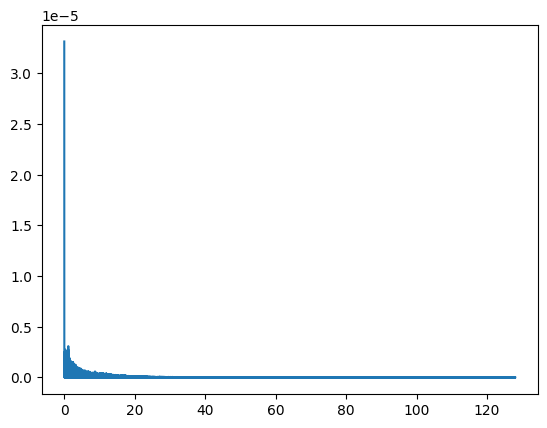

  0%|          | 0/961 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5669-nsrr.xml
5669 Total: 50 samples | data length: 34880 (array([3, 4]), array([38, 12]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5669.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5669.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


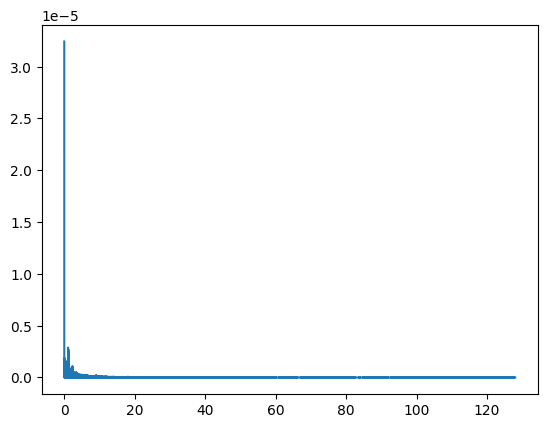

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5695-nsrr.xml
5695 Total: 385 samples | data length: 32735 (array([1, 2, 3, 4]), array([  4, 125, 144, 112]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5695.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5695.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


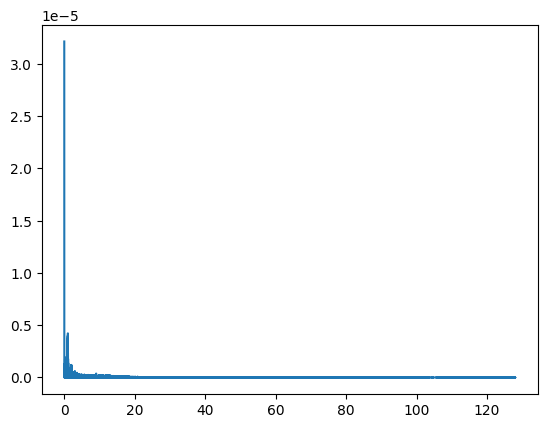

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5714-nsrr.xml
5714 Total: 554 samples | data length: 39569 (array([1, 2, 3, 4]), array([ 19,  36, 273, 226]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5714.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5714.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


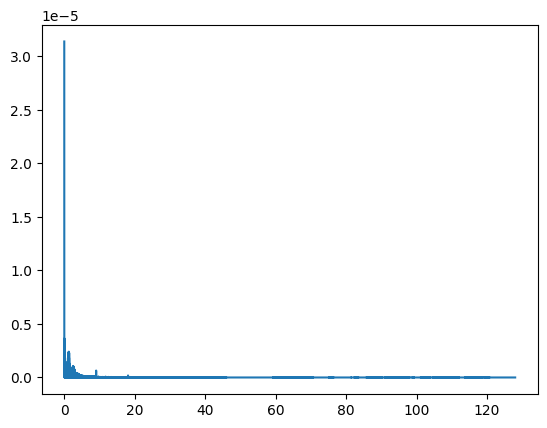

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5737-nsrr.xml
5737 Total: 128 samples | data length: 41901 (array([3, 4]), array([67, 61]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5737.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5737.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


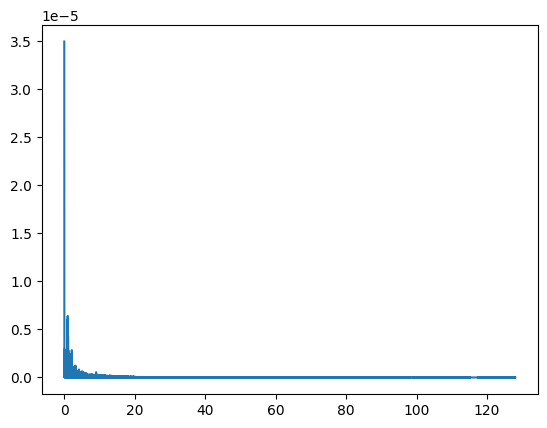

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5786-nsrr.xml
5786 Total: 150 samples | data length: 28504 (array([2, 3, 4]), array([ 14, 101,  35]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5786.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5786.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8754943  =      0.000 ... 34198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8754944)
8754944


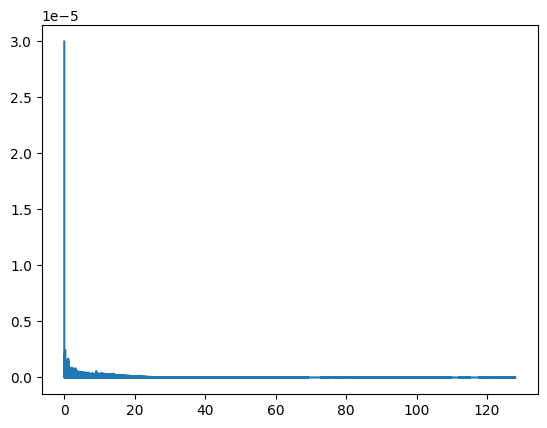

  0%|          | 0/1140 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5789-nsrr.xml
5789 Total: 219 samples | data length: 32385 (array([2, 3, 4]), array([ 19, 121,  79]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5789.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5789.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058687  =      0.000 ... 43197.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058688)
11058688


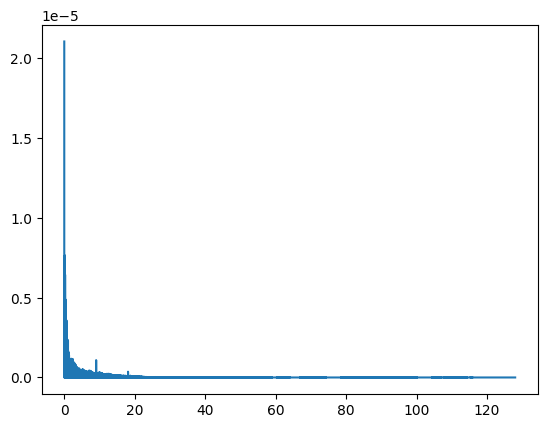

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5827-nsrr.xml
5827 Total: 121 samples | data length: 35244 (array([1, 2, 3, 4]), array([ 2,  1, 99, 19]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5827.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5827.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


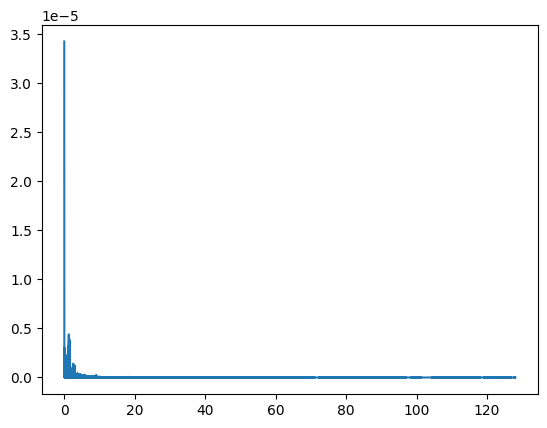

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5847-nsrr.xml
5847 Total: 529 samples | data length: 42527 (array([1, 2, 3, 4]), array([ 19,  18, 183, 309]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5847.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5847.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12441343  =      0.000 ... 48598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 12441344)
12441344


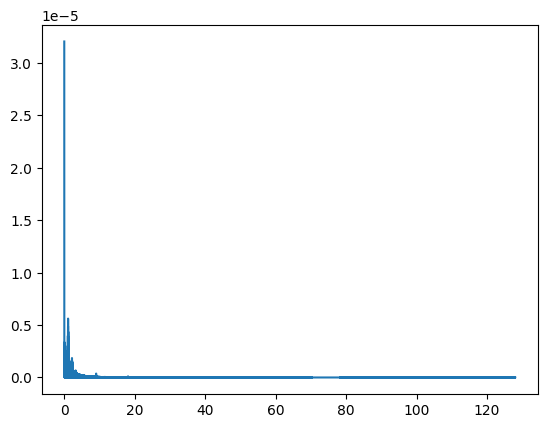

  0%|          | 0/1620 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5882-nsrr.xml
5882 Total: 155 samples | data length: 33599 (array([2, 3, 4]), array([  4, 108,  43]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5882.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5882.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


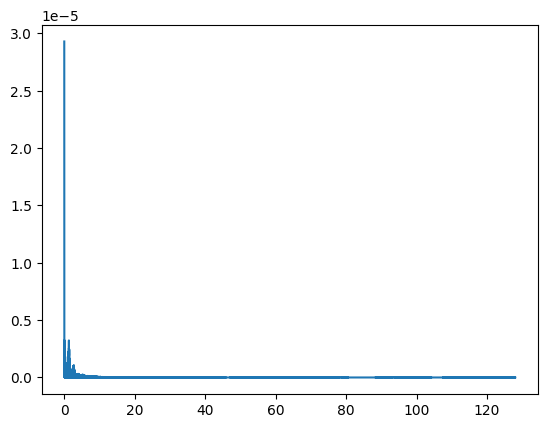

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5887-nsrr.xml
5887 Total: 124 samples | data length: 32646 (array([1, 2, 3, 4]), array([ 9, 16, 60, 39]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5887.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5887.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


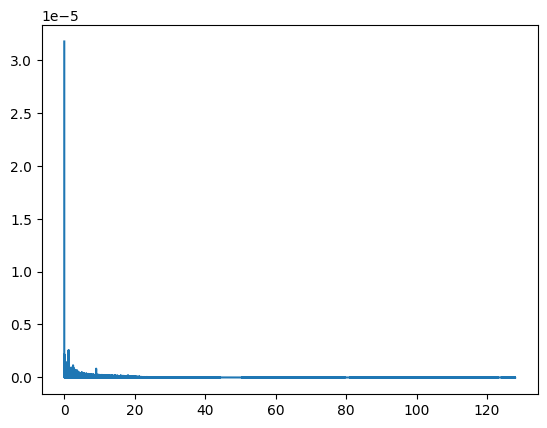

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5942-nsrr.xml
5942 Total: 107 samples | data length: 35744 (array([2, 3, 4]), array([ 1, 88, 18]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5942.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5942.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10598143  =      0.000 ... 41398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10598144)
10598144


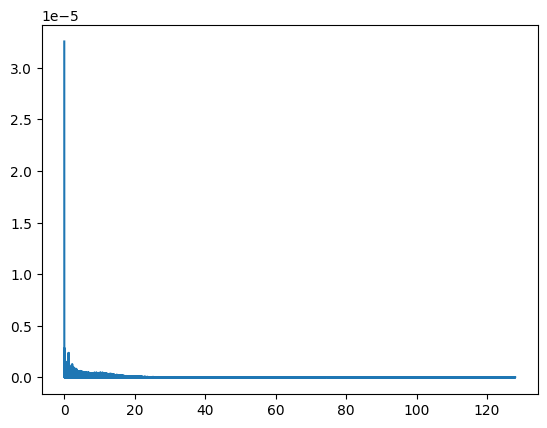

  0%|          | 0/1380 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5947-nsrr.xml
5947 Total: 172 samples | data length: 28766 (array([1, 3, 4]), array([  3, 154,  15]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5947.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5947.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


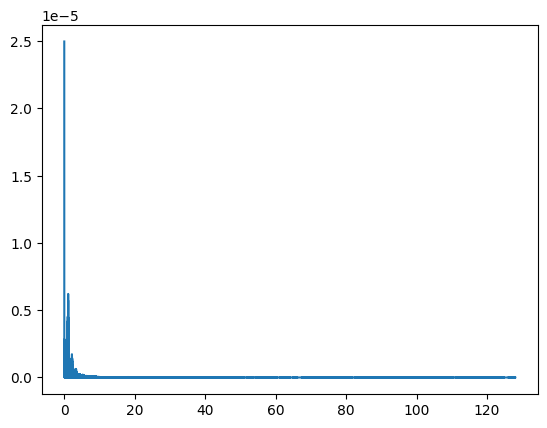

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5990-nsrr.xml
5990 Total: 168 samples | data length: 41330 (array([2, 3, 4]), array([  6, 111,  51]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5990.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5990.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


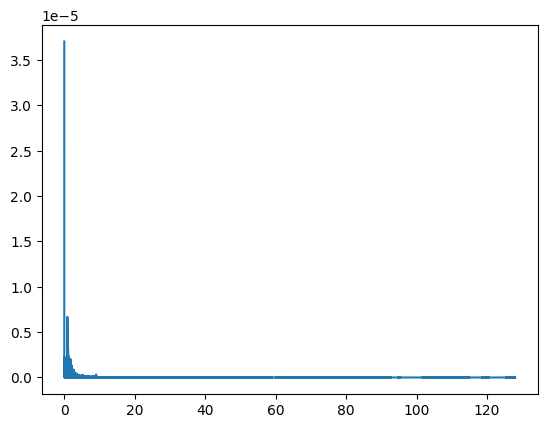

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-5995-nsrr.xml
5995 Total: 79 samples | data length: 29380 (array([1, 3]), array([ 1, 78]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5995.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-5995.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


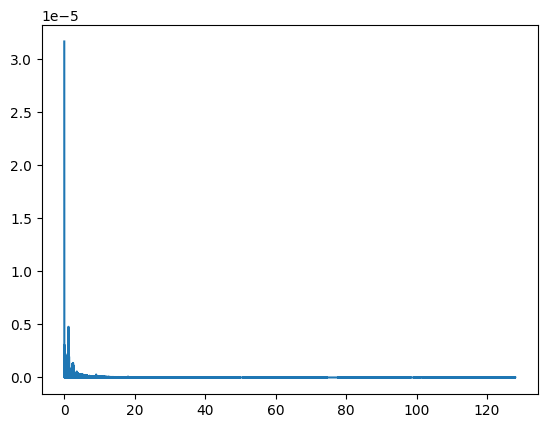

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6020-nsrr.xml
6020 Total: 113 samples | data length: 28379 (array([1, 2, 3, 4]), array([ 3, 12, 66, 32]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6020.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


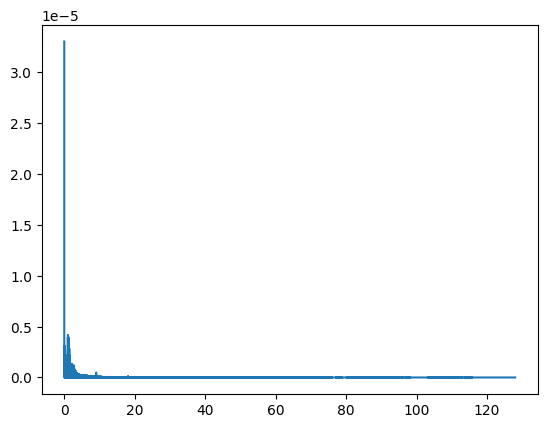

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6065-nsrr.xml
6065 Total: 92 samples | data length: 31093 (array([1, 2, 3, 4]), array([ 3,  2, 51, 36]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6065.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6065.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137087  =      0.000 ... 39597.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137088)
10137088


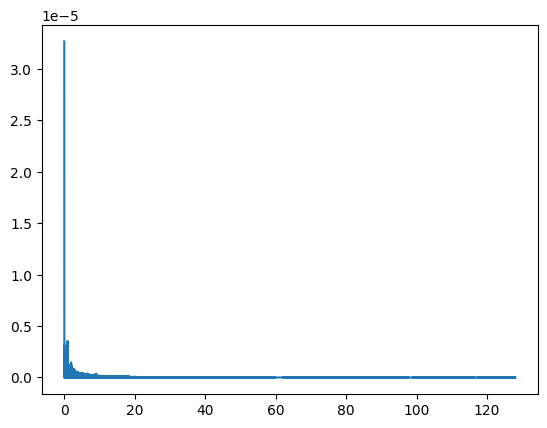

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6072-nsrr.xml
6072 Total: 246 samples | data length: 28010 (array([2, 3, 4]), array([  3, 219,  24]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6072.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6072.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


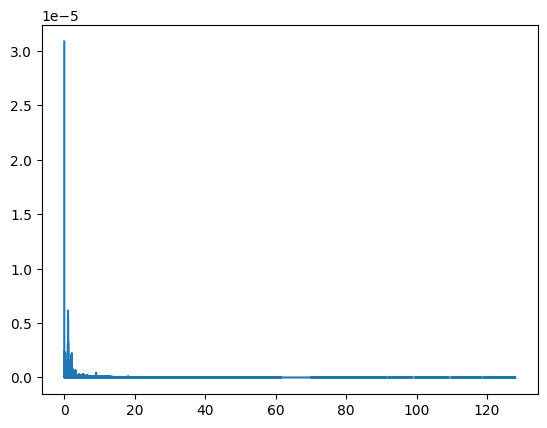

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6073-nsrr.xml
6073 Total: 217 samples | data length: 31396 (array([2, 3, 4]), array([  1, 156,  60]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6073.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6073.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


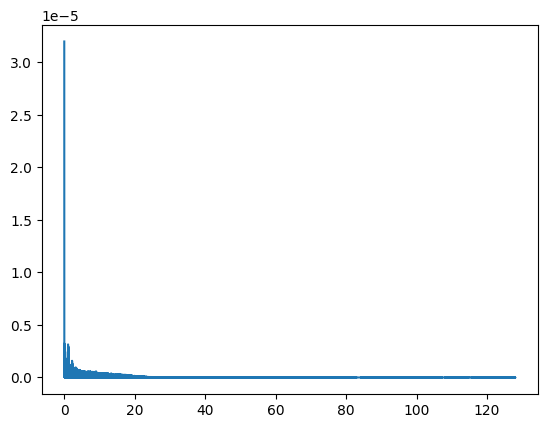

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6097-nsrr.xml
6097 Total: 128 samples | data length: 29513 (array([2, 3, 4]), array([  1, 118,   9]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6097.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6097.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


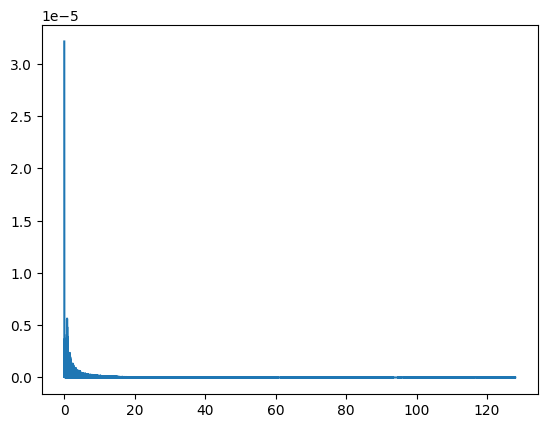

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6138-nsrr.xml
6138 Total: 314 samples | data length: 31120 (array([2, 3, 4]), array([ 10, 233,  71]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6138.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6138.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


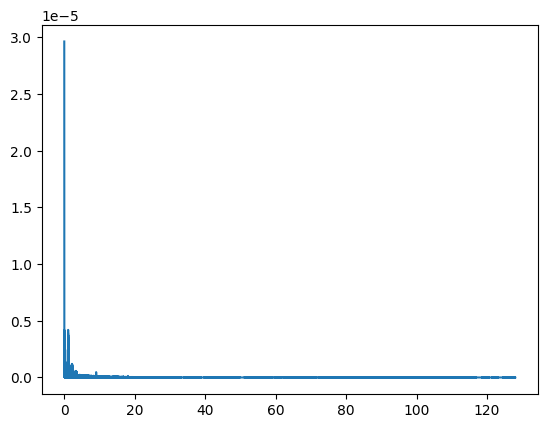

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6230-nsrr.xml
6230 Total: 72 samples | data length: 32314 (array([2, 3, 4]), array([ 3, 48, 21]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6230.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6230.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


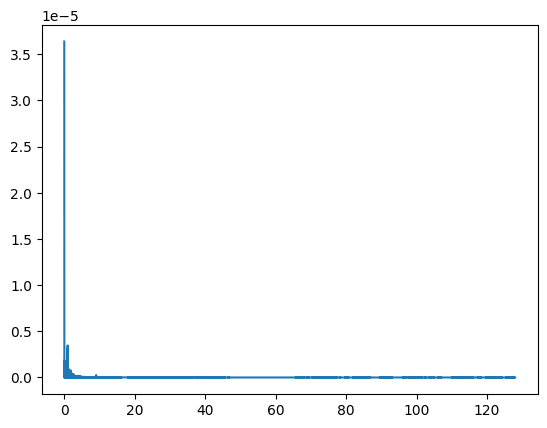

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6252-nsrr.xml
6252 Total: 53 samples | data length: 25217 (array([3, 4]), array([46,  7]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6252.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6252.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


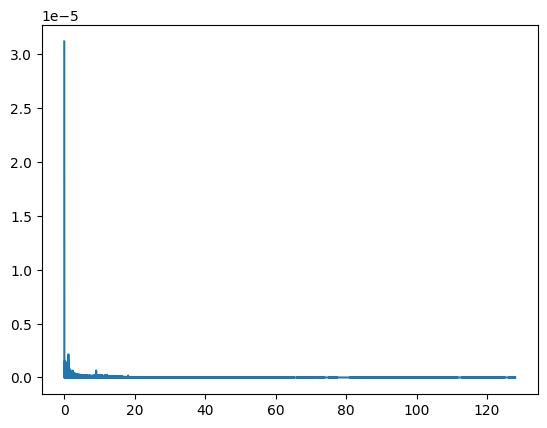

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6262-nsrr.xml
6262 Total: 83 samples | data length: 24865 (array([1, 2, 3, 4]), array([ 2,  1, 34, 46]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6262.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6262.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


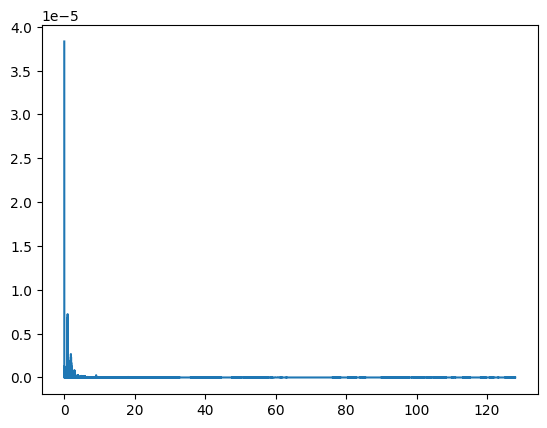

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6279-nsrr.xml
6279 Total: 196 samples | data length: 27268 (array([1, 2, 3, 4]), array([31, 43, 82, 40]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6279.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6279.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


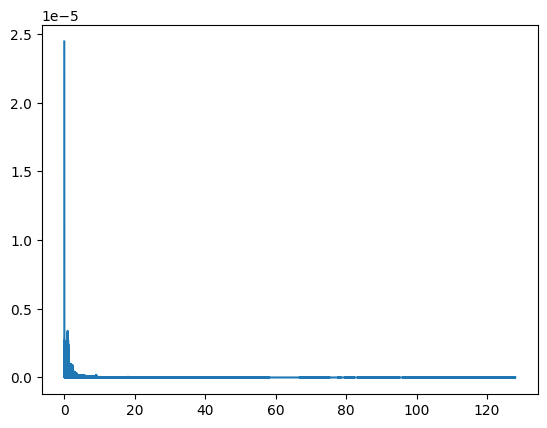

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6288-nsrr.xml
6288 Total: 104 samples | data length: 32174 (array([2, 3, 4]), array([ 2, 56, 46]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6288.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6288.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


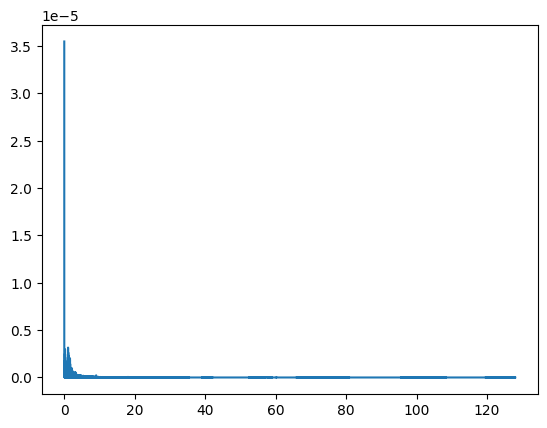

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6291-nsrr.xml
6291 Total: 452 samples | data length: 39891 (array([1, 2, 3, 4]), array([  3,   4, 384,  61]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6291.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6291.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 43199.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11059200)
11059200


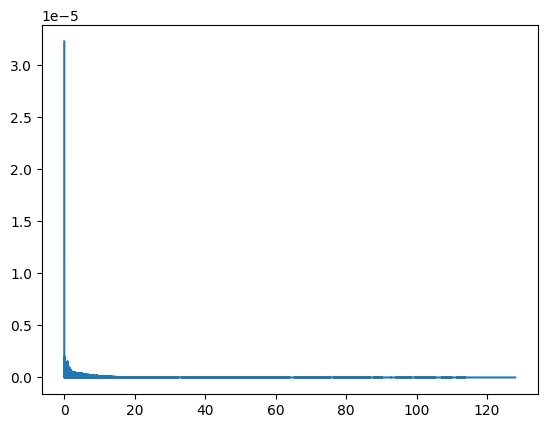

  0%|          | 0/1441 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6316-nsrr.xml
6316 Total: 177 samples | data length: 34705 (array([1, 2, 3, 4]), array([  2,   3, 153,  19]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6316.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6316.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


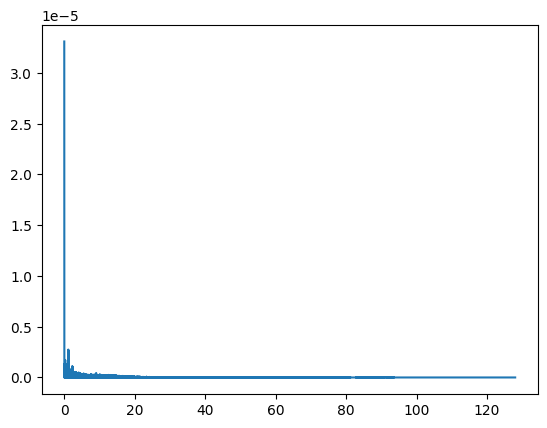

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6317-nsrr.xml
6317 Total: 142 samples | data length: 30470 (array([2, 3, 4]), array([ 3, 96, 43]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6317.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6317.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


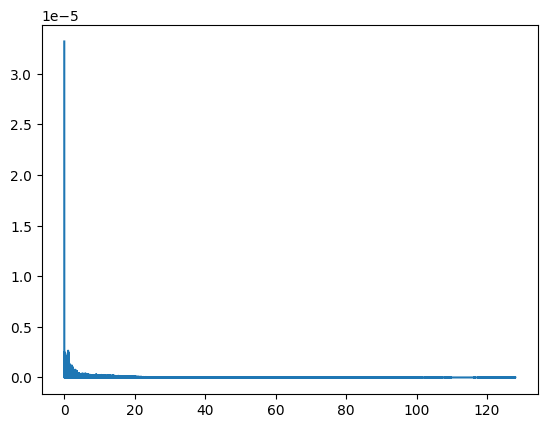

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6322-nsrr.xml
6322 Total: 432 samples | data length: 33579 (array([1, 2, 3, 4]), array([  3,   4, 261, 164]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6322.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6322.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


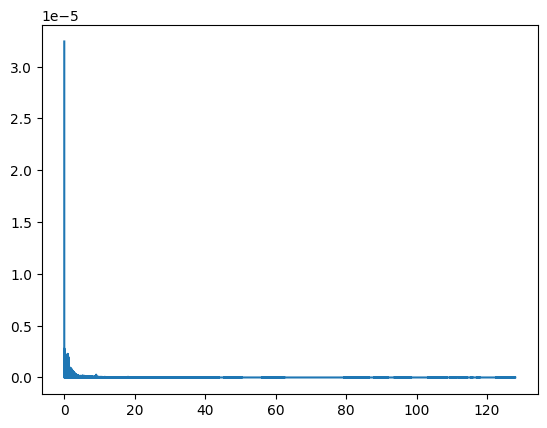

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6333-nsrr.xml
6333 Total: 131 samples | data length: 27560 (array([3, 4]), array([117,  14]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6333.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6333.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


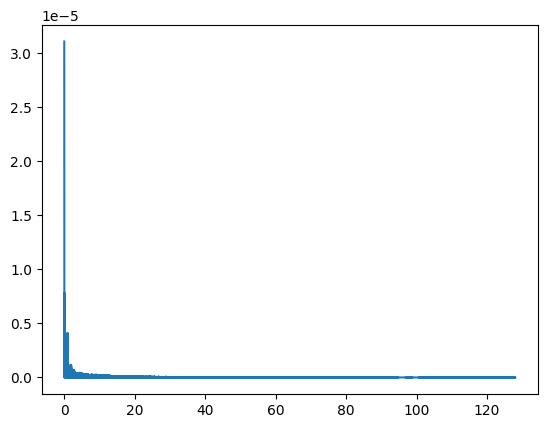

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6367-nsrr.xml
6367 Total: 187 samples | data length: 26570 (array([1, 2, 3, 4]), array([  2,  28,  50, 107]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6367.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6367.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


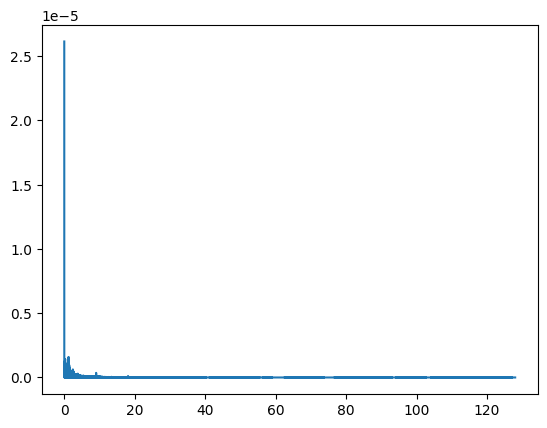

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6413-nsrr.xml
6413 Total: 308 samples | data length: 32303 (array([2, 3, 4]), array([  6,  96, 206]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6413.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6413.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


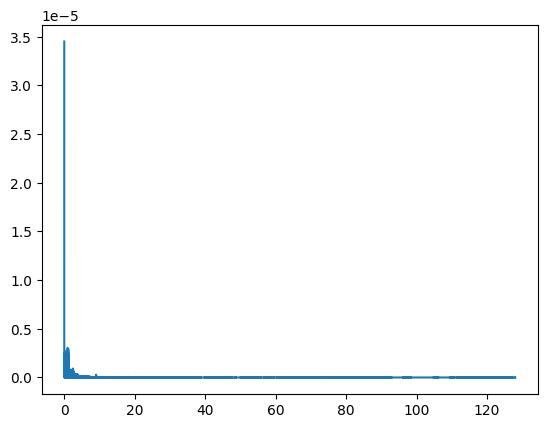

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6462-nsrr.xml
6462 Total: 311 samples | data length: 30540 (array([2, 3, 4]), array([ 15, 292,   4]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6462.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6462.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


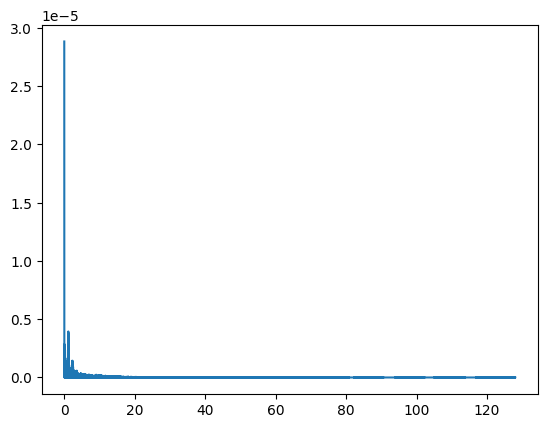

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6516-nsrr.xml
6516 Total: 318 samples | data length: 35771 (array([1, 2, 3, 4]), array([  7,   9,  99, 203]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6516.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6516.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11547135  =      0.000 ... 45105.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11547136)
11547136


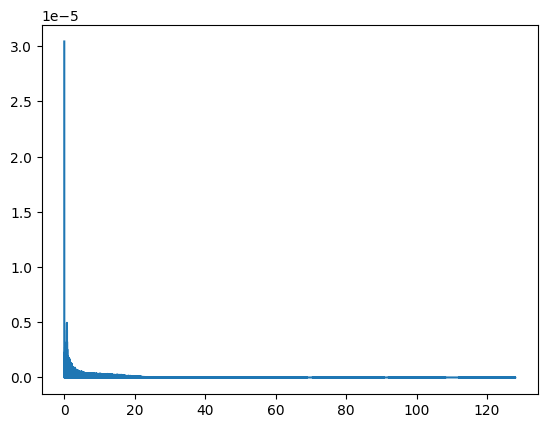

  0%|          | 0/1504 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6527-nsrr.xml
6527 Total: 52 samples | data length: 33492 (array([1, 3, 4]), array([ 1, 44,  7]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6527.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6527.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


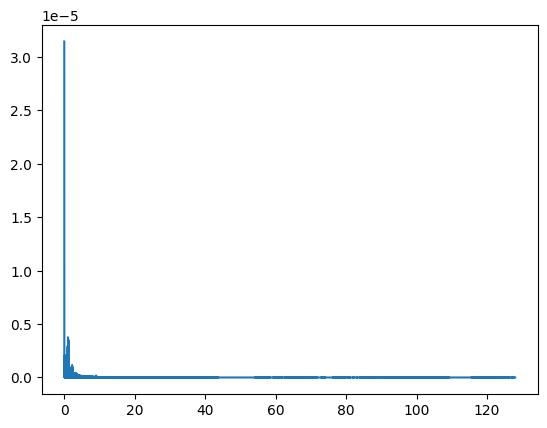

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6616-nsrr.xml
6616 Total: 411 samples | data length: 34670 (array([1, 2, 3, 4]), array([ 11, 378,  13,   9]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6616.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6616.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


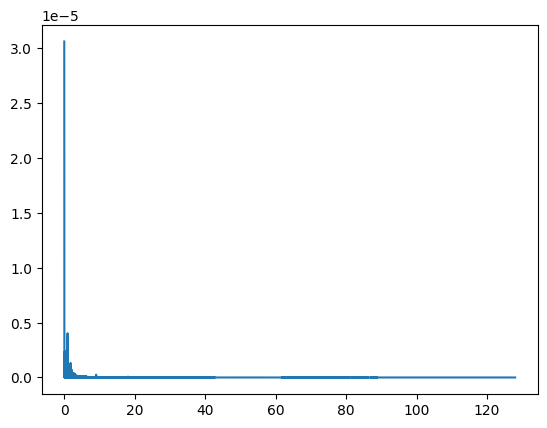

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6648-nsrr.xml
6648 Total: 293 samples | data length: 35387 (array([2, 3, 4]), array([  1, 202,  90]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6648.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6648.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


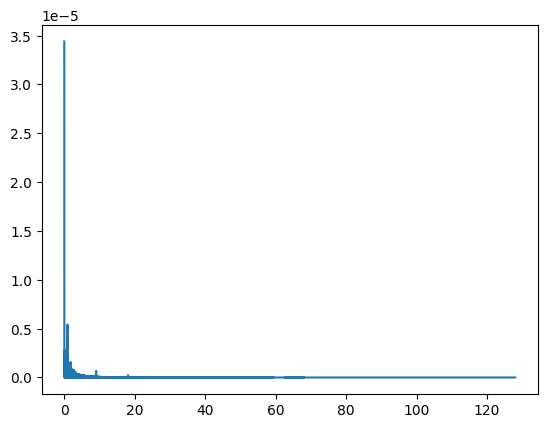

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6656-nsrr.xml
6656 Total: 260 samples | data length: 29143 (array([2, 3, 4]), array([ 35, 122, 103]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6656.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6656.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


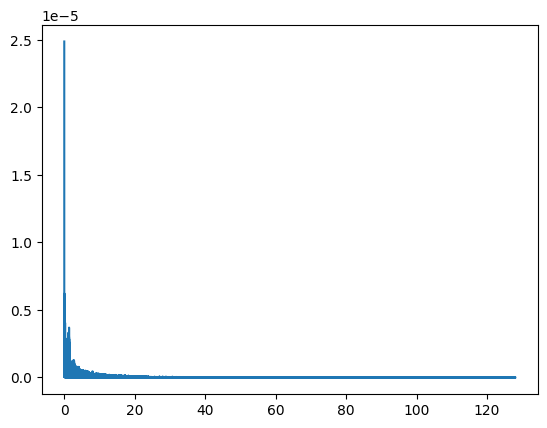

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6671-nsrr.xml
6671 Total: 180 samples | data length: 31603 (array([1, 3, 4]), array([  4, 124,  52]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6671.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6671.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215487  =      0.000 ... 35997.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215488)
9215488


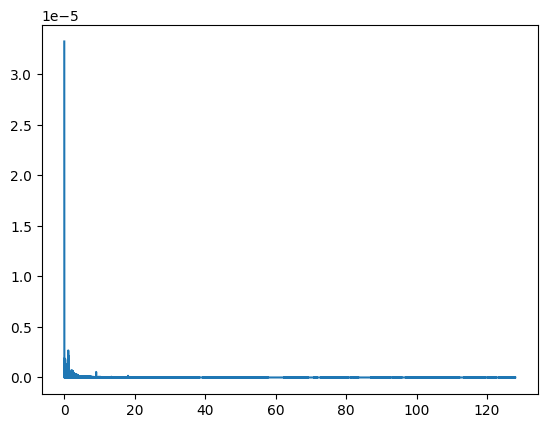

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6680-nsrr.xml
6680 Total: 114 samples | data length: 28601 (array([1, 2, 3, 4]), array([ 1,  6, 83, 24]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6680.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6680.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


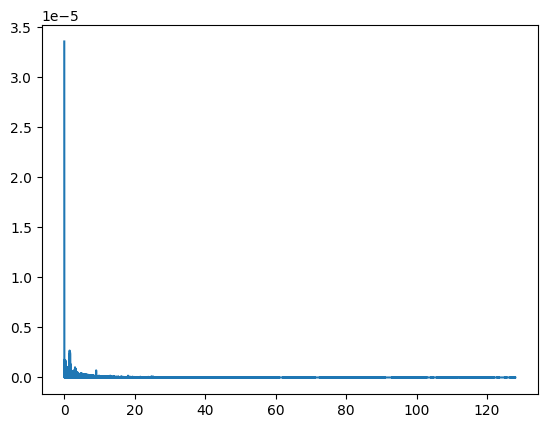

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6682-nsrr.xml
6682 Total: 270 samples | data length: 37784 (array([1, 2, 3, 4]), array([ 15,  55, 139,  61]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6682.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6682.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


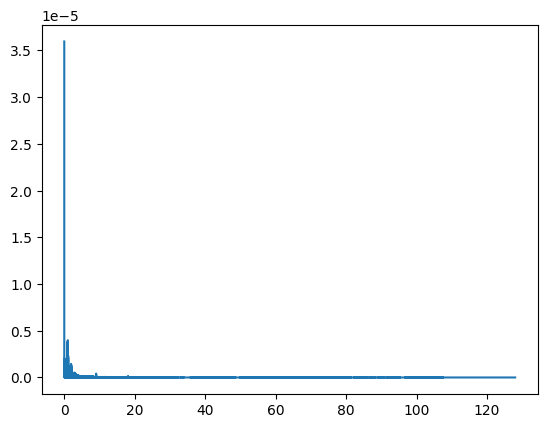

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6723-nsrr.xml
6723 Total: 73 samples | data length: 31960 (array([3, 4]), array([55, 18]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6723.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6723.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11980543  =      0.000 ... 46798.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11980544)
11980544


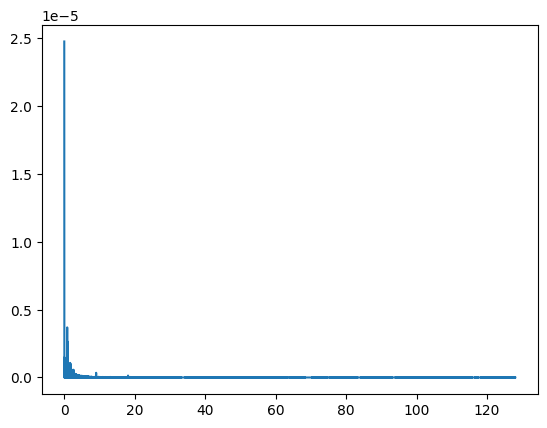

  0%|          | 0/1560 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6730-nsrr.xml
6730 Total: 29 samples | data length: 26518 (array([3, 4]), array([11, 18]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6730.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6730.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


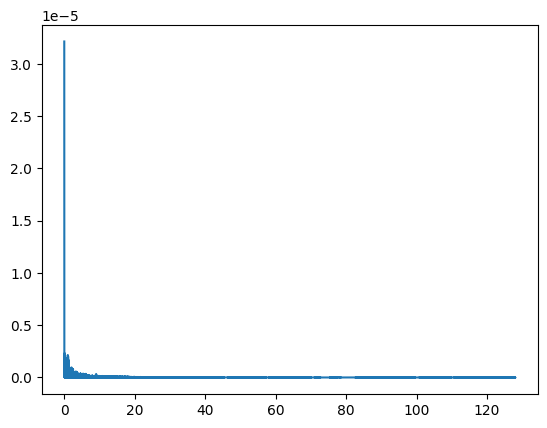

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6739-nsrr.xml
6739 Total: 187 samples | data length: 33716 (array([2, 3, 4]), array([ 13, 134,  40]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6739.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6739.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058943  =      0.000 ... 43198.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058944)
11058944


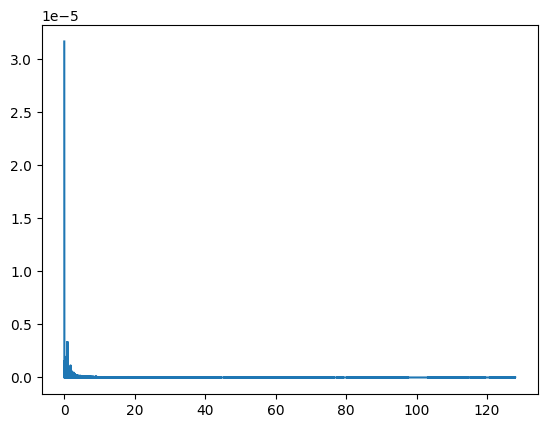

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6756-nsrr.xml
6756 Total: 372 samples | data length: 31546 (array([1, 2, 3, 4]), array([  5,  85,  90, 192]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6756.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6756.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10137343  =      0.000 ... 39598.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 10137344)
10137344


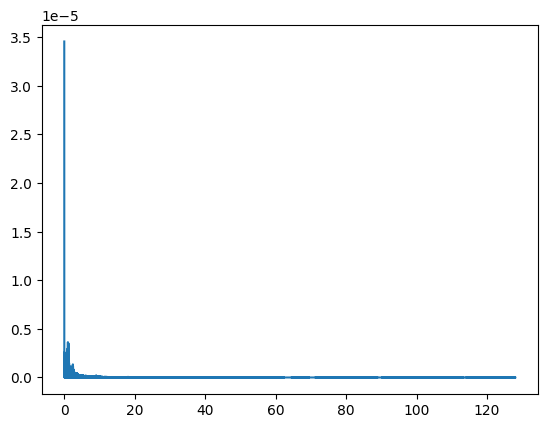

  0%|          | 0/1320 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6781-nsrr.xml
6781 Total: 250 samples | data length: 32398 (array([1, 2, 3, 4]), array([  3,   3, 146,  98]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6781.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6781.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8294143  =      0.000 ... 32398.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 8294144)
8294144


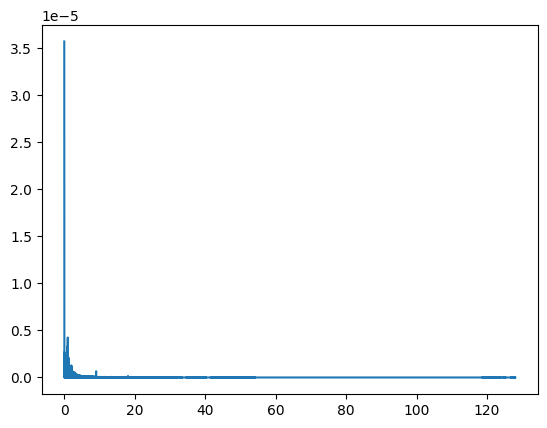

  0%|          | 0/1080 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6784-nsrr.xml
6784 Total: 141 samples | data length: 27487 (array([2, 3, 4]), array([19, 44, 78]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6784.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6784.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215999  =      0.000 ... 35999.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9216000)
9216000


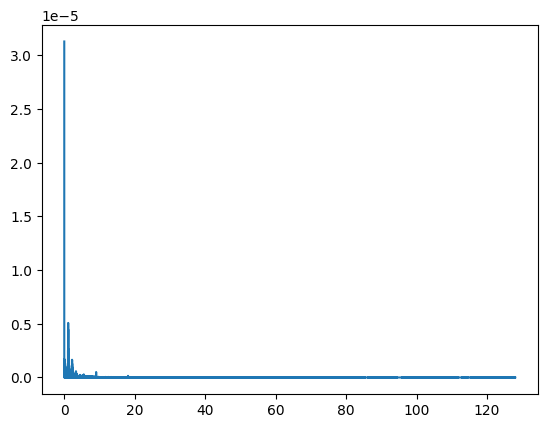

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6789-nsrr.xml
6789 Total: 142 samples | data length: 28635 (array([2, 3, 4]), array([ 8, 92, 42]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6789.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6789.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11058687  =      0.000 ... 43197.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 11058688)
11058688


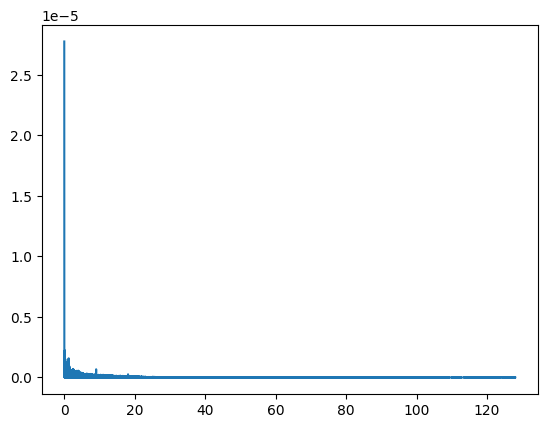

  0%|          | 0/1440 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6807-nsrr.xml
6807 Total: 358 samples | data length: 30082 (array([1, 2, 3, 4]), array([  4, 114,  57, 183]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6807.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6807.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215743  =      0.000 ... 35998.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9215744)
9215744


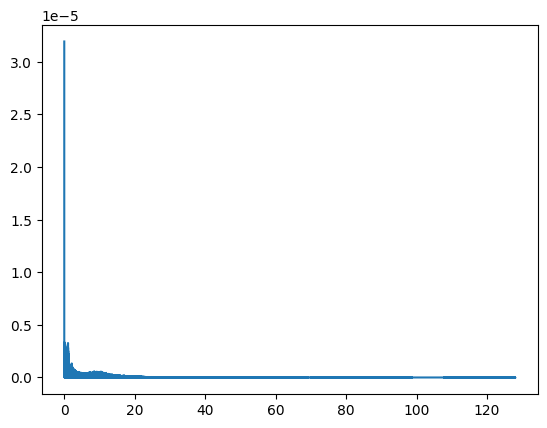

  0%|          | 0/1200 [00:00<?, ?it/s]

Found last window
Found last window
overlap_count 0
../nas/NSRR/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-6811-nsrr.xml
6811 Total: 322 samples | data length: 32250 (array([1, 2, 3, 4]), array([  3, 144,  65, 110]))
../nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6811.edf
Extracting EDF parameters from /mount/nas/NSRR/mesa/polysomnography/edfs/mesa-sleep-6811.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9215999  =      0.000 ... 35999.996 secs...
['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']
🚨 No resampling applied (sampling rate is 256.0 Hz. as original).
(1, 9216000)
9216000


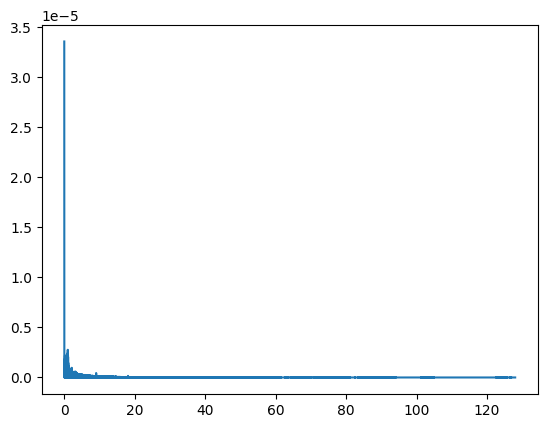

  0%|          | 0/1201 [00:00<?, ?it/s]

Found last window
overlap_count 0


NameError: name 'sum_anno' is not defined

In [145]:
# ################################### MTM
output_path = 'processed_dataset/mesa/mtm/60_stride_30/'
sum_anno, sum_label_apnea, sum_overlap = create_file_windows_MTM(windows_size = 60, stride = 30, shifted = 0, threshold = 0.5 , output_path = output_path, signal_type = 'ppg')

# output_path = 'processed_dataset/mesa/mtm/30/'
# sum_anno, sum_label_apnea, sum_overlap = create_file_windows_MTM(windows_size = 30, stride = 30, shifted = 0, threshold = 0.5 , output_path = output_path, signal_type = 'spo2')

In [48]:
# aa = []
aa.append({
                    'start': 312,
                    'duration': 123,
                    'event': 123
                })

In [58]:
[d['event'] for d in aa]

[123, 123]